# Literature Review of Urban Scaling Laws - Empirical Evidence
This notebook consoldate the code to perform a statistical analysis of empirical  evidence foun in literature about urban scaling laws

In [2]:
#import libraries
library(magrittr)
library(dplyr)   
library(plyr)
library(tidyr)


library(lubridate)


library(data.table)
library(googledrive)
library(googlesheets4)

library(ggplot2)
library(cowplot)

In [3]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

## Import Data
Data was collected from several publications into this google spreadsheet: https://docs.google.com/spreadsheets/d/1jC_UzTFfXRqd4sAO4geqxJmrqUyJSFk9wtJ4w-xLKRQ/edit?usp=sharing

Prior preparing:
* clean and standardize symbols (recontruction of CI from papers +-SD)
* defined variable scaling familly and regime
* select non-ambigous variables to be used
* estract method, urban unit, urban system, and year
* for Ignazi(2015): estimate exponents as the mean value of the exponent inerval
* for Cottineu(2017): visually estimate average exponents

In [4]:
#####################
####  Load Data  ####
#####################

scalingreview_full <- fread('https://docs.google.com/spreadsheets/d/e/2PACX-1vTk6f_slhYgZQTpOn70G9ofP6H79dBOn1O3zm1yBuLcwo1eolsjgKXkNhiauNaHdZ1ytOzEbRGVzwzd/pub?gid=379760173&single=true&output=csv')


nrow(scalingreview_full)

head(scalingreview_full)

[1] 546

pubication_reference_year publication_reference variable          
1 2013                      Alves 2013            Homicides         
2 2013                      Alves 2013            Child labour      
3 2013                      Alves 2013            Elderly population
4 2013                      Alves 2013            Female population 
5 2013                      Alves 2013            Male population   
6 2013                      Alves 2013            Sanitation        
  variable_familly          variable_regime scaling_exponent use
1 crime                     superlinear     1.15             y  
2 crime                     ND              0.77             n  
3 demography                linear          1.01             y  
4 demography                linear          1.01             y  
5 demography                linear          0.98             y  
6 individual basic services linear          1.00             y  
  scaling_exponent_ci r2 n  ⋯ data_year urban_unit   stdr_error t_ratio p_value
1 1.10-1.20              49 ⋯ 2000      municipality                           
2 0.75-0.79              49 ⋯ 2000      municipality                           
3 0.98-1.04              49 ⋯ 2000      municipality                           
4 -                      49 ⋯ 2000      municipality                           
5 -                      49 ⋯ 2000      municipality                           
6 -                      49 ⋯ 2000      municipality                           
  dw method obd
1    OLS       
2    OLS       
3    OLS       
4    OLS       
5    OLS       
6    OLS       
  reference_long                                                                                                                                                                     
1 Alves LGA, Ribeiro HV, Lenzi EK, Mendes RS (2013) Distance to the Scaling Law: A Useful Approach for Unveiling Relationships between Crime and Urban Metrics. PLoS ONE 8(8): e69580
2 Alves LGA, Ribeiro HV, Lenzi EK, Mendes RS (2013) Distance to the Scaling Law: A Useful Approach for Unveiling Relationships between Crime and Urban Metrics. PLoS ONE 8(8): e69580
3 Alves LGA, Ribeiro HV, Lenzi EK, Mendes RS (2013) Distance to the Scaling Law: A Useful Approach for Unveiling Relationships between Crime and Urban Metrics. PLoS ONE 8(8): e69580
4 Alves LGA, Ribeiro HV, Lenzi EK, Mendes RS (2013) Distance to the Scaling Law: A Useful Approach for Unveiling Relationships between Crime and Urban Metrics. PLoS ONE 8(8): e69580
5 Alves LGA, Ribeiro HV, Lenzi EK, Mendes RS (2013) Distance to the Scaling Law: A Useful Approach for Unveiling Relationships between Crime and Urban Metrics. PLoS ONE 8(8): e69580
6 Alves LGA, Ribeiro HV, Lenzi EK, Mendes RS (2013) Distance to the Scaling Law: A Useful Approach for Unveiling Relationships between Crime and Urban Metrics. PLoS ONE 8(8): e69580
  doi                         
1 10.1371/journal.pone.0069580
2 10.1371/journal.pone.0069580
3 10.1371/journal.pone.0069580
4 10.1371/journal.pone.0069580
5 10.1371/journal.pone.0069580
6 10.1371/journal.pone.0069580

In [5]:
scalingreview <- scalingreview_full %>% filter(use == "y")
scalingreview_noND <- scalingreview[scalingreview$variable_regime!="ND",]

scalingreview$publication_year_clean <- lubridate::ymd(scalingreview$publication_year_clean, truncated = 2L)


nrow(scalingreview)

str(scalingreview)


[1] 198

'data.frame':	198 obs. of  23 variables:
 $ pubication_reference_year: int  2013 2013 2013 2013 2013 2013 2014 2014 2014 2014 ...
 $ publication_reference    : chr  "Alves 2013" "Alves 2013" "Alves 2013" "Alves 2013" ...
 $ variable                 : chr  "Homicides" "Elderly population" "Female population" "Male population" ...
 $ variable_familly         : chr  "crime" "demography" "demography" "demography" ...
 $ variable_regime          : chr  "superlinear" "linear" "linear" "linear" ...
 $ scaling_exponent         : num  1.15 1.01 1.01 0.98 1 1.21 0.82 1.01 1.01 1 ...
 $ use                      : chr  "y" "y" "y" "y" ...
 $ scaling_exponent_ci      : chr  "1.10-1.20" "0.98-1.04" "-" "-" ...
 $ r2                       : chr  "" "" "" "" ...
 $ n                        : chr  "49" "49" "49" "49" ...
 $ urban_system_merge       : chr  "Brazil" "Brazil" "Brazil" "Brazil" ...
 $ urban_system             : chr  "Brazil" "Brazil" "Brazil" "Brazil" ...
 $ publication_year_clean   : Date

## Data Analysis

### year
when multiple years were presented, we used the most recent one

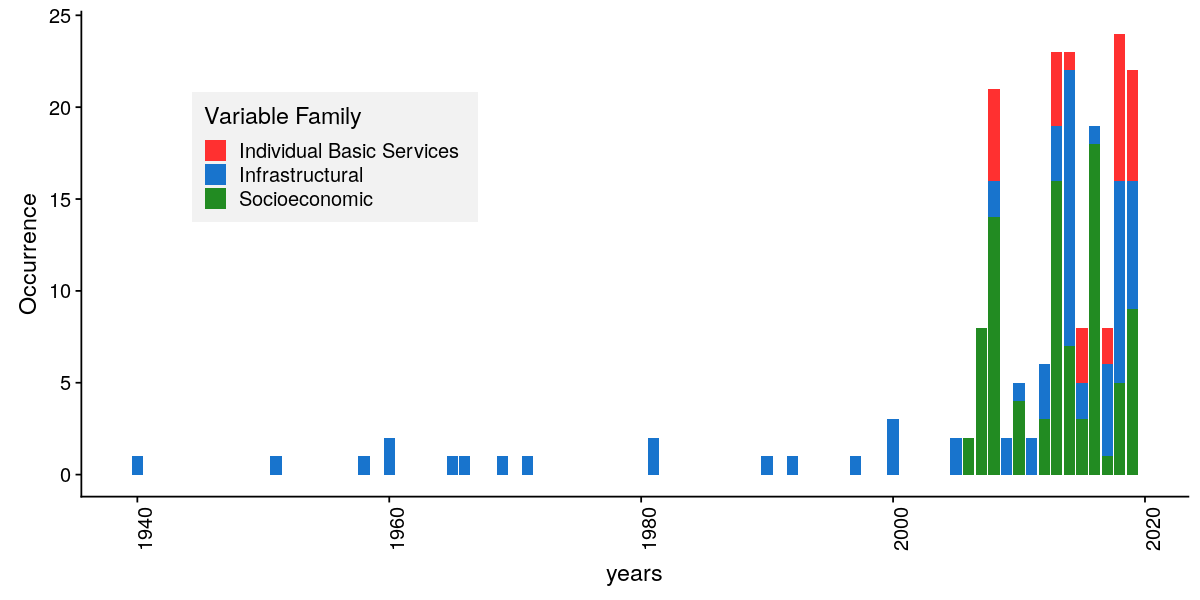

In [6]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(scalingreview_noND)+geom_bar(aes(publication_year_clean, fill=variable_regime))+
    theme(legend.position = c(0.1, 0.7),legend.background = element_rect(fill = "gray95"),
          axis.text.x = element_text(angle = 90, hjust = 1))+
    scale_fill_manual(values = c("firebrick1", "dodgerblue3", "forestgreen"),
                      name = "Variable Family", labels = c("Individual Basic Services", "Infrastructural", "Socioeconomic"))+
    xlab("years")+ylab("Occurrence")

Warning message:
“position_stack requires non-overlapping x intervals”

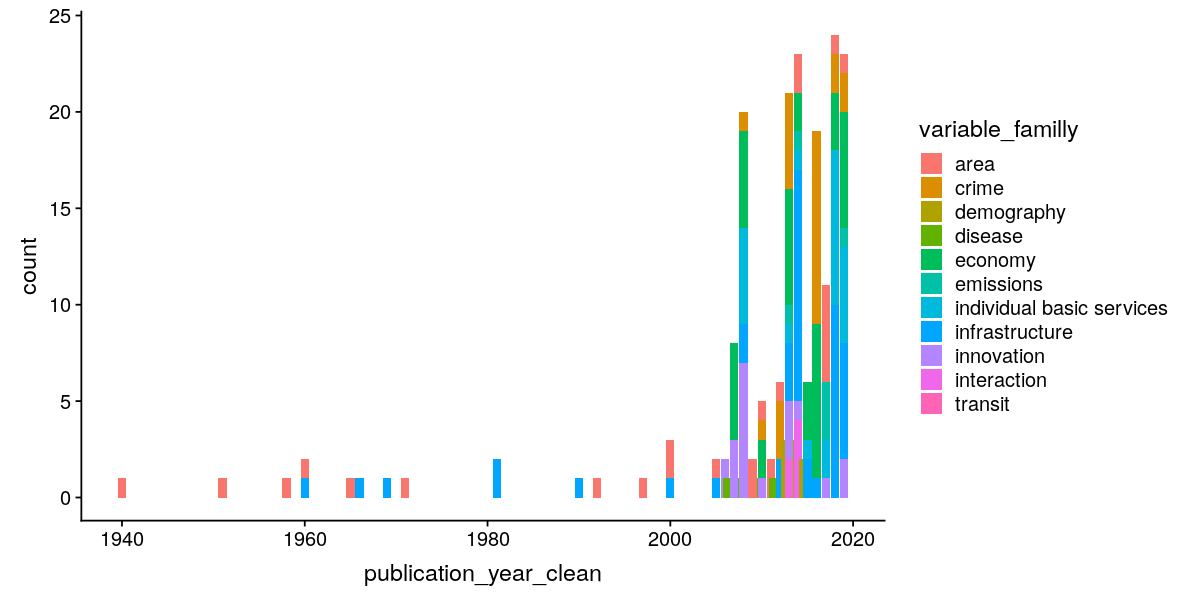

In [22]:
options(repr.plot.width=10, repr.plot.height=5)

ggplot(scalingreview)+geom_bar(aes(publication_year_clean, fill=variable_familly))

### Scaling Regimes

In [7]:
mu <- ddply(scalingreview_noND, "variable_regime", summarise, grp.mean=mean(scaling_exponent))

mu$grp.expected <- c(1, 0.85, 1.15)

mu

variable_regime grp.mean  grp.expected
1 linear          1.0374931 1.00        
2 sublinear       0.8801849 0.85        
3 superlinear     1.1975656 1.15

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


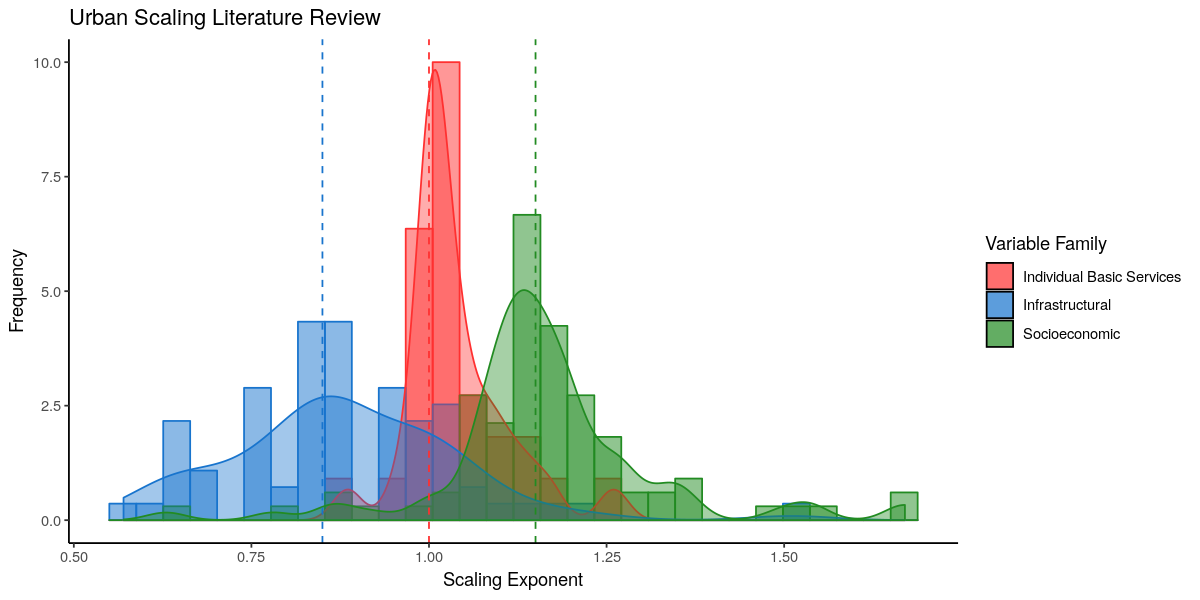

In [8]:
ggplot(scalingreview_noND[scalingreview_noND$scaling_exponent<2,], aes(x=scaling_exponent, color=variable_regime, fill=variable_regime)) +
geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
geom_density(alpha=0.4)+
geom_vline(data=mu, aes(xintercept=grp.expected, color=variable_regime),linetype="dashed")+

theme(legend.position=c(.5, .5))+

#theme(legend.position = c(0.1, 0.7),legend.background = element_rect(fill = "gray95"))+


scale_color_manual(values=c("firebrick1", "dodgerblue3", "forestgreen"),guide = FALSE)+
scale_fill_manual(values=c("firebrick1", "dodgerblue3", "forestgreen"),
                    name = "Variable Family", labels = c("Individual Basic Services", "Infrastructural", "Socioeconomic"))+

labs(title="Urban Scaling Literature Review",x="Scaling Exponent", y = "Frequency")+

theme_classic()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


NULL


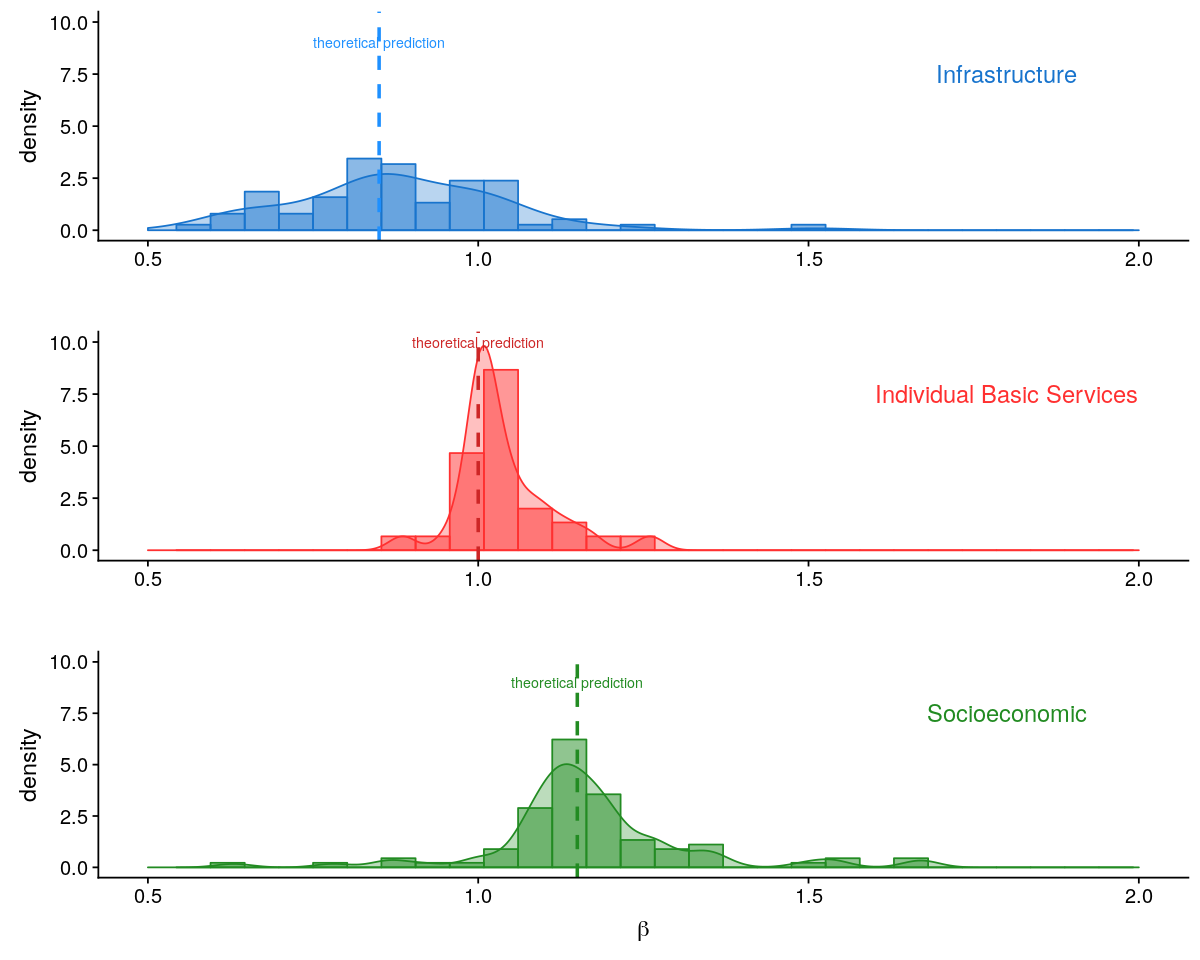

In [9]:
options(repr.plot.width=10, repr.plot.height=8)

sub <- ggplot(scalingreview_noND[scalingreview_noND$variable_regime=='sublinear',], aes(x=scaling_exponent))+
geom_histogram(aes(y=..density..),fill="dodgerblue3",colour="dodgerblue3", position="identity", alpha=0.5)+
geom_density(alpha=0.3,fill="dodgerblue3",colour="dodgerblue3")+
geom_vline(xintercept = 0.85, color="dodgerblue1",linetype="dashed", size=1)+
annotate("text", x = 0.85, y = 9, size=3, label = "theoretical prediction", color="dodgerblue1")+

annotate("text", x = 1.8, y = 7.5, size=5, label = "Infrastructure", color="dodgerblue3")+
theme(legend.position = "none")+xlab('')+
  xlim(0.5, 2)+ylim(0,10)


lin <- ggplot(scalingreview_noND[scalingreview_noND$variable_regime=='linear',], aes(x=scaling_exponent))+
geom_histogram(aes(y=..density..),fill="firebrick1",colour="firebrick1", position="identity", alpha=0.5)+
geom_density(alpha=0.3,fill="firebrick1",colour="firebrick1")+
geom_vline(xintercept = 1, color="firebrick3",linetype="dashed", size=1)+
annotate("text", x = 1, y = 10, size=3, label = "theoretical prediction", color="firebrick3")+
annotate("text", x = 1.8, y = 7.5, size=5, label = "Individual Basic Services", color="firebrick1")+
theme(legend.position = "none")+xlab('')+
xlim(0.5, 2)+ylim(0,10)


super <- ggplot(scalingreview_noND[scalingreview_noND$variable_regime=='superlinear',], aes(x=scaling_exponent))+
geom_histogram(aes(y=..density..),fill="forestgreen",colour="forestgreen", position="identity", alpha=0.5)+
geom_density(alpha=0.3,fill="forestgreen",colour="forestgreen")+
geom_vline(xintercept = 1.15, color="forestgreen",linetype="dashed", size=1)+
annotate("text", x = 1.15, y = 9, size=3, label = "theoretical prediction", color="forestgreen")+
annotate("text", x = 1.8, y = 7.5, size=5, label = "Socioeconomic", color="forestgreen")+
theme(legend.position = "none")+xlab(expression(beta))+
xlim(0.5, 2)+ylim(0,10)


suppressWarnings(print(multiplot(sub, lin, super, cols=1)))

### Variable Family

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


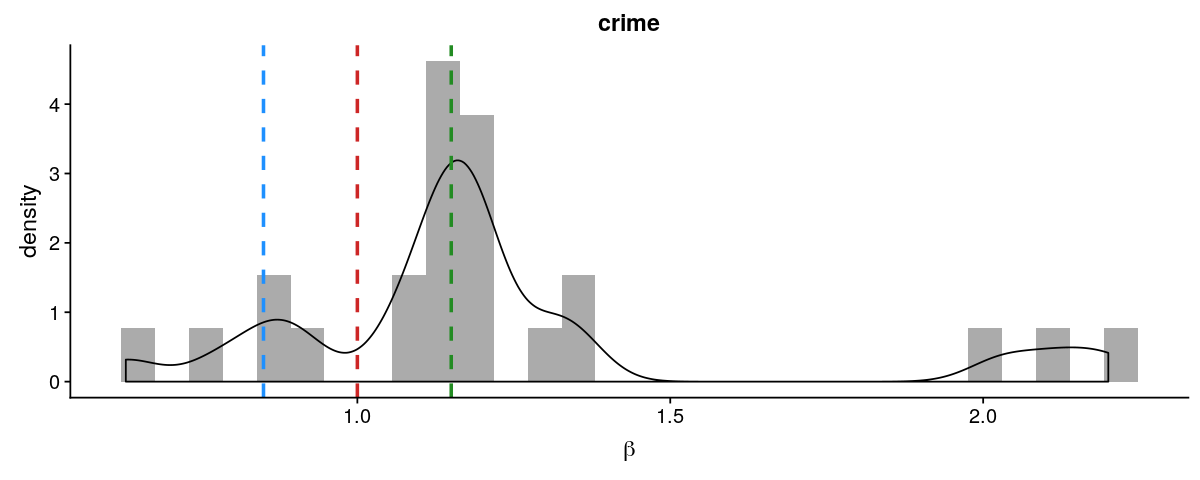

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


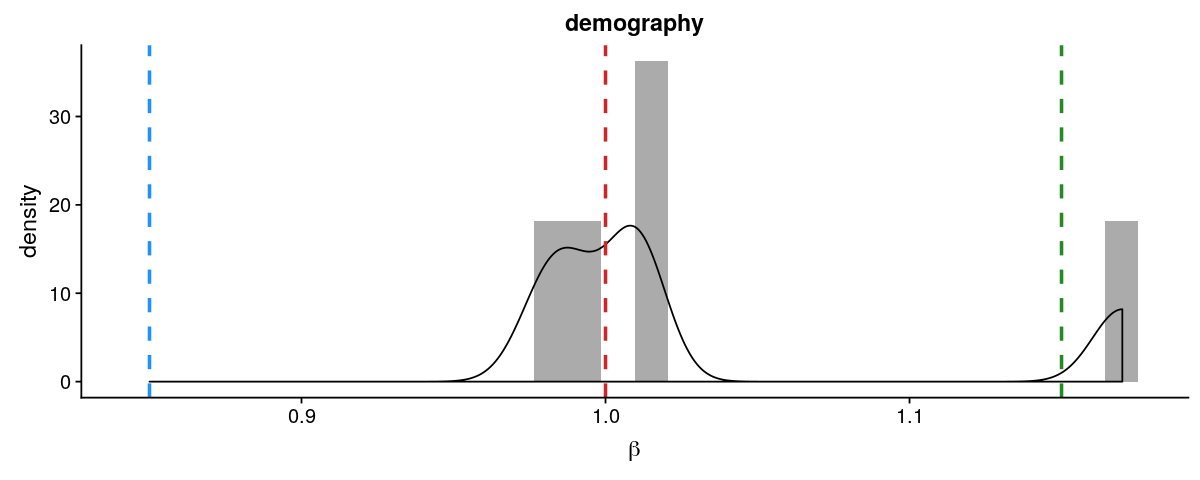

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


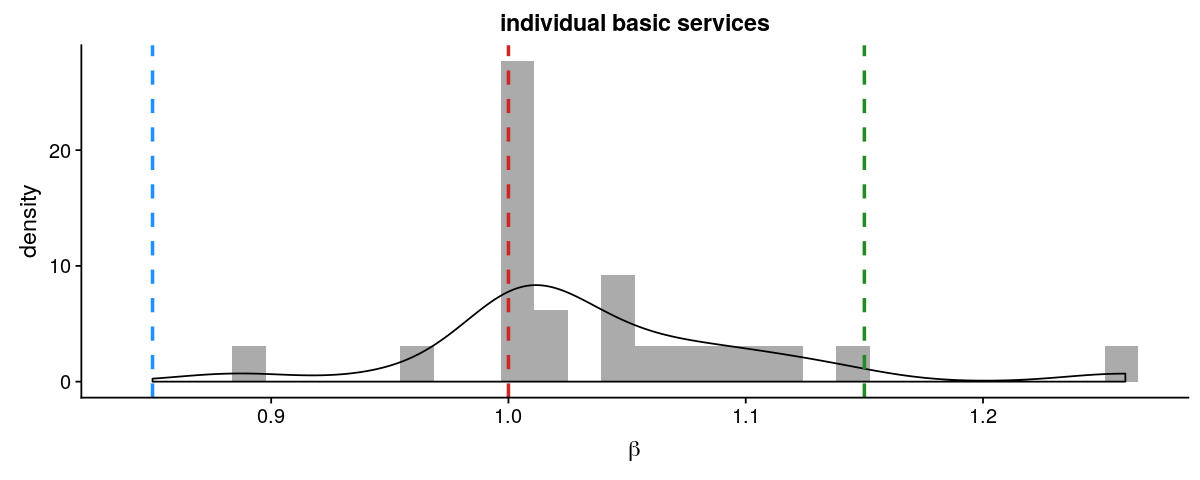

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Groups with fewer than two data points have been dropped.”

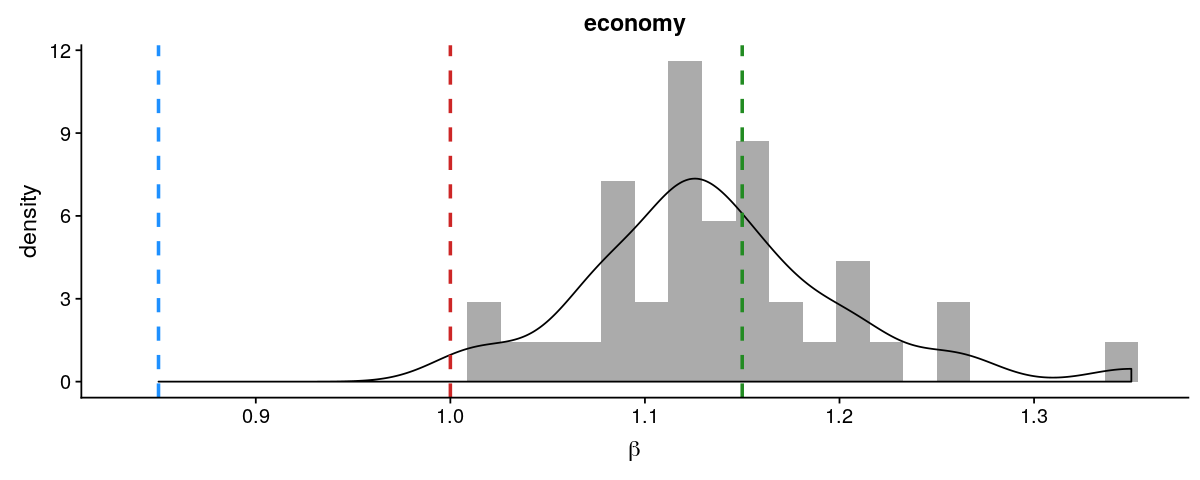

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


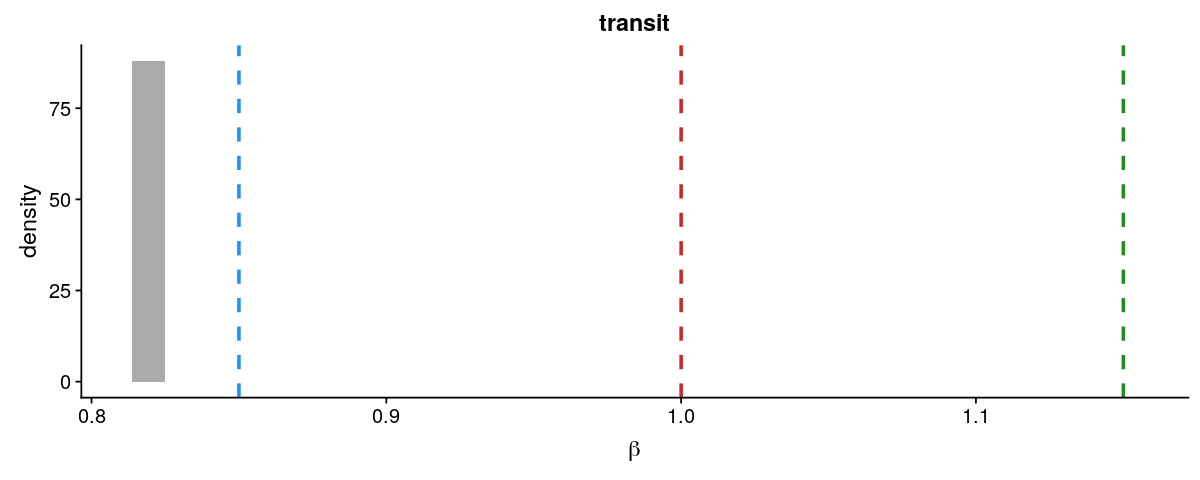

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


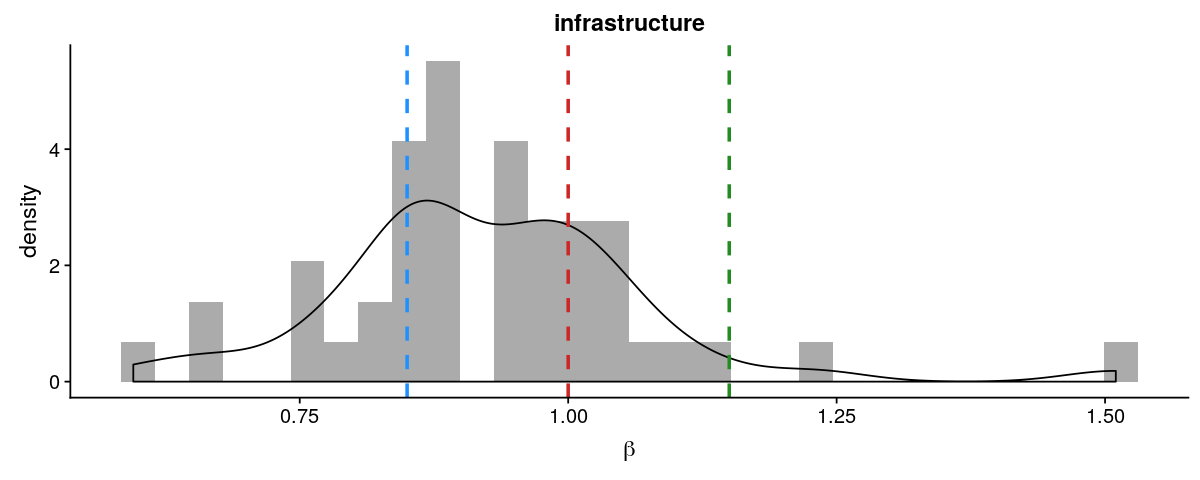

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


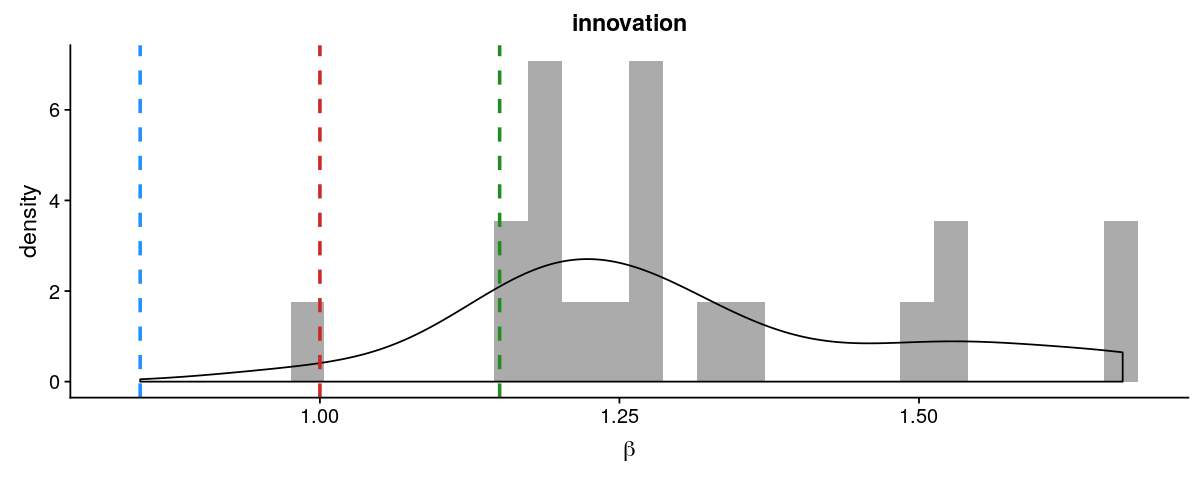

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


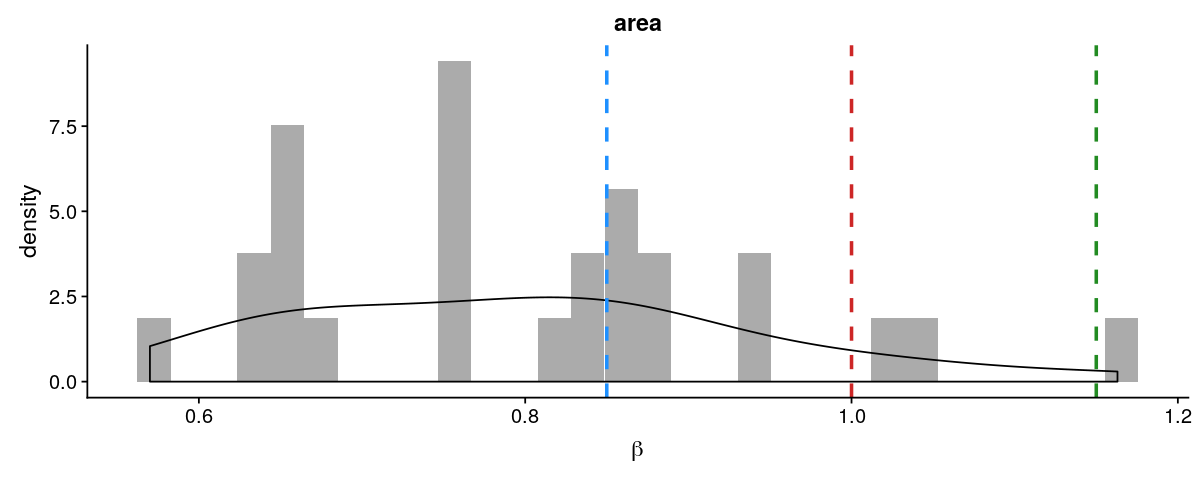

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


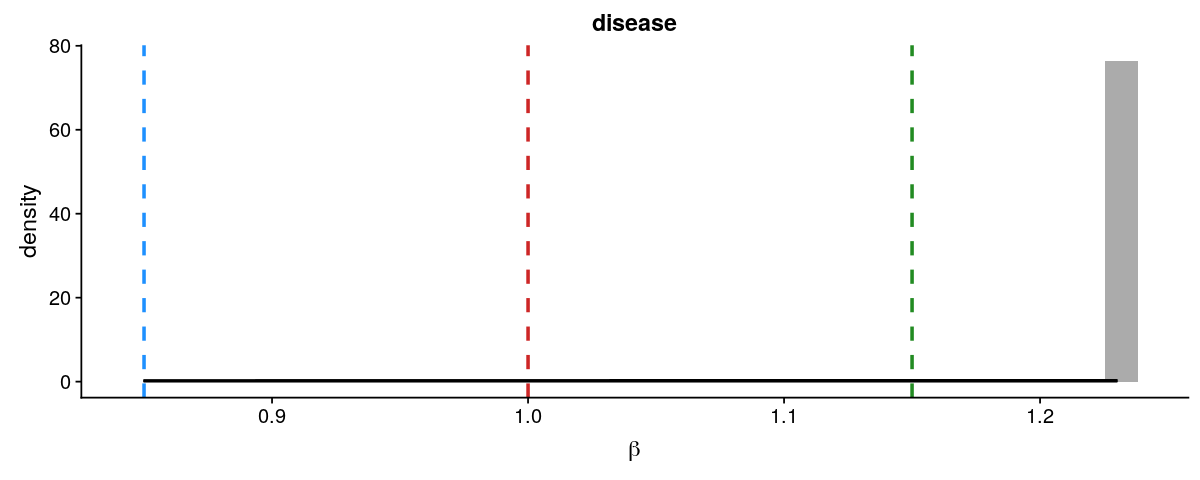

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


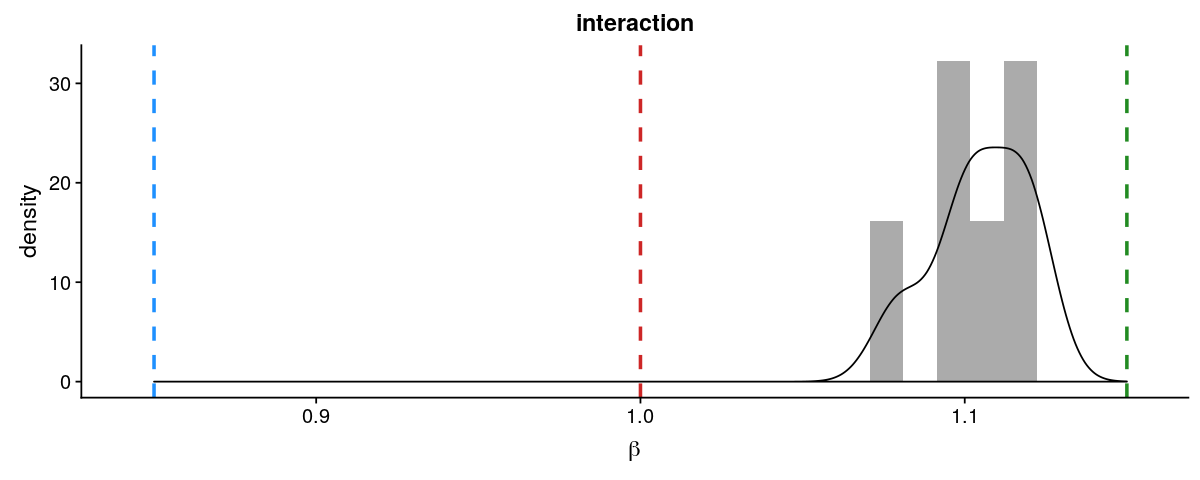

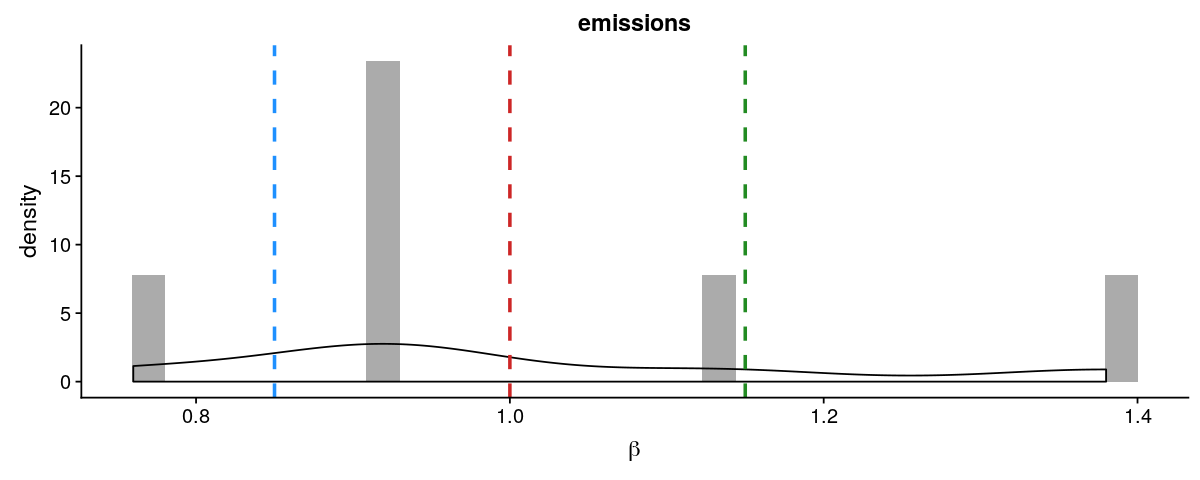

In [47]:
options(repr.plot.width=10, repr.plot.height=4)

for (f in unique(scalingreview$variable_familly)){

p <- ggplot(scalingreview[scalingreview$variable_familly==f,], aes(x=scaling_exponent))+
geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
geom_density(alpha=0.3)+

geom_vline(xintercept = 1.15, color="forestgreen",linetype="dashed", size=1)+
geom_vline(xintercept = 1, color="firebrick3",linetype="dashed", size=1)+
geom_vline(xintercept = 0.85, color="dodgerblue1",linetype="dashed", size=1)+

#    annotate("text", x = 1.15, y = 9, size=3, label = "theoretical prediction", color="forestgreen")+
#annotate("text", x = 1.2, y = 7.5, size=5, label = f)+
ggtitle(f)+
theme(legend.position = "none")+xlab(expression(beta))#+
#xlim(0.5, 2)+ylim(0,10)
    
print(p)

}

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Groups with fewer than two data points have been dropped.”Warning message:
“Groups with fewer than two data points have been dropped.”

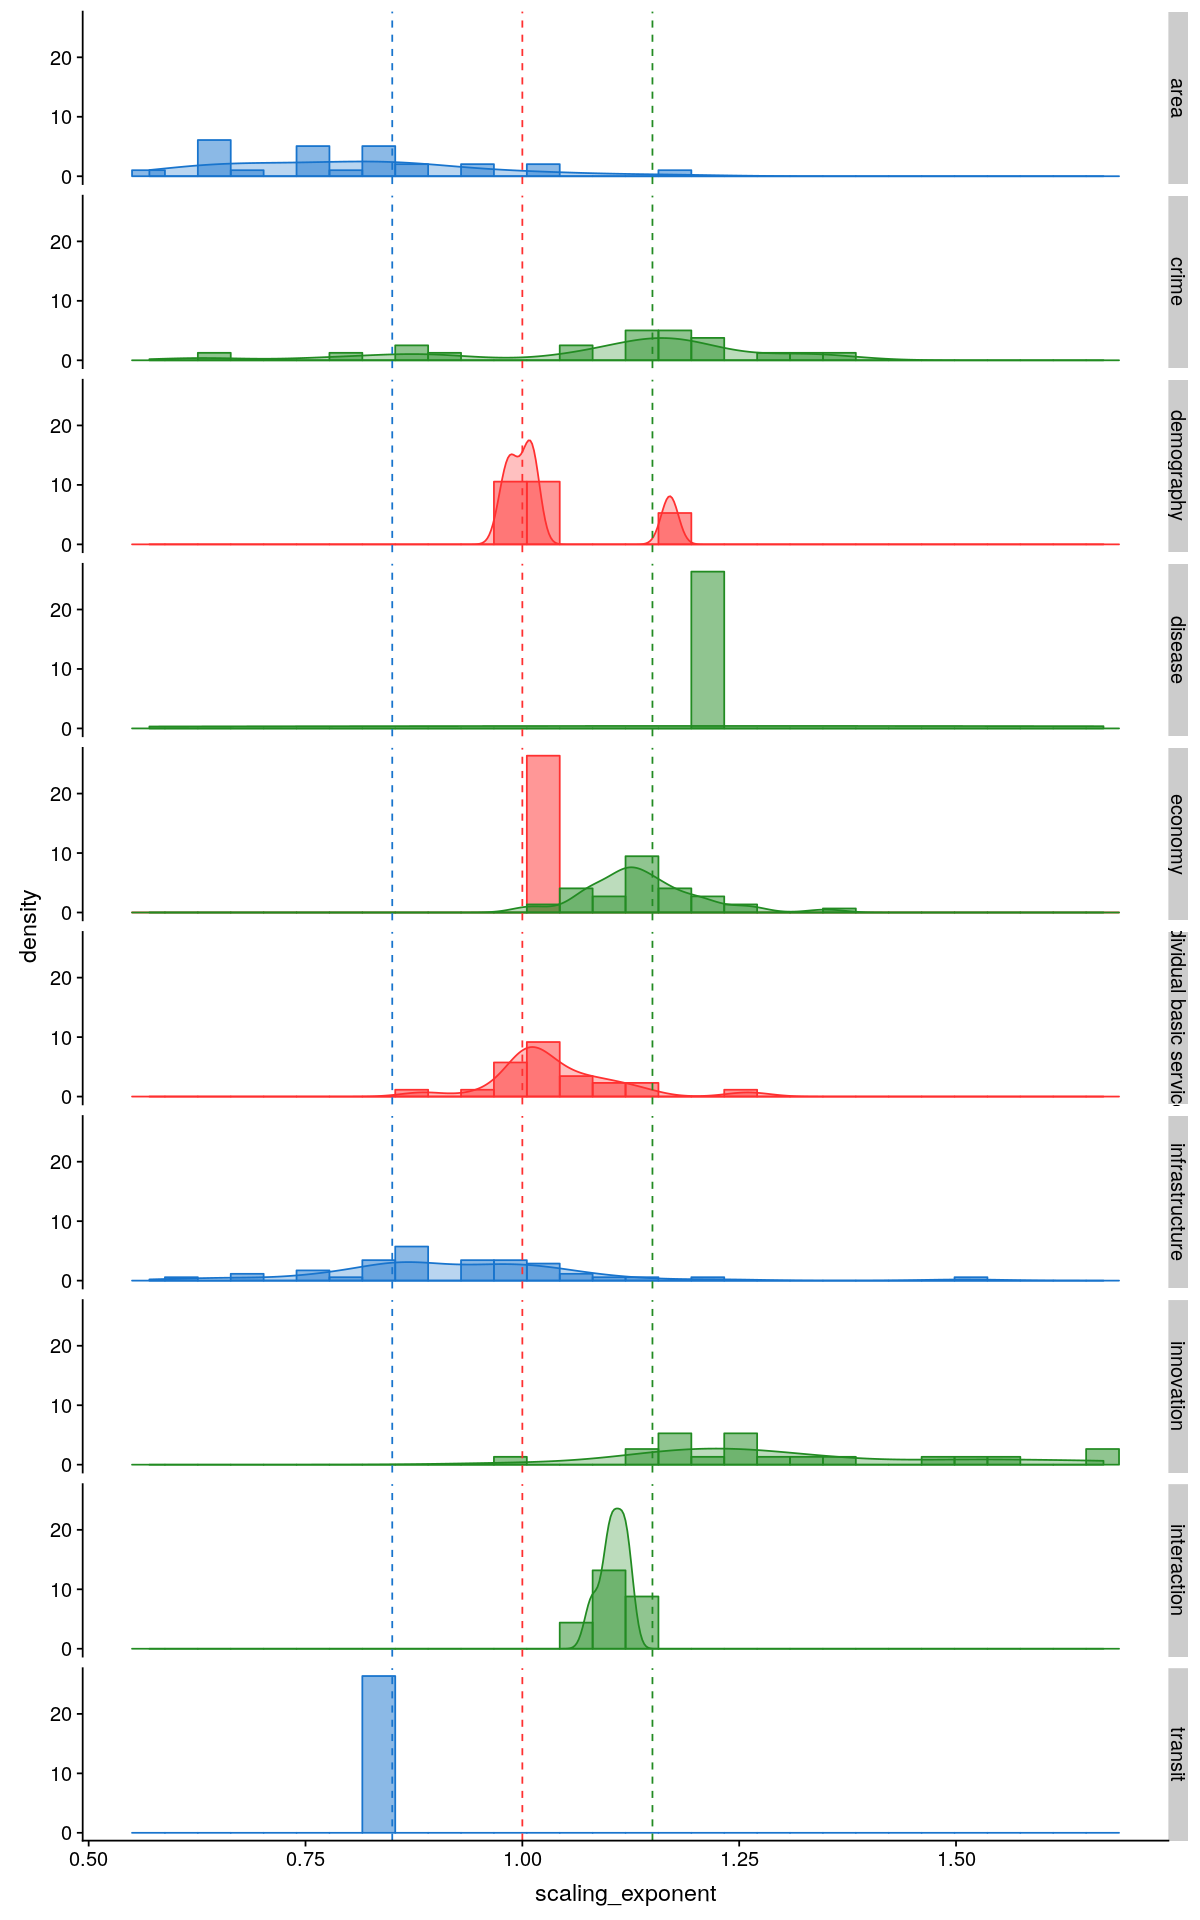

In [30]:
options(repr.plot.width=10, repr.plot.height=16)

p <- ggplot(scalingreview_noND[scalingreview_noND$scaling_exponent<2,], aes(x=scaling_exponent, color=variable_regime, fill=variable_regime)) +
geom_histogram(aes(y=..density..), position="identity", alpha=0.5)+
geom_density(alpha=0.3)+
geom_vline(data=mu, aes(xintercept=grp.expected, color=variable_regime),
           linetype="dashed")+
scale_color_manual(values=c("firebrick1", "dodgerblue3", "forestgreen"))+
scale_fill_manual(values=c("firebrick1", "dodgerblue3", "forestgreen"))+
theme(legend.position = "none")

# Use vars() to supply variables from the dataset:
p + facet_grid(rows = vars(variable_familly))

Warning message:
“Groups with fewer than two data points have been dropped.”

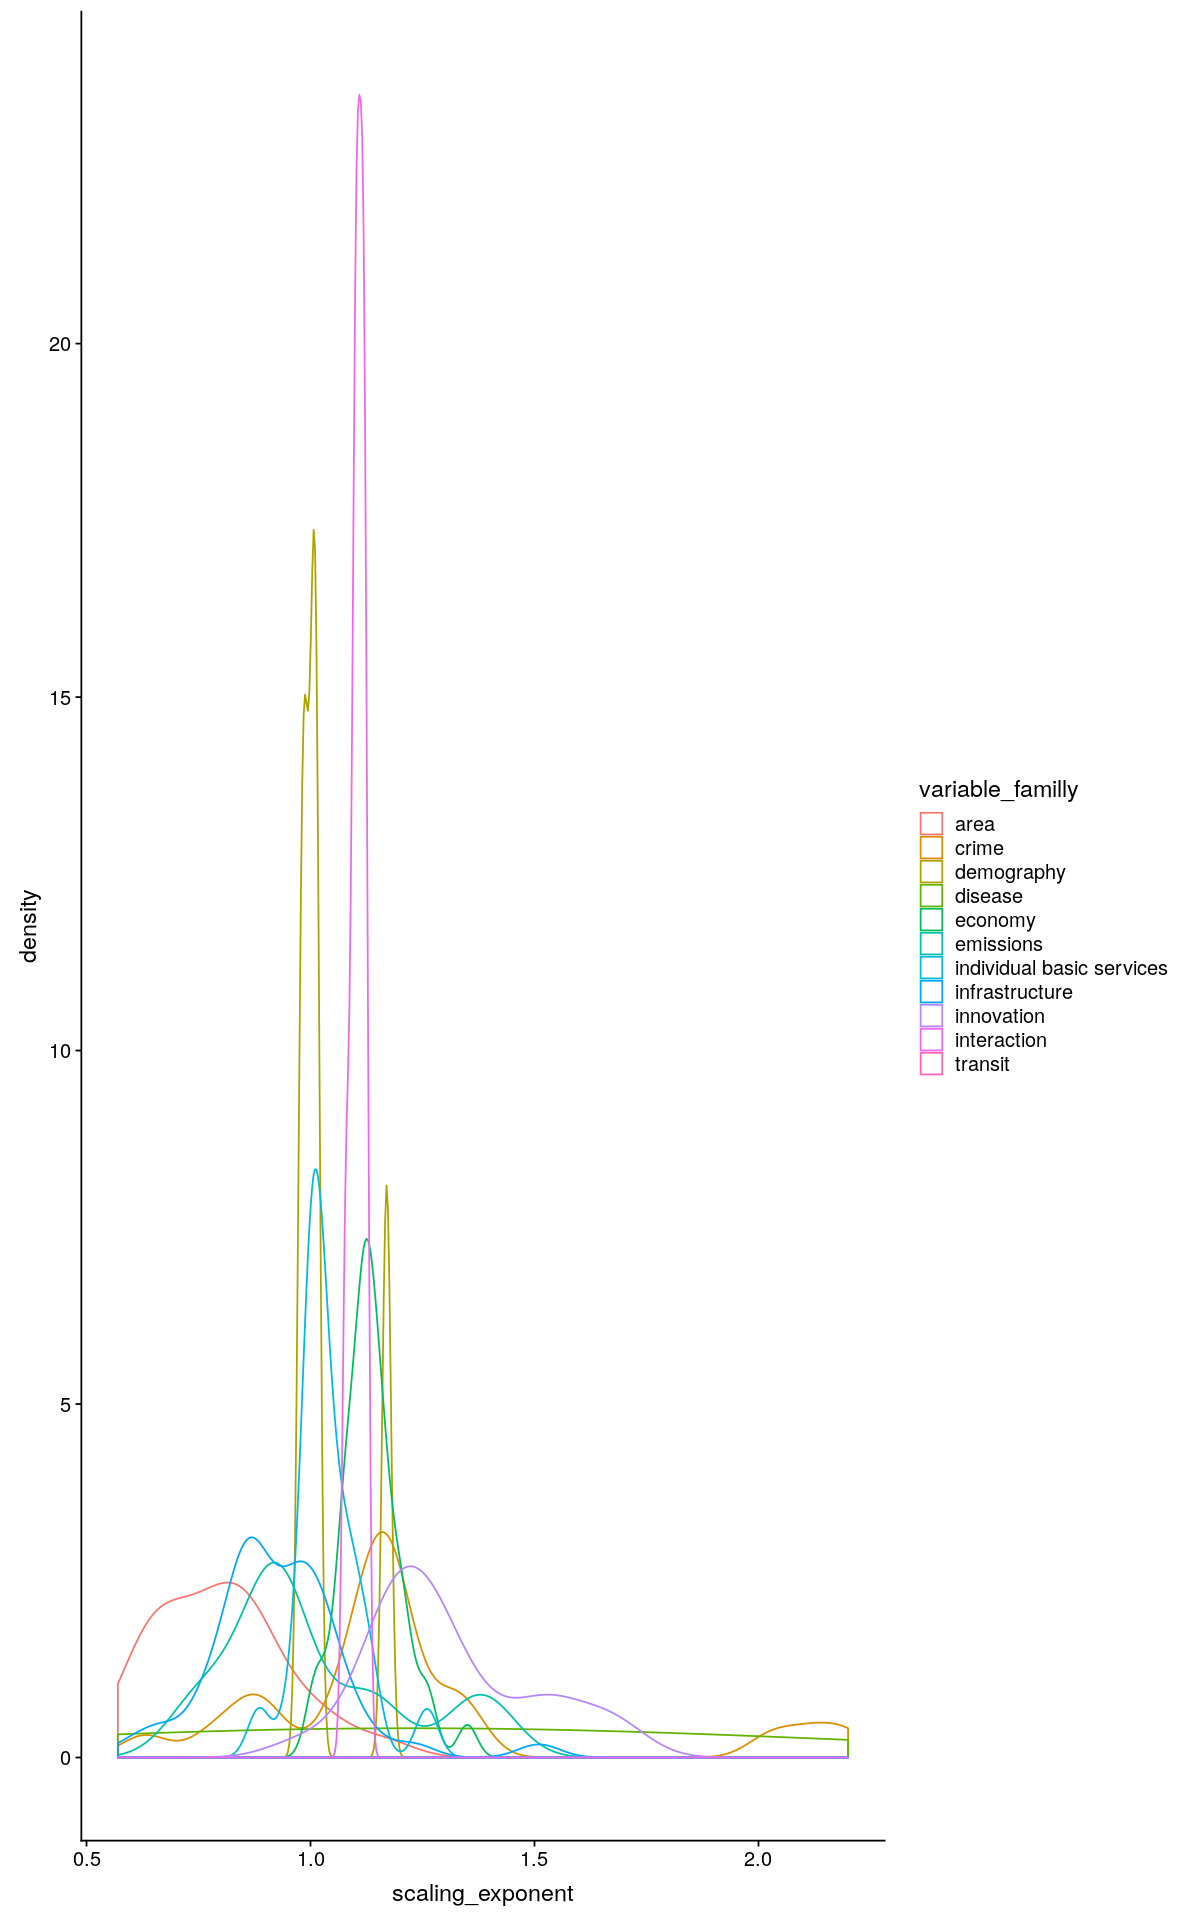

In [31]:
ggplot(scalingreview, aes(x=scaling_exponent, color=variable_familly)) +
  geom_density()

## Correlation with other variables


### Merge countries
West Africa -> Sub-Saharan Africa

UK / GB / England and Wales -> United Kingdom

U.S. / USA - > United States

In [133]:
#prepare scaling data
s <- c('urban_system_merge','publication_reference' ,'data_year','publication_year_clean','n','variable','variable_familly',
       'variable_regime','scaling_exponent')

scalingreview_noND_join <- scalingreview_noND[, s]


#READ WB DATA
wb <- read.csv(file="bee276e3-6e91-408d-a930-548ed1e03535_Data.csv", header=TRUE, sep=",")

#prepare wb data
wb_merge <- spread(wb[wb$Country.Name	 %in% unique(scalingreview_noND$urban_system_merge),c(1,3,8)], Series.Name, X2010..YR2010.)


#merge
join <- merge(scalingreview_noND_join, wb_merge, by.x="urban_system_merge", by.y="Country.Name")

#fix names
colnames(join) <- make.names(colnames(join), unique = TRUE)

head(join)

urban_system_merge publication_reference data_year publication_year_clean n 
1 Brazil             Alves 2013            2000      2013                   49
2 Brazil             Meirelles 2018        2010      2018                   88
3 Brazil             Meirelles 2018        2010      2018                   88
4 Brazil             Meirelles 2018        2010      2018                   88
5 Brazil             Meirelles 2018        2010      2018                   88
6 Brazil             Alves 2013            2000      2013                   49
  variable                                          variable_familly         
1 GDP                                               economy                  
2 Number Of Inhabitants Served By Waste Collection  individual basic services
3 Number Of Inhabitants Connected To Sewage Network individual basic services
4 Number Of Inhabitants With Access To Electricity  individual basic services
5 Number Of Literate Inhabitants                    individual basic services
6 Female population                                 demography               
  variable_regime scaling_exponent
1 superlinear     1.21            
2 linear          1.12            
3 linear          1.14            
4 linear          1.26            
5 linear          1.06            
6 linear          1.01            
  Adolescent.fertility.rate..births.per.1.000.women.ages.15.19. ⋯
1 67                                                            ⋯
2 67                                                            ⋯
3 67                                                            ⋯
4 67                                                            ⋯
5 67                                                            ⋯
6 67                                                            ⋯
  School.enrollment..primary....gross.
1 132.5                               
2 132.5                               
3 132.5                               
4 132.5                               
5 132.5                               
6 132.5                               
  School.enrollment..primary.and.secondary..gross...gender.parity.index..GPI.
1 NA                                                                         
2 NA                                                                         
3 NA                                                                         
4 NA                                                                         
5 NA                                                                         
6 NA                                                                         
  School.enrollment..secondary....gross.
1 NA                                    
2 NA                                    
3 NA                                    
4 NA                                    
5 NA                                    
6 NA                                    
  Statistical.Capacity.score..Overall.average. Surface.area..sq..km.
1 83                                           8515.8               
2 83                                           8515.8               
3 83                                           8515.8               
4 83                                           8515.8               
5 83                                           8515.8               
6 83                                           8515.8               
  Tax.revenue....of.GDP.
1 13.6                  
2 13.6                  
3 13.6                  
4 13.6                  
5 13.6                  
6 13.6                  
  Terrestrial.and.marine.protected.areas....of.total.territorial.area.
1 NA                                                                  
2 NA                                                                  
3 NA                                                                  
4 NA                                                                  
5 NA                                                                  
6 NA  

In [153]:
colnames(join)[67]

[1] NA

[1] 1 3 5 7 9

[1] "Adolescent.fertility.rate..births.per.1.000.women.ages.15.19."


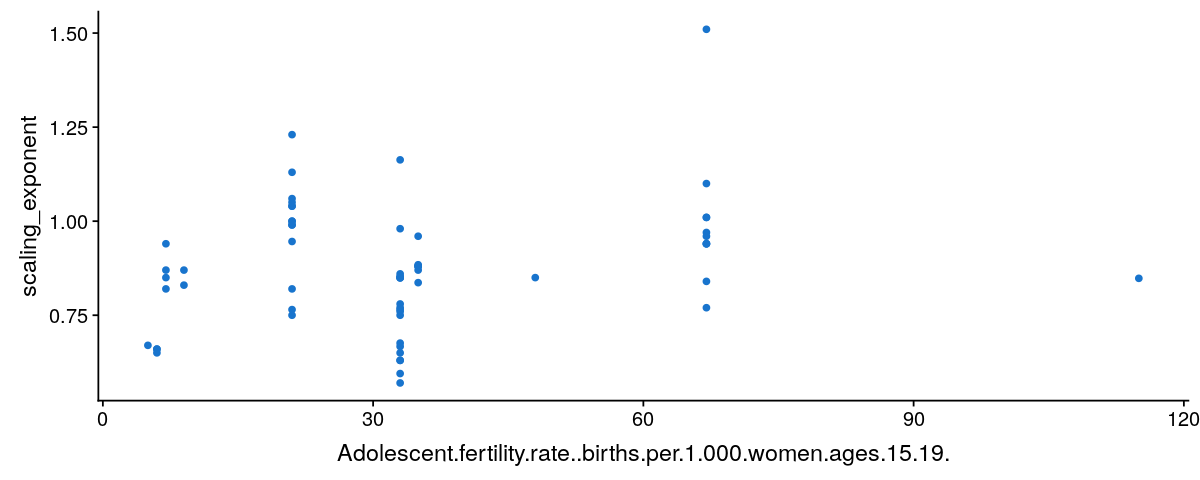

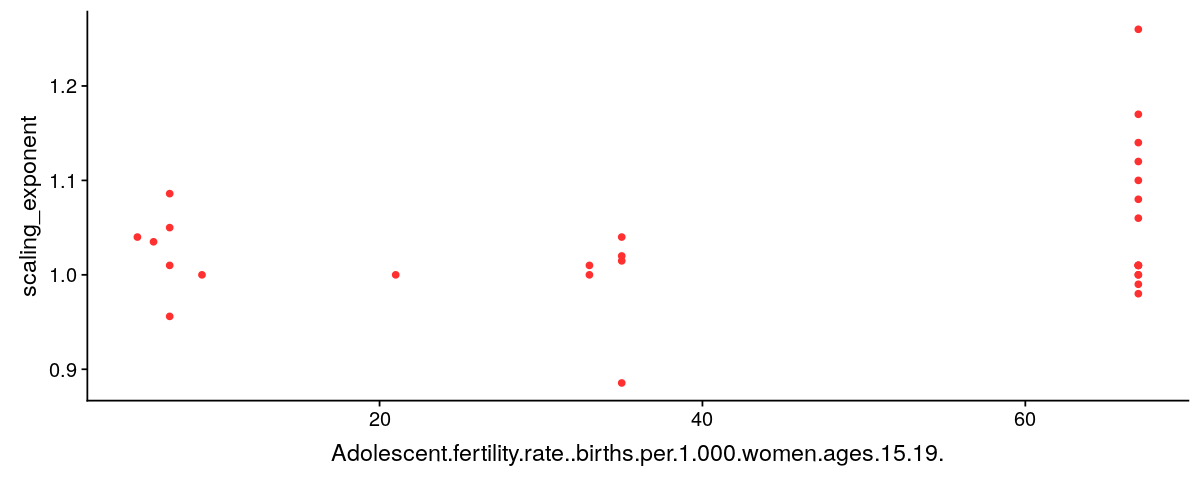

[1] "Agriculture..forestry..and.fishing..value.added....of.GDP."


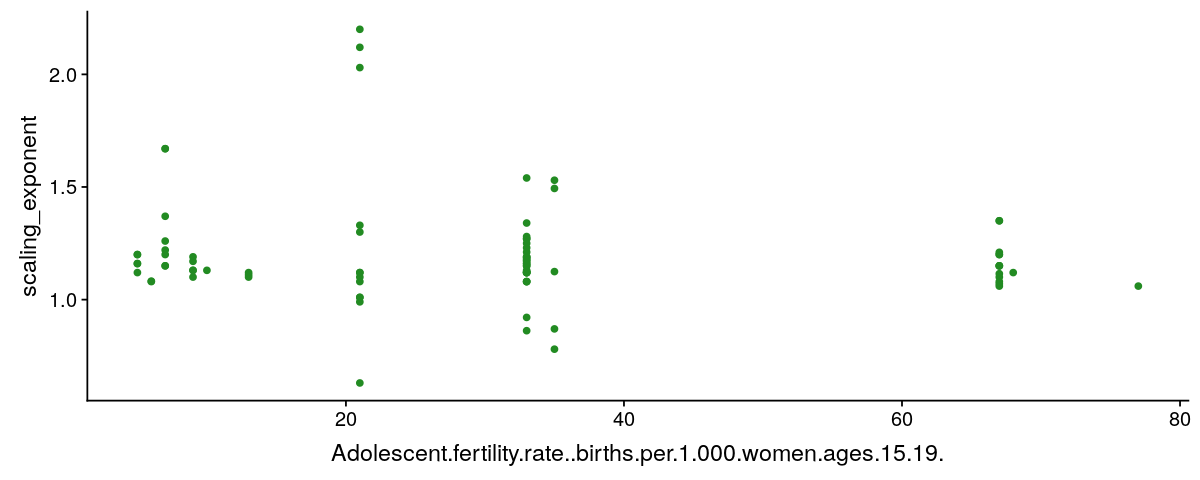

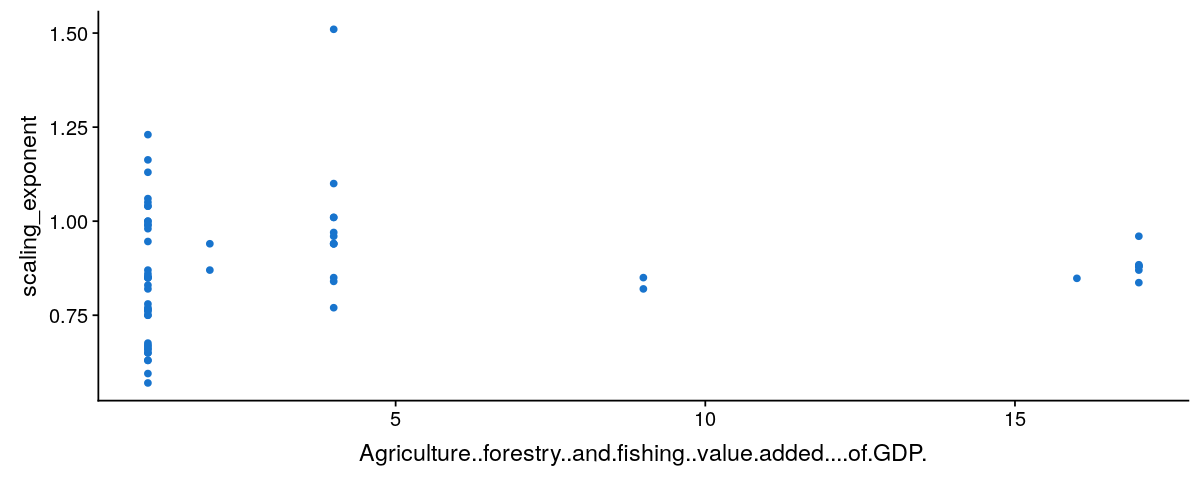

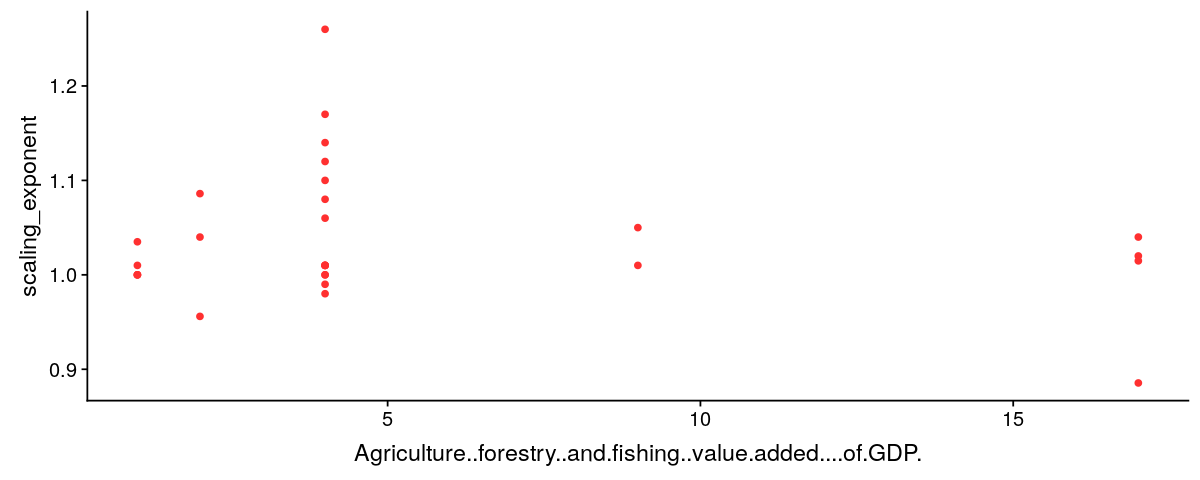

[1] "Annual.freshwater.withdrawals..total....of.internal.resources."


Warning message:
“Removed 2 rows containing missing values (geom_point).”

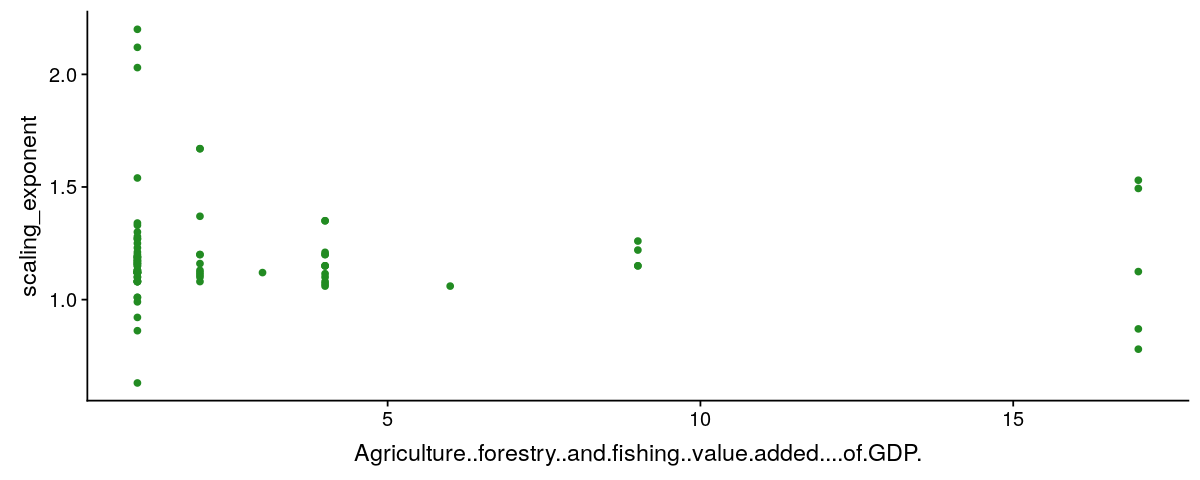

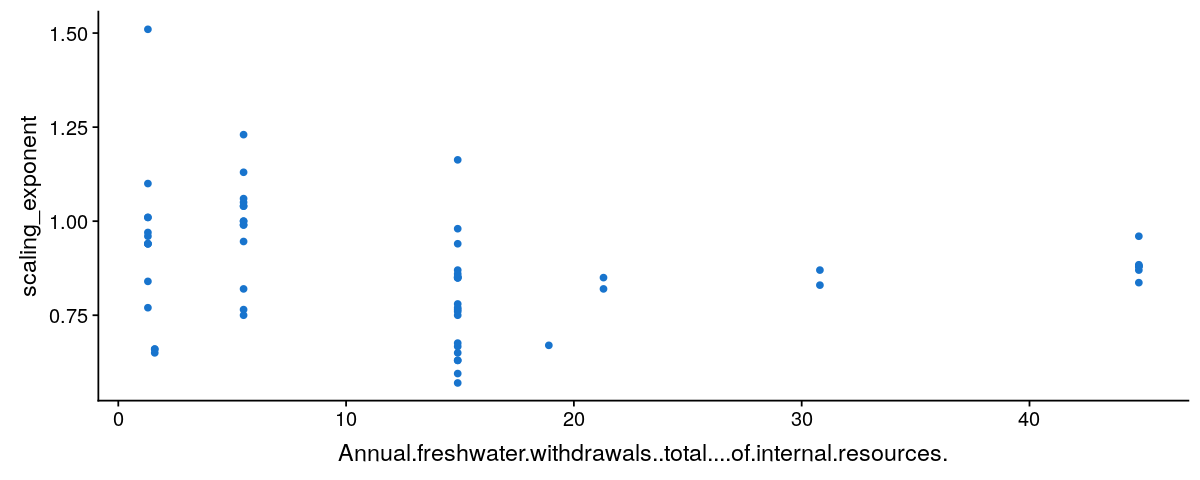

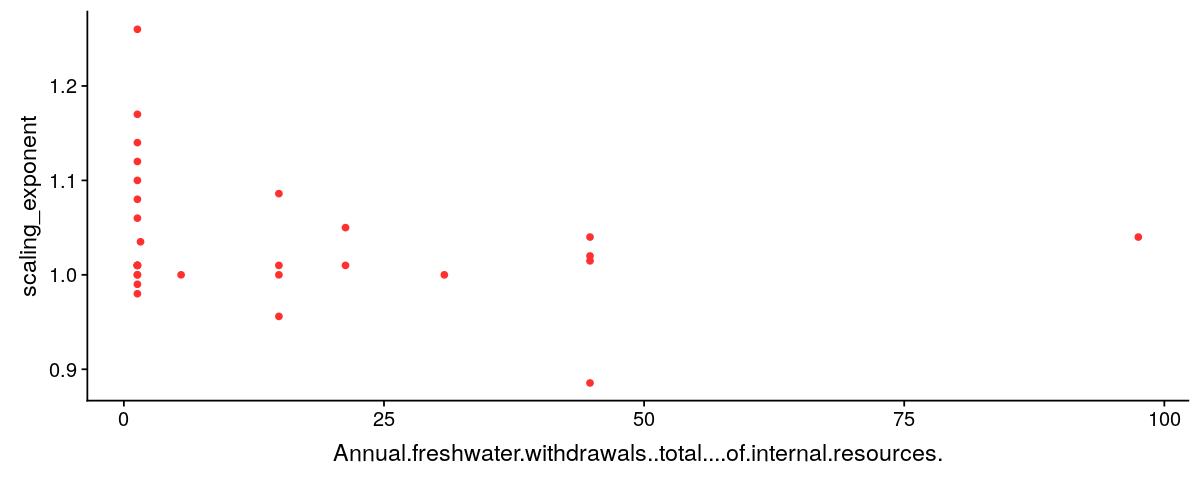

[1] "Births.attended.by.skilled.health.staff....of.total."


Warning message:
“Removed 26 rows containing missing values (geom_point).”

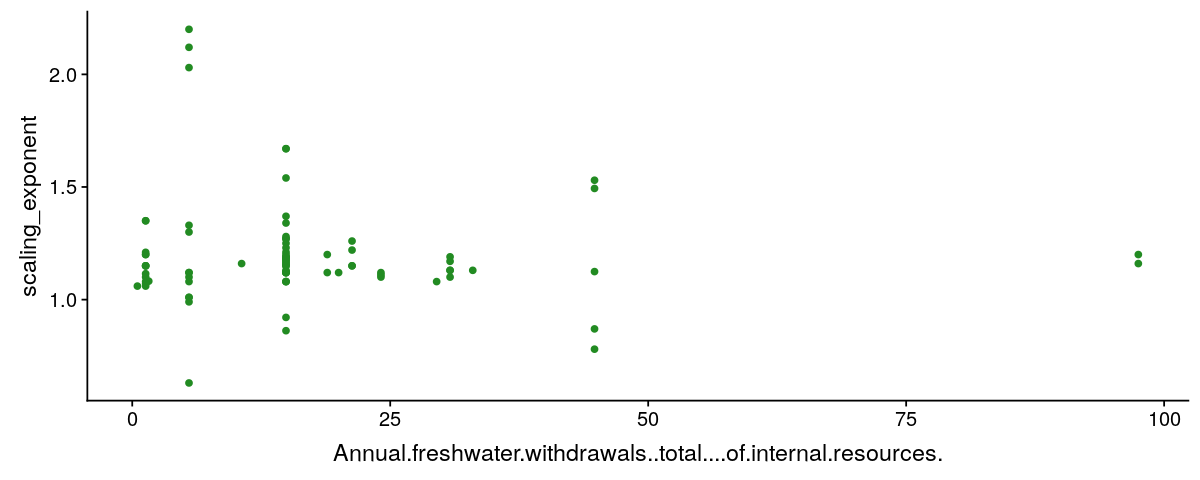

Warning message:
“Removed 7 rows containing missing values (geom_point).”

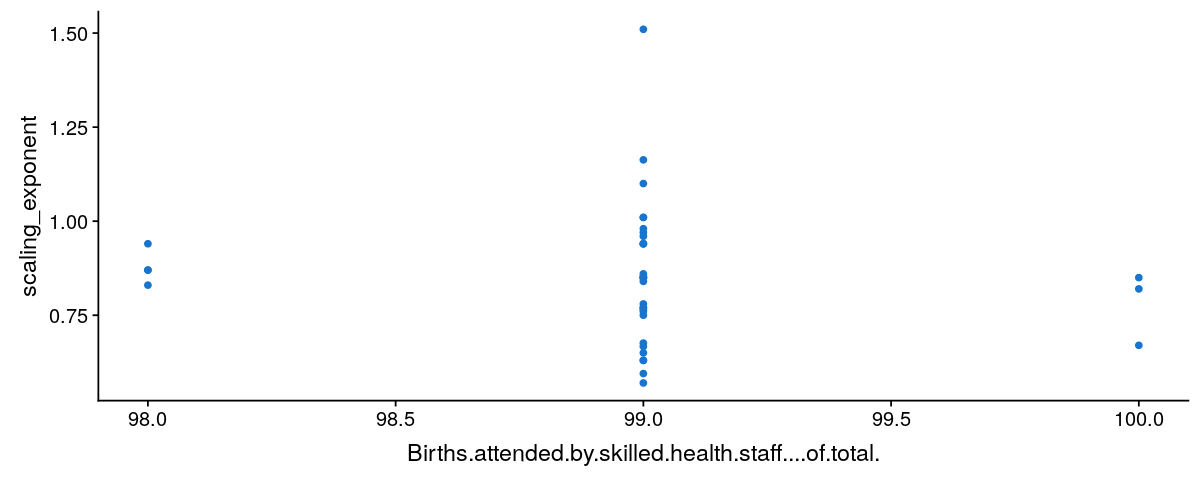

Warning message:
“Removed 25 rows containing missing values (geom_point).”

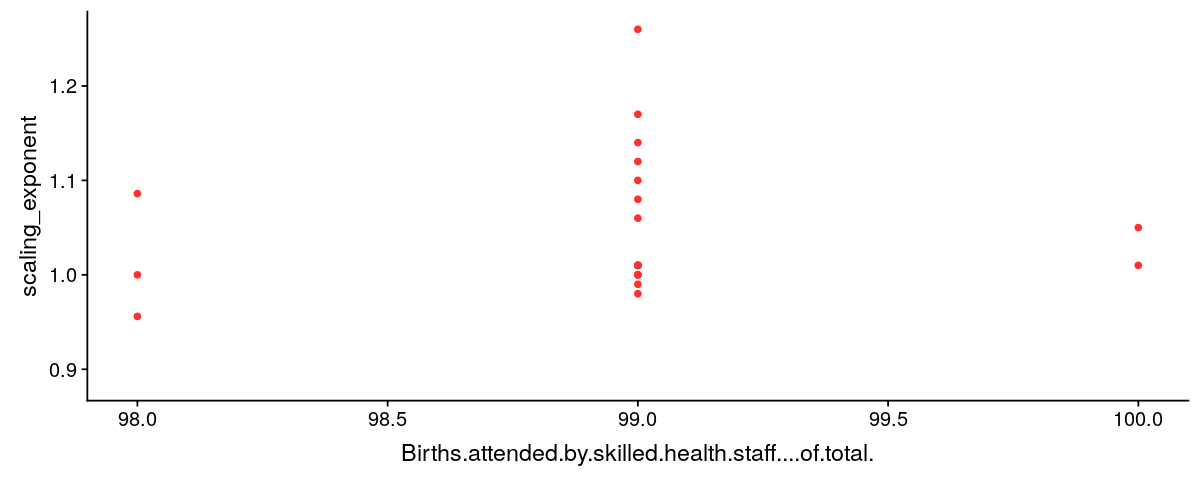

[1] "CO2.emissions..metric.tons.per.capita."


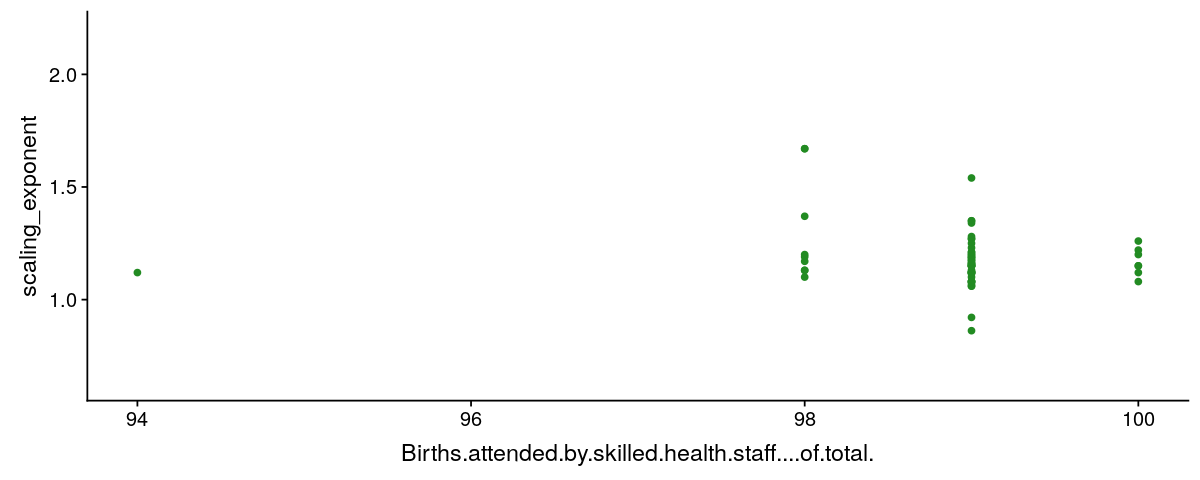

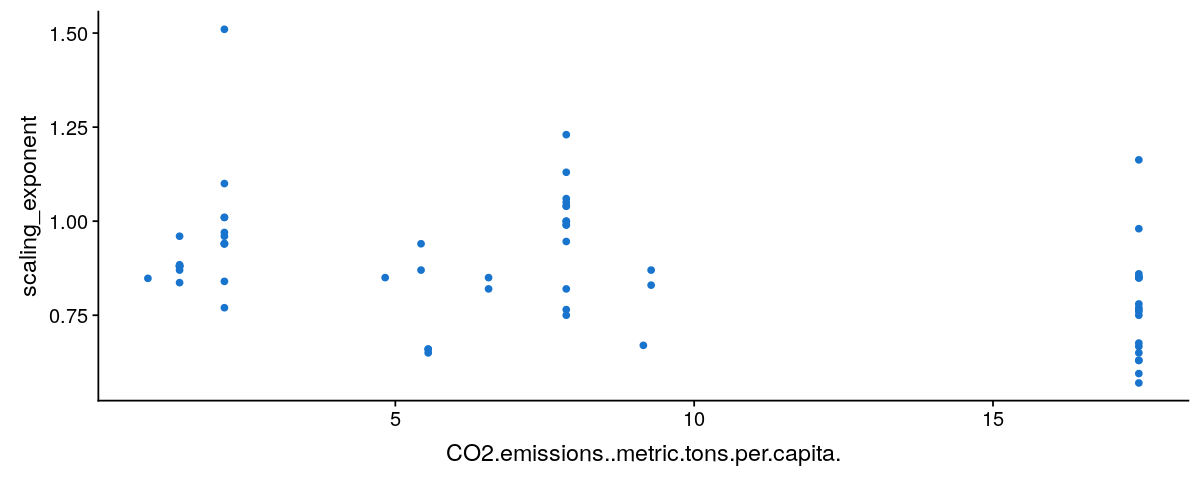

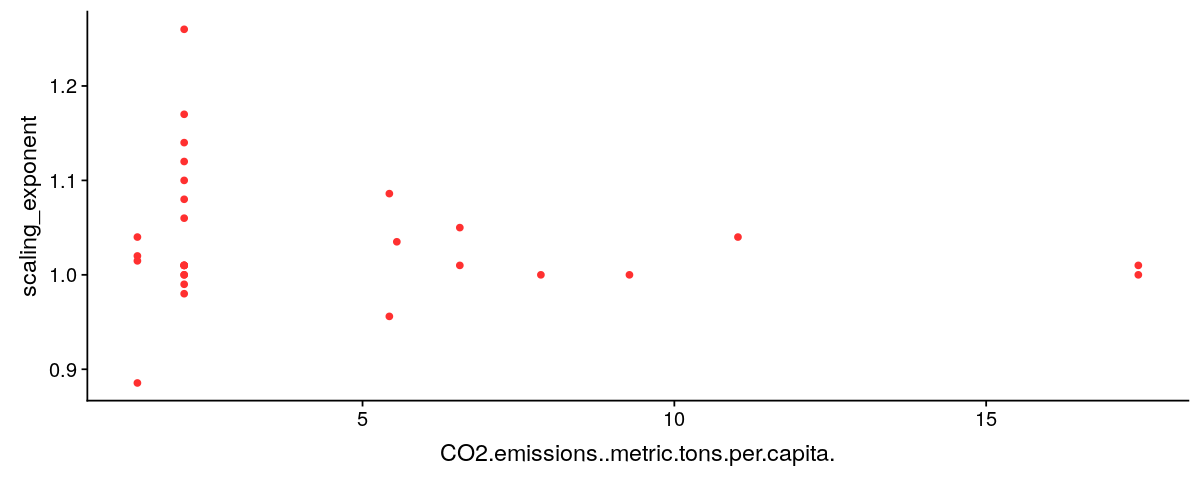

[1] "Contraceptive.prevalence..any.methods....of.women.ages.15.49."


Warning message:
“Removed 40 rows containing missing values (geom_point).”

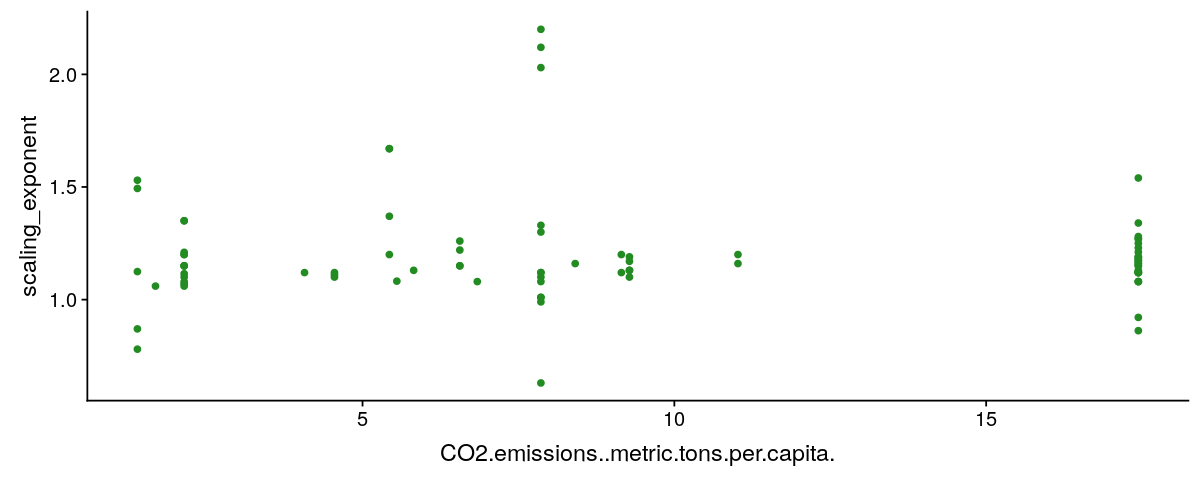

Warning message:
“Removed 23 rows containing missing values (geom_point).”

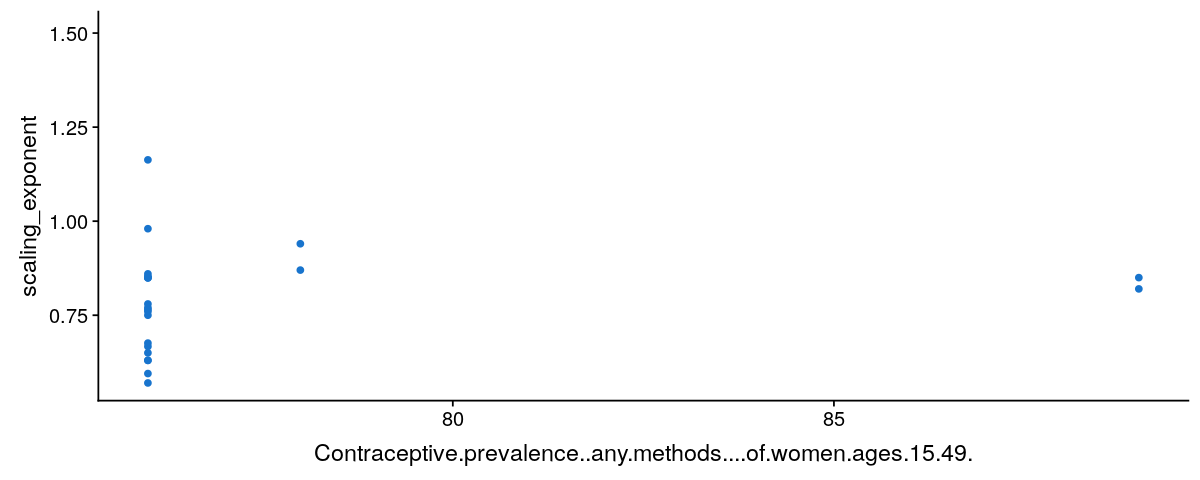

Warning message:
“Removed 48 rows containing missing values (geom_point).”

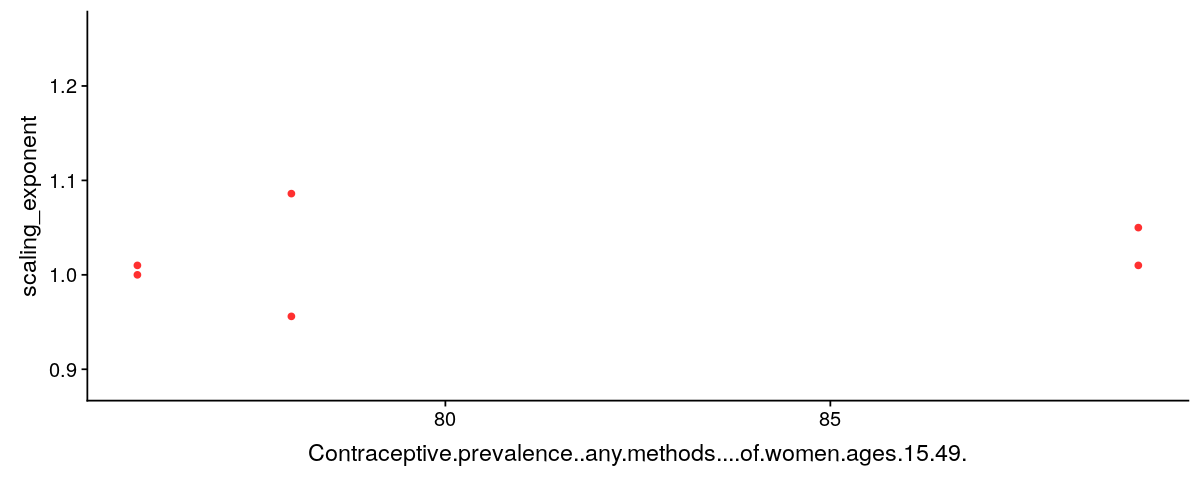

[1] "Domestic.credit.provided.by.financial.sector....of.GDP."


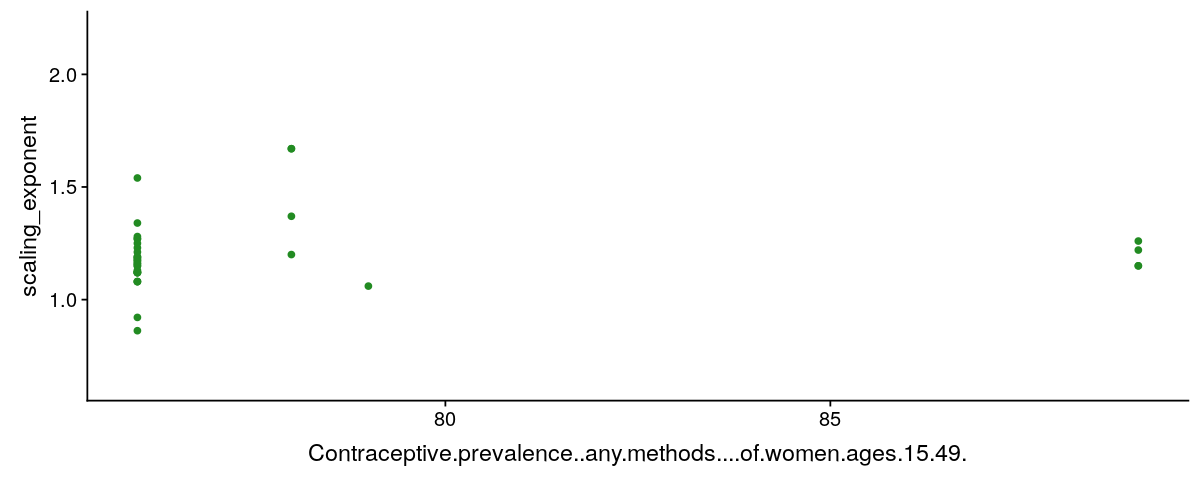

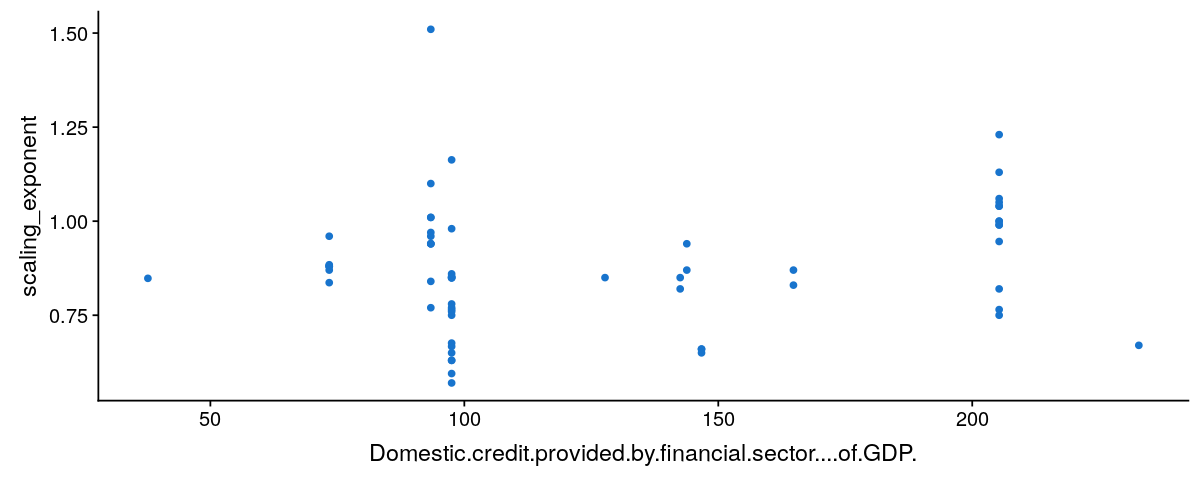

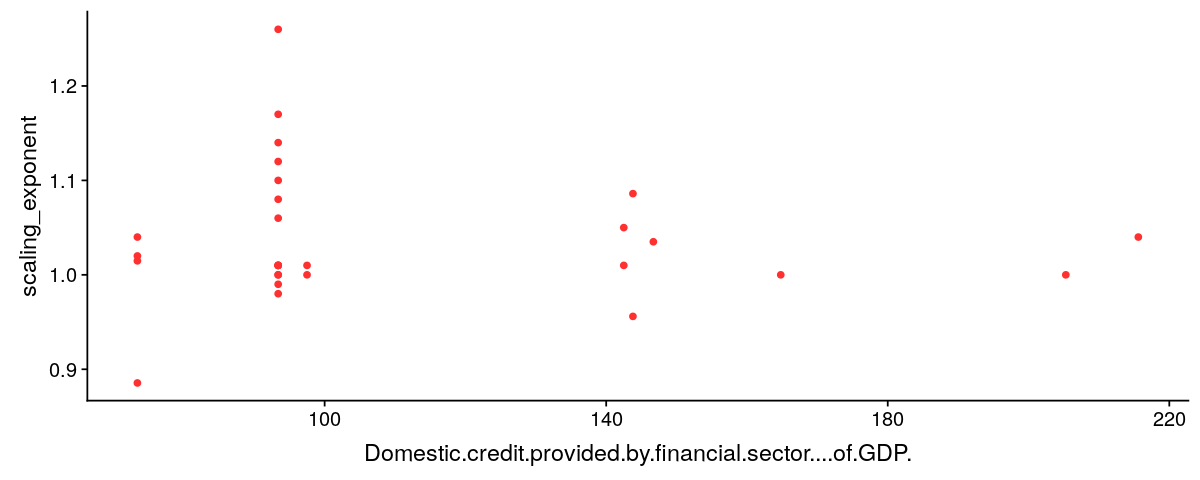

[1] "Electric.power.consumption..kWh.per.capita."


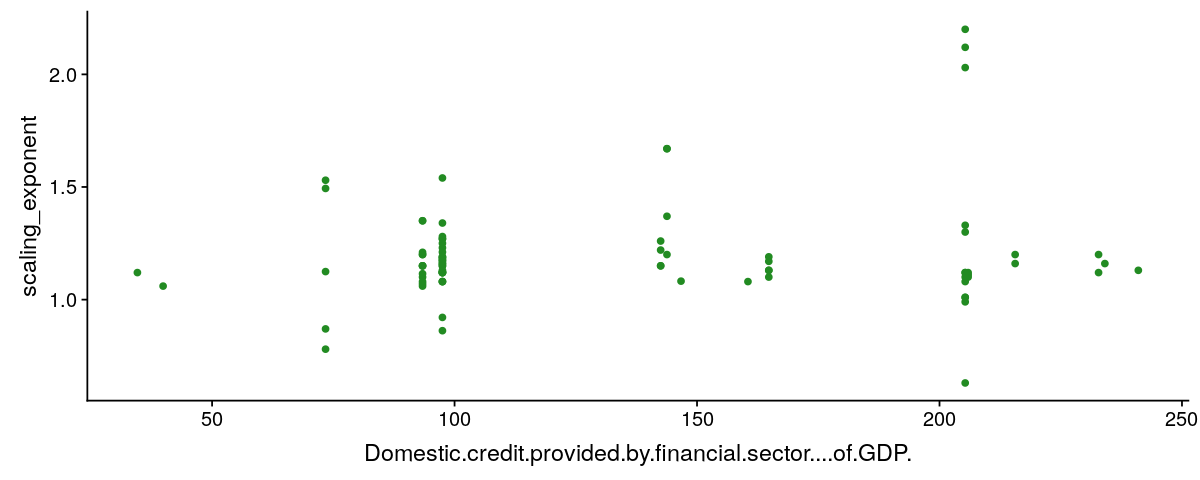

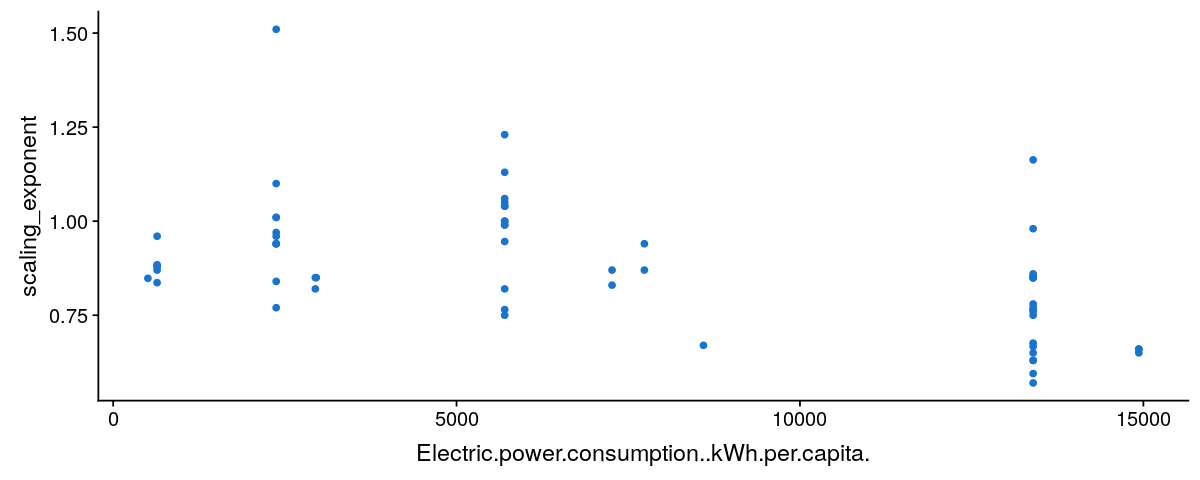

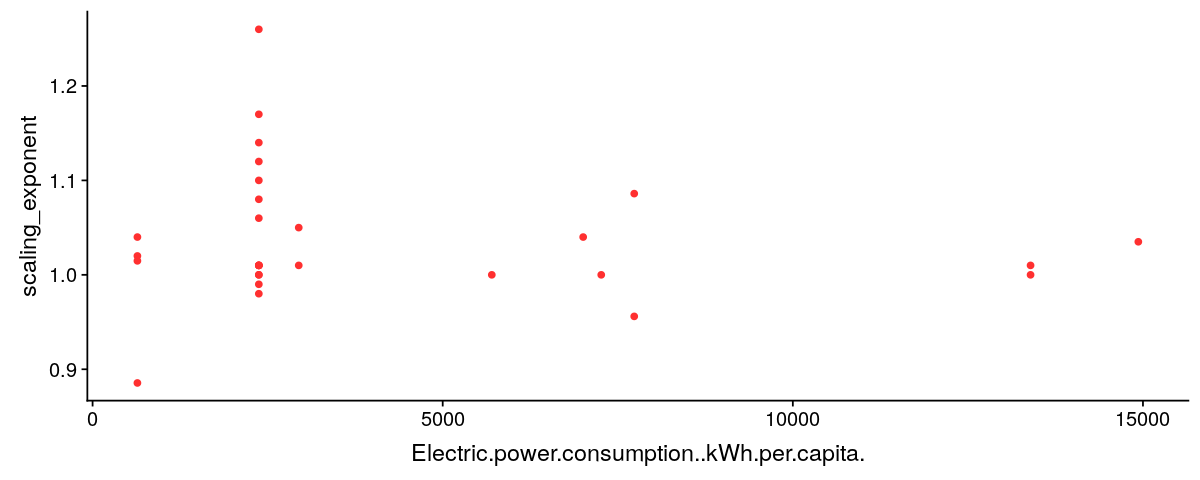

[1] "Energy.use..kg.of.oil.equivalent.per.capita."


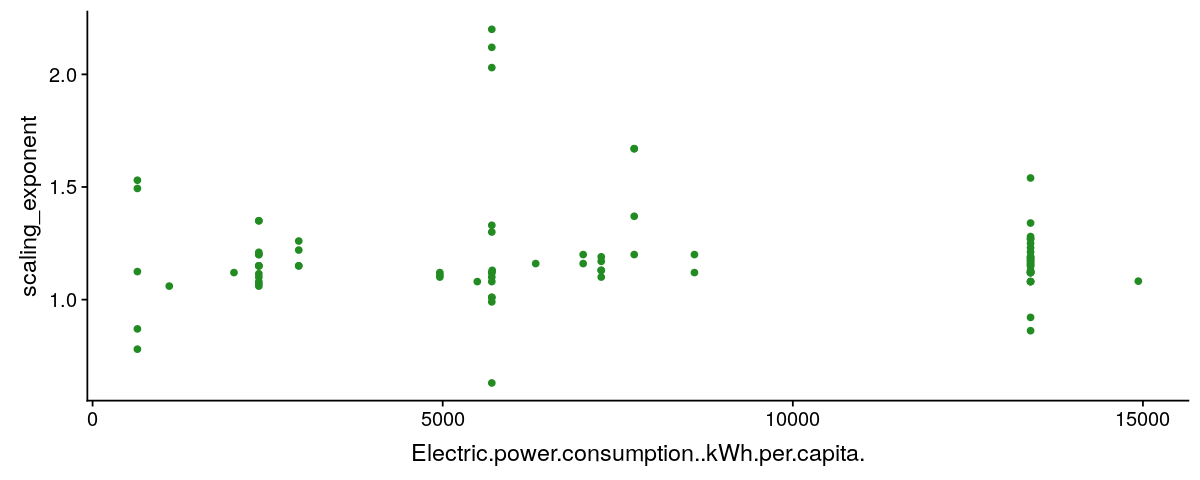

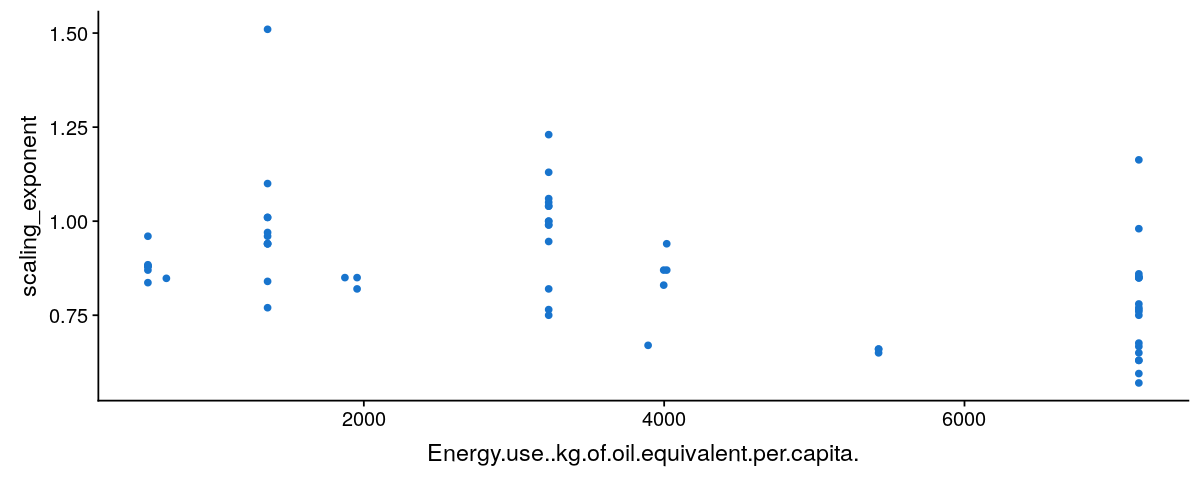

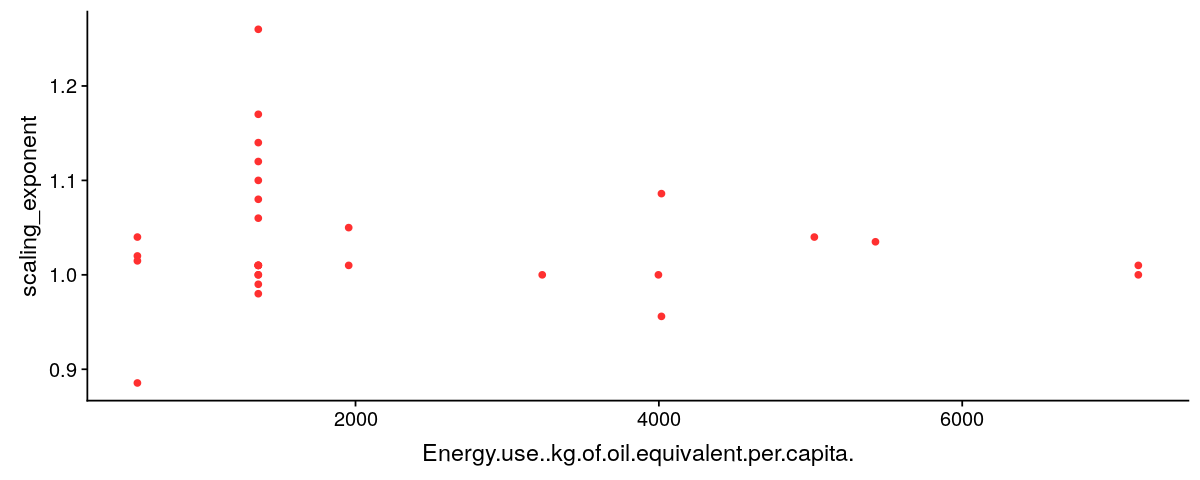

[1] "Exports.of.goods.and.services....of.GDP."


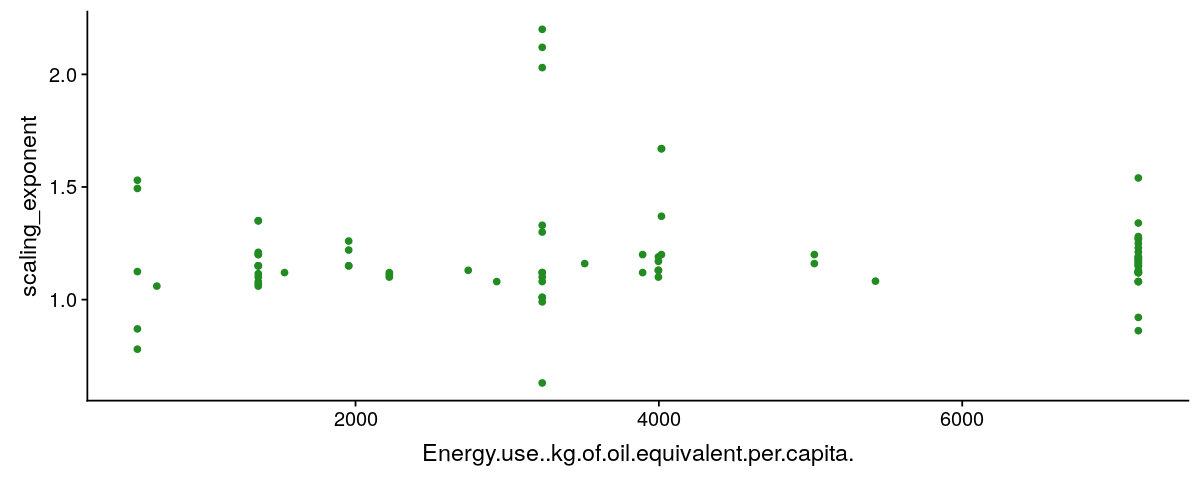

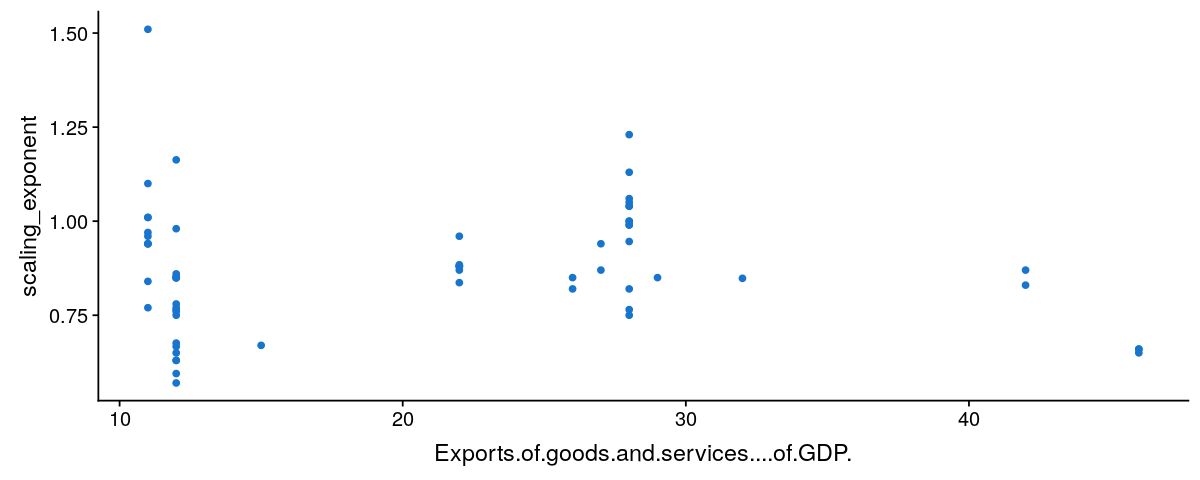

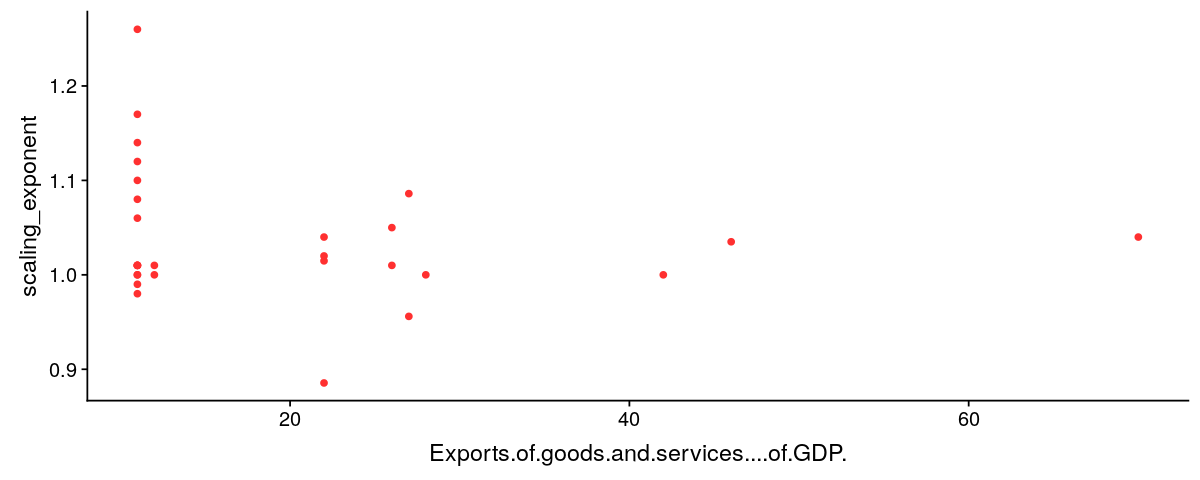

[1] "External.debt.stocks..total..DOD..current.US.."


Warning message:
“Removed 43 rows containing missing values (geom_point).”

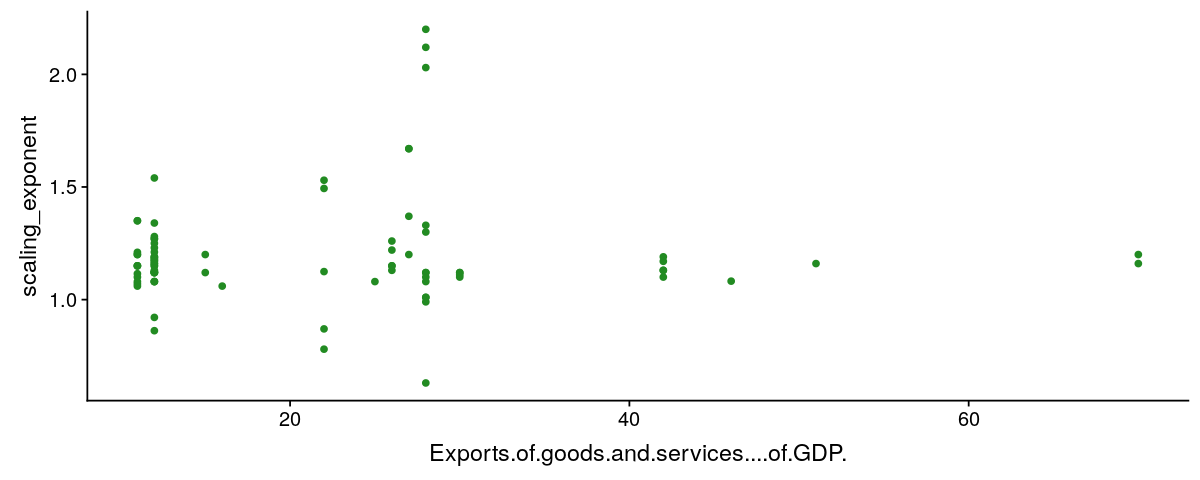

Warning message:
“Removed 8 rows containing missing values (geom_point).”

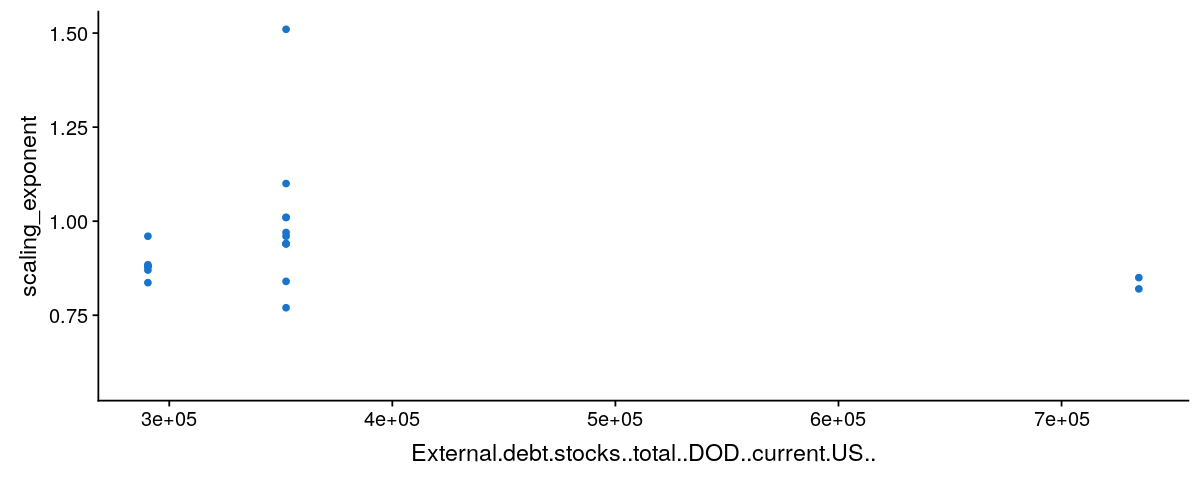

Warning message:
“Removed 62 rows containing missing values (geom_point).”

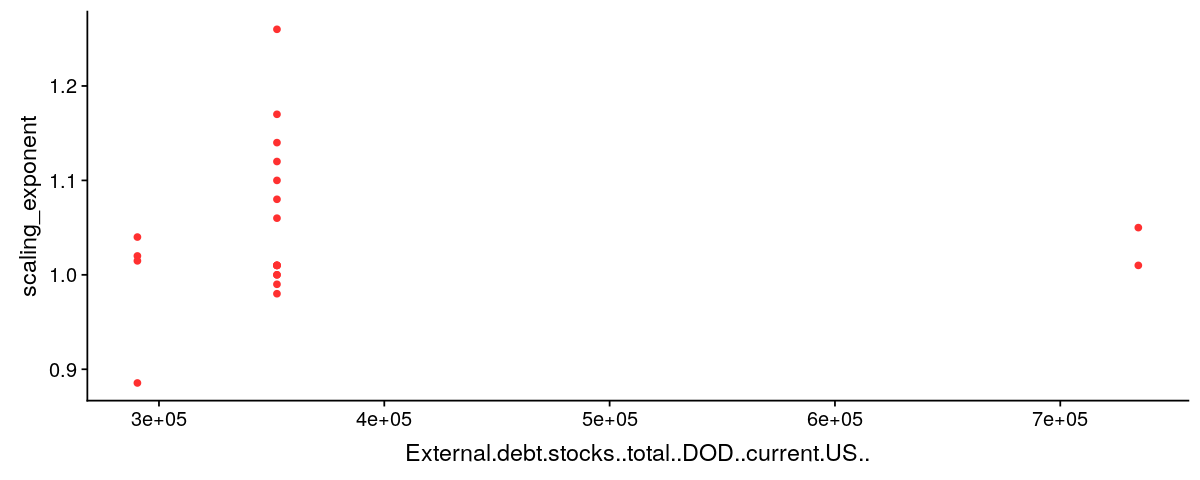

[1] "Fertility.rate..total..births.per.woman."


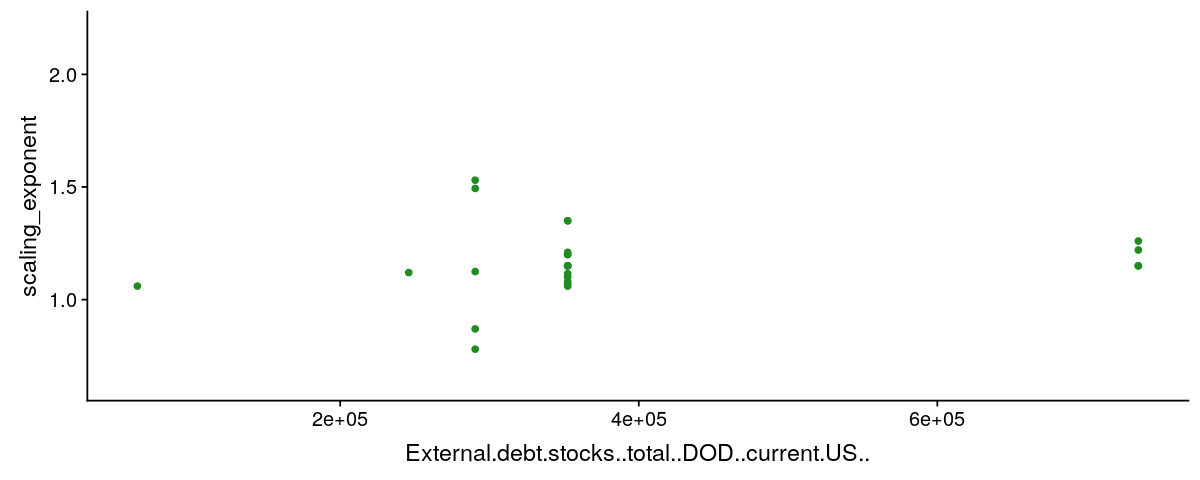

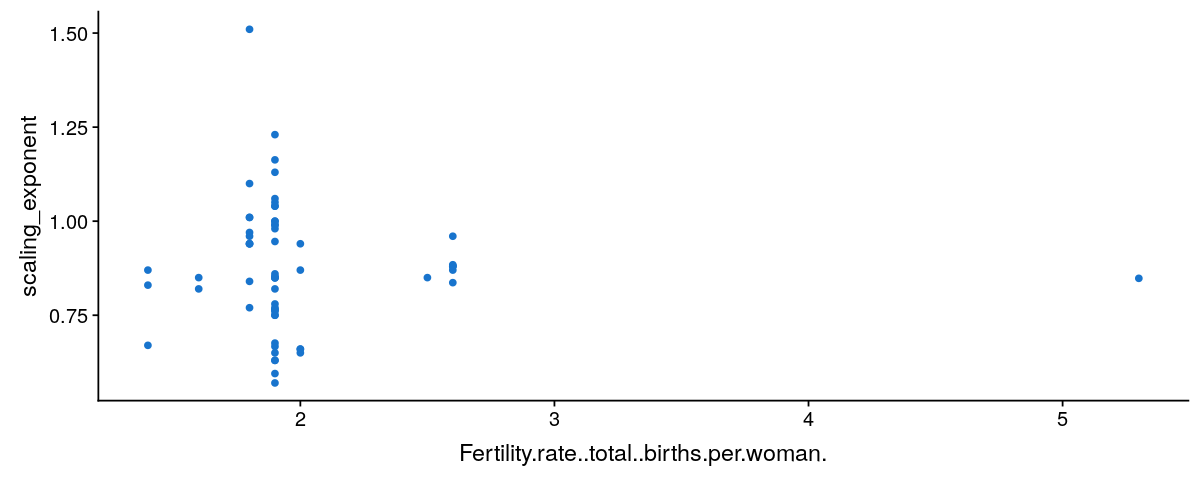

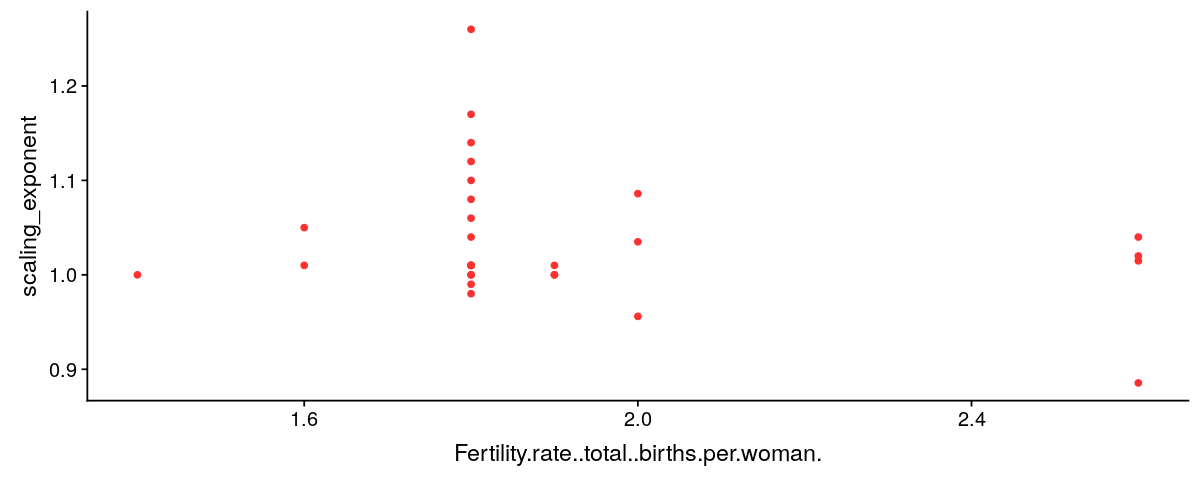

[1] "Foreign.direct.investment..net.inflows..BoP..current.US.."


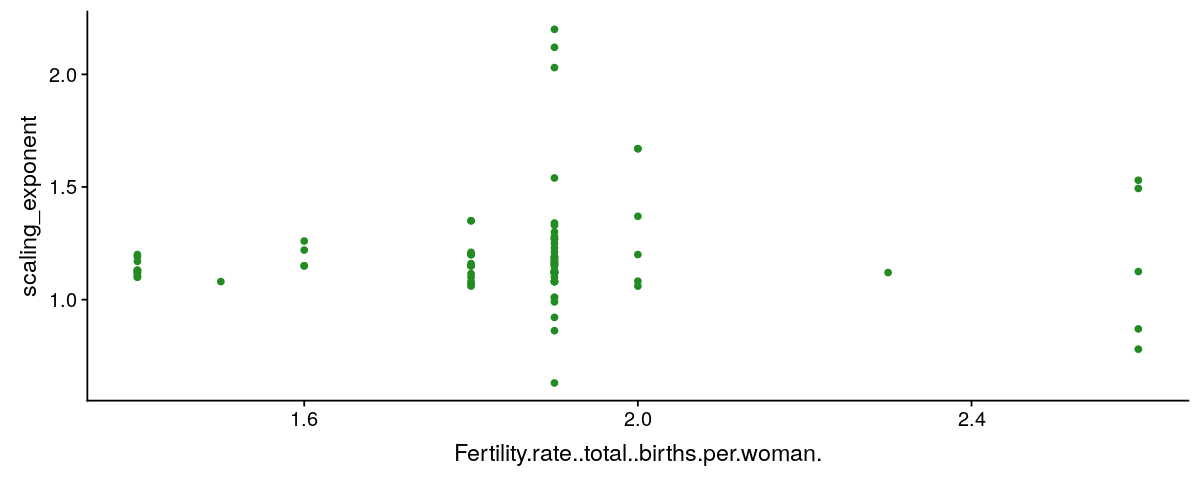

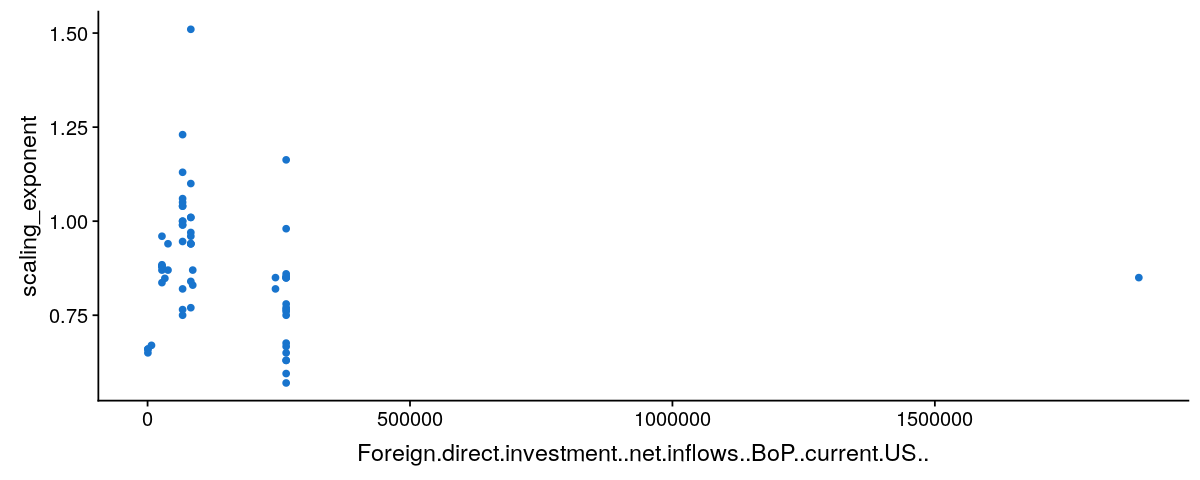

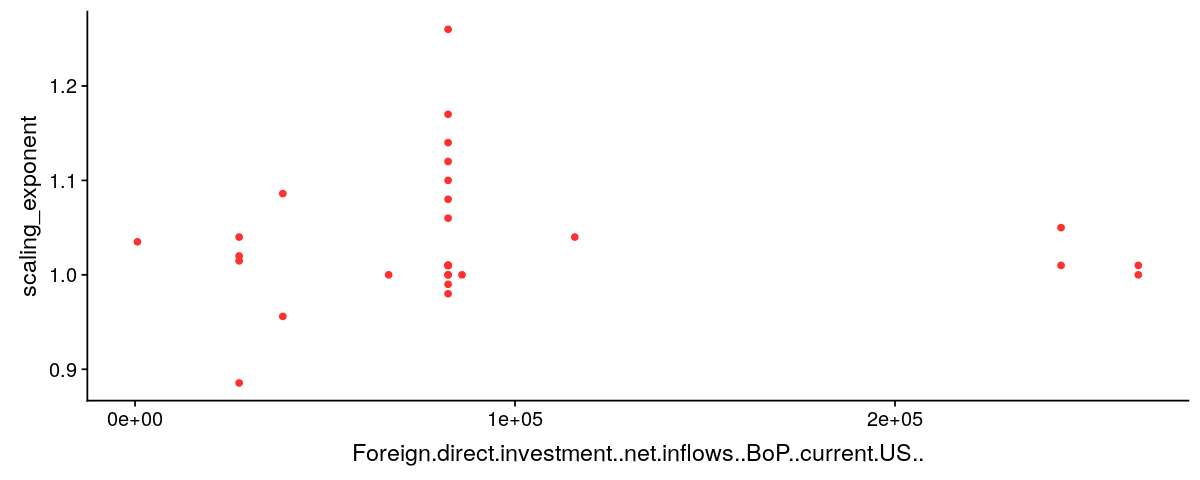

[1] "Forest.area..sq..km."


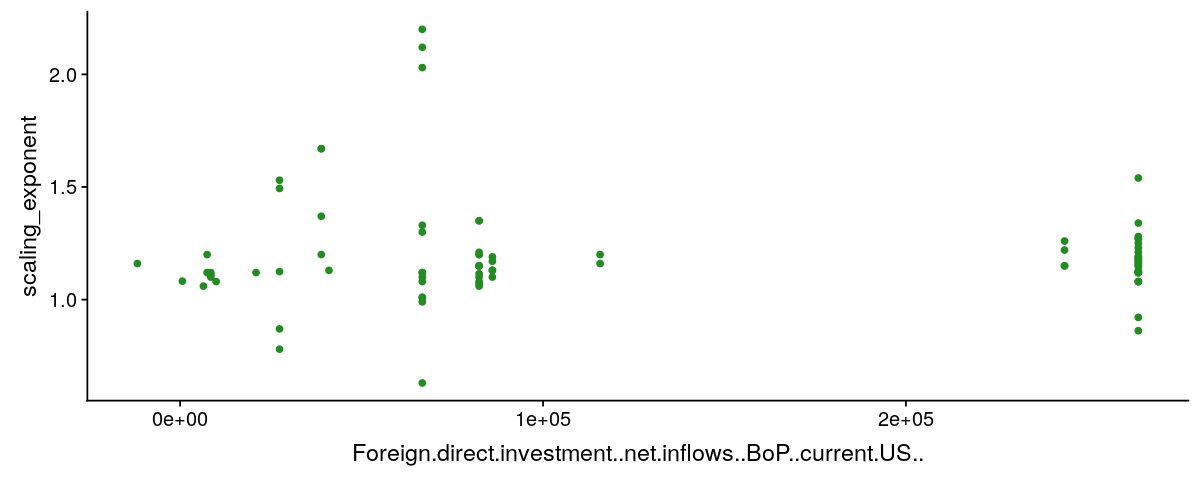

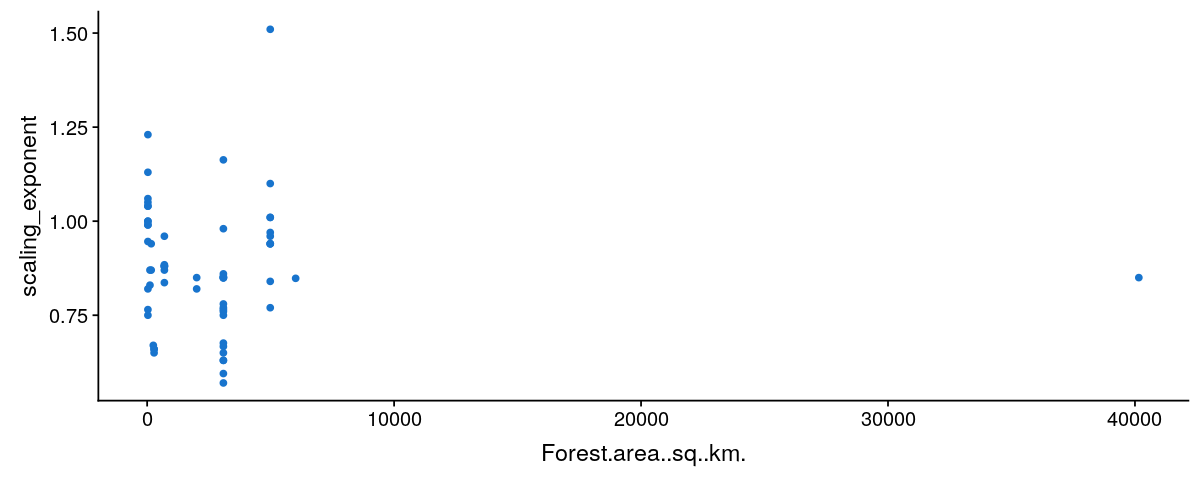

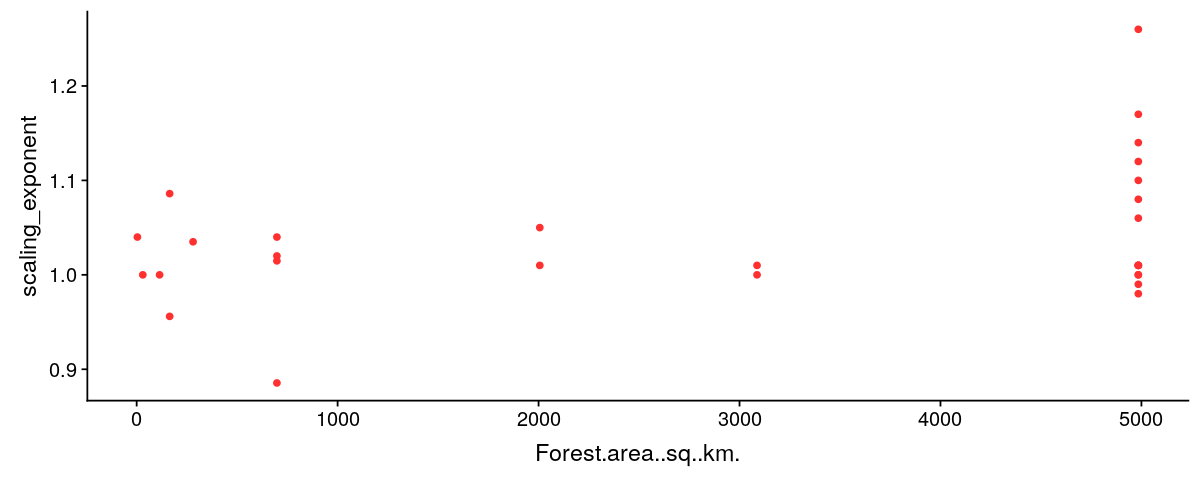

[1] "GDP..current.US.."


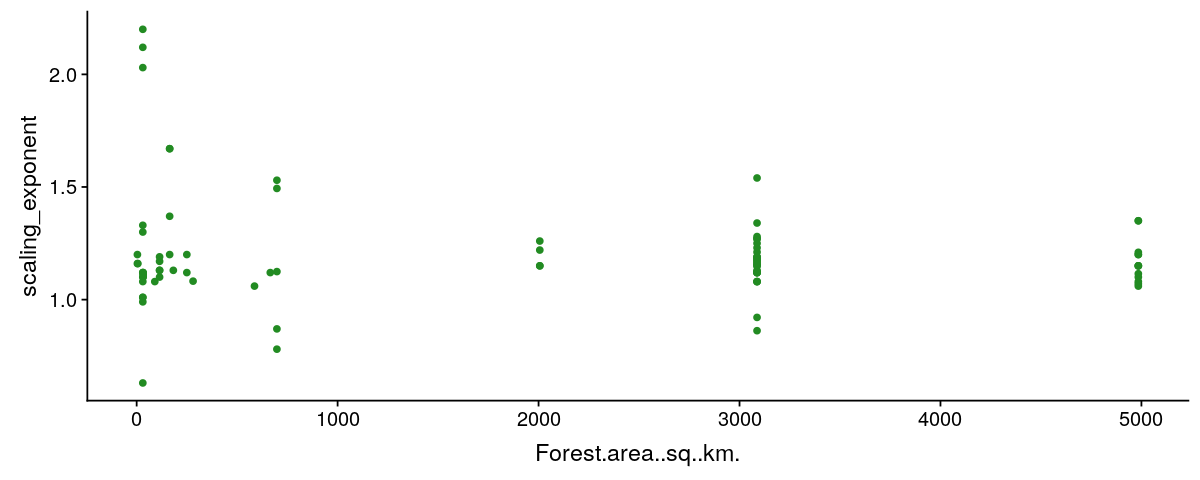

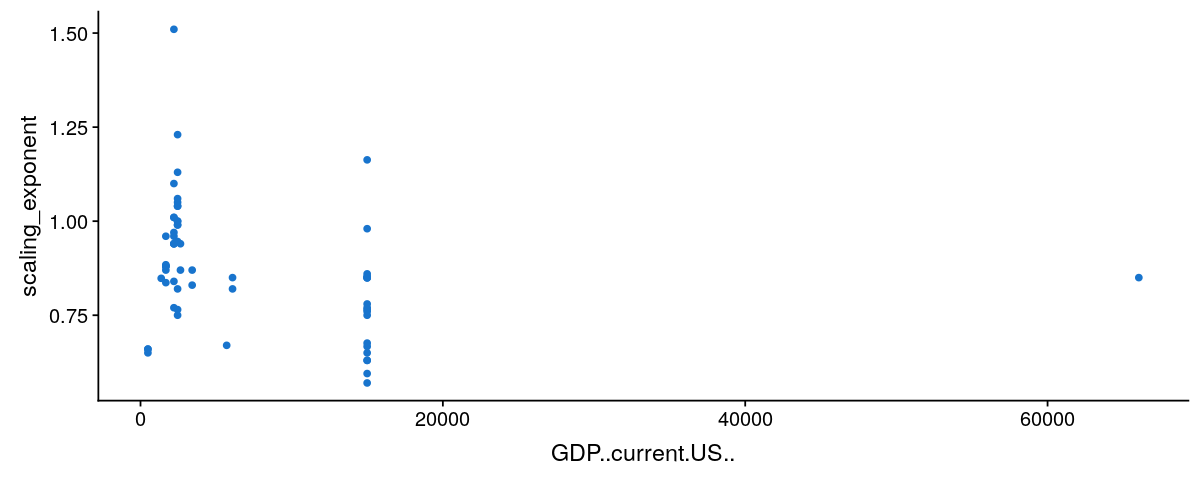

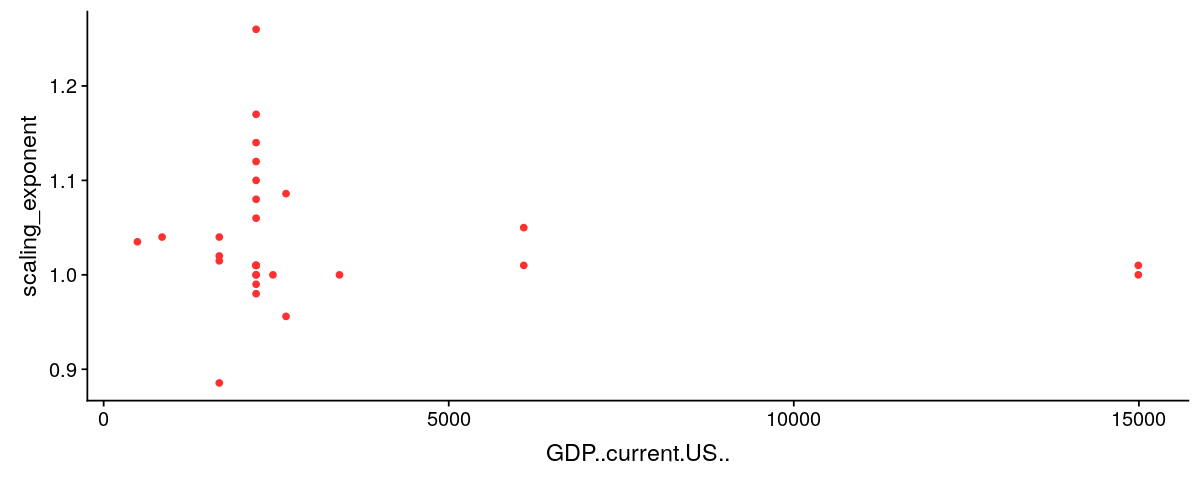

[1] "GDP.growth..annual..."


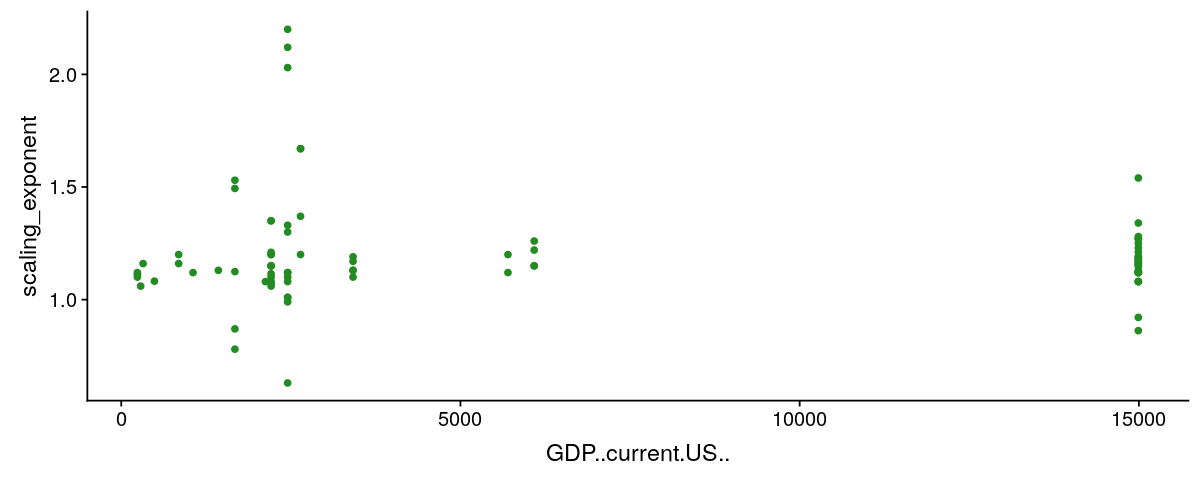

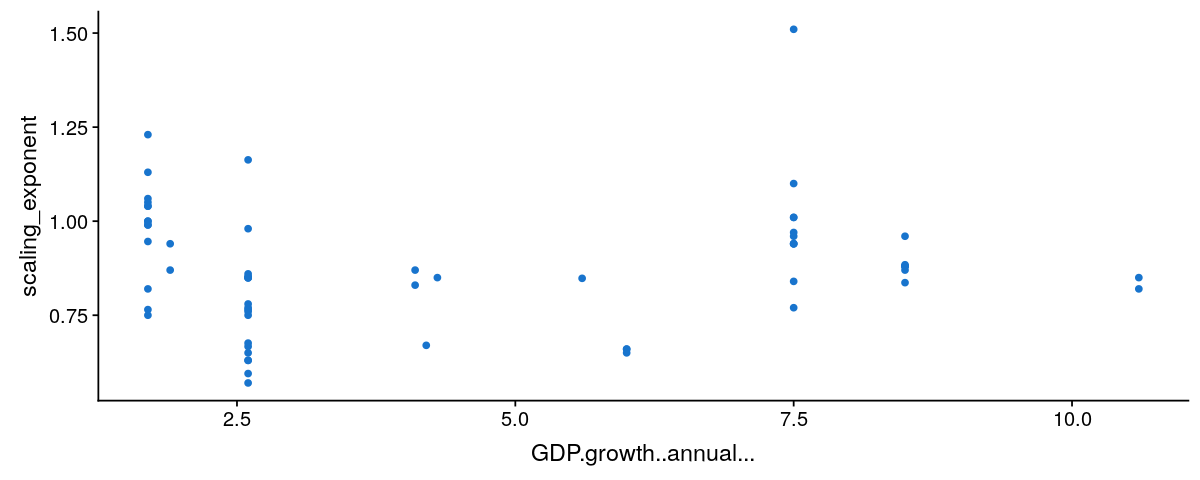

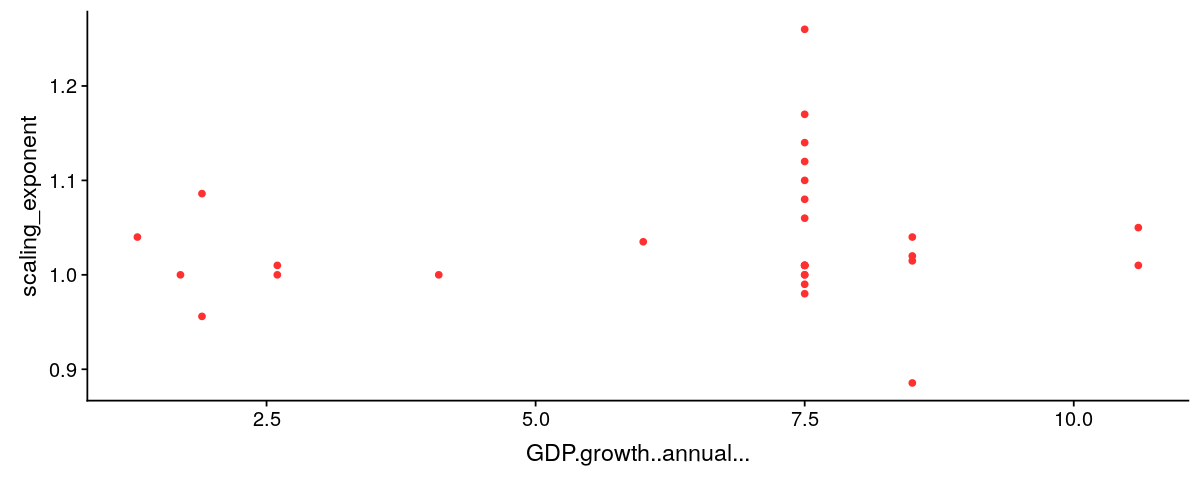

[1] "GNI.per.capita..Atlas.method..current.US.."


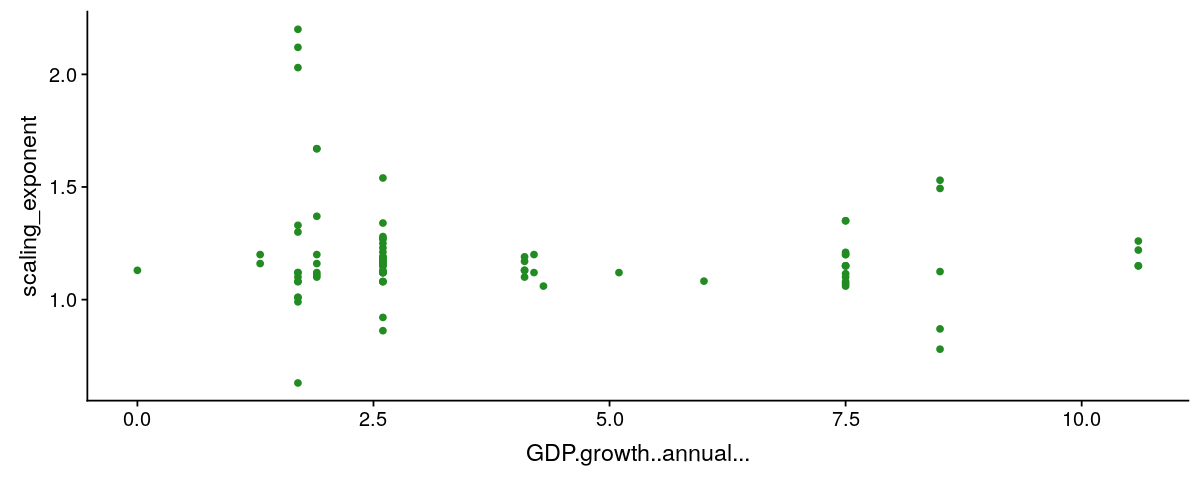

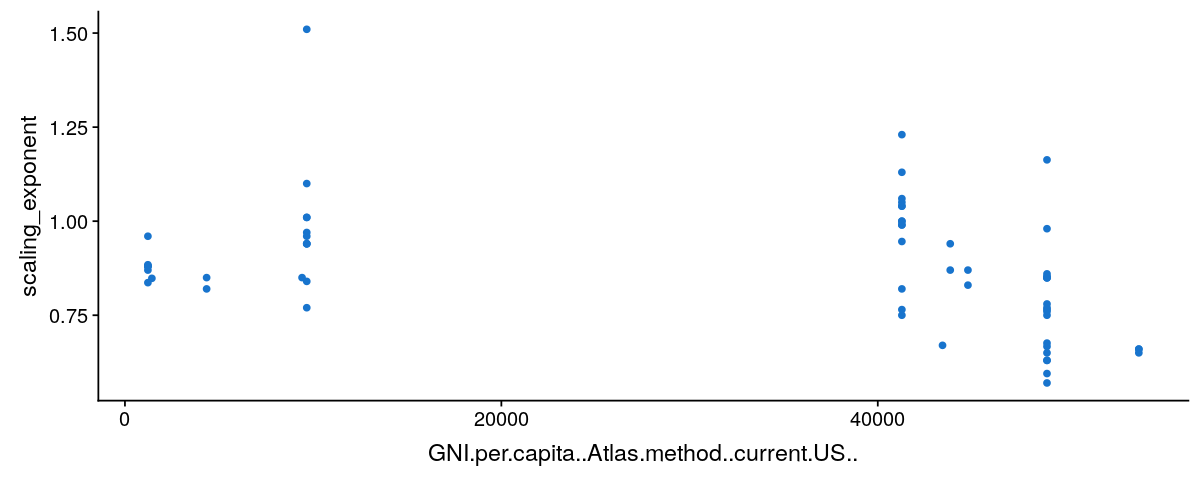

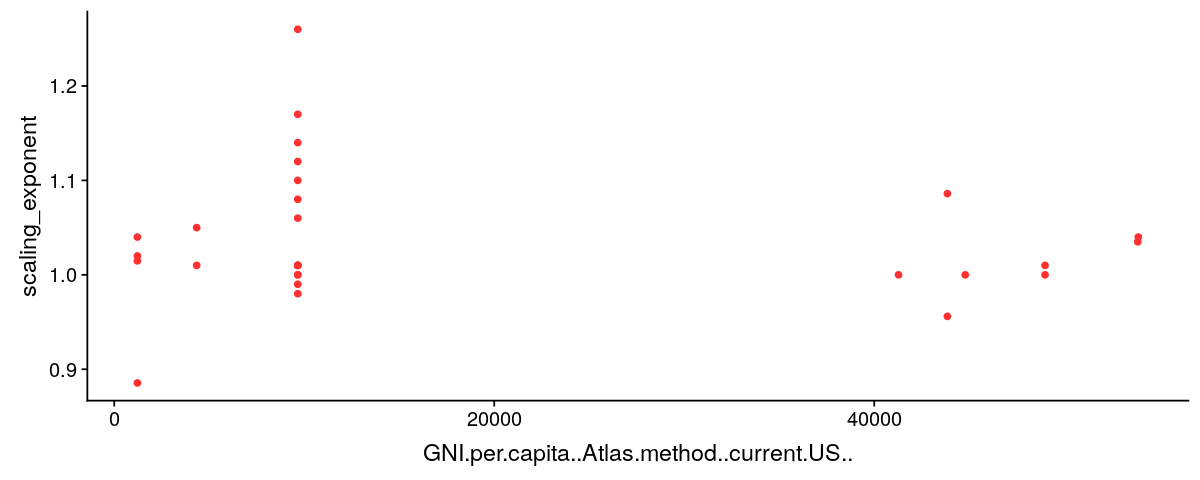

[1] "GNI.per.capita..PPP..current.international..."


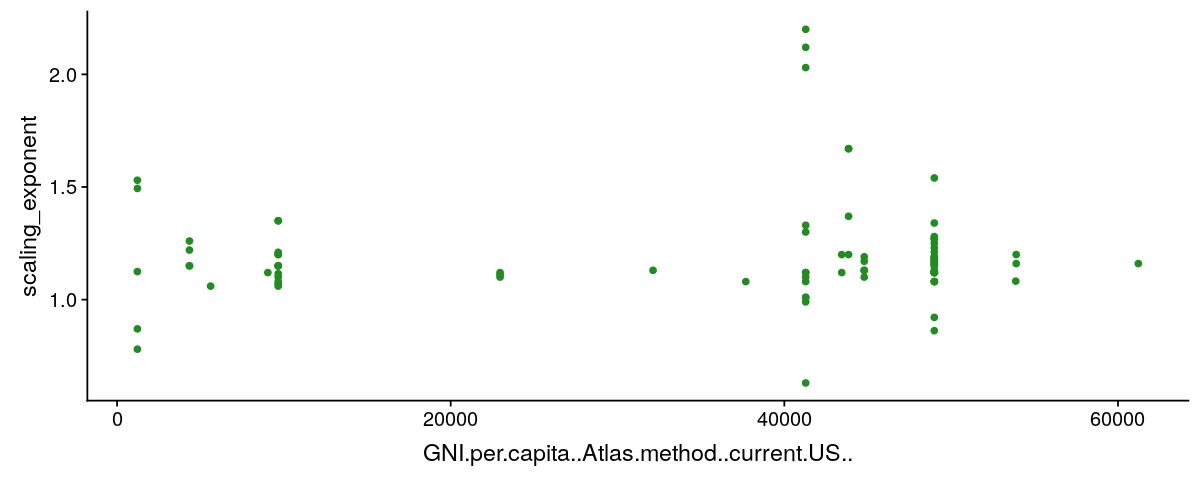

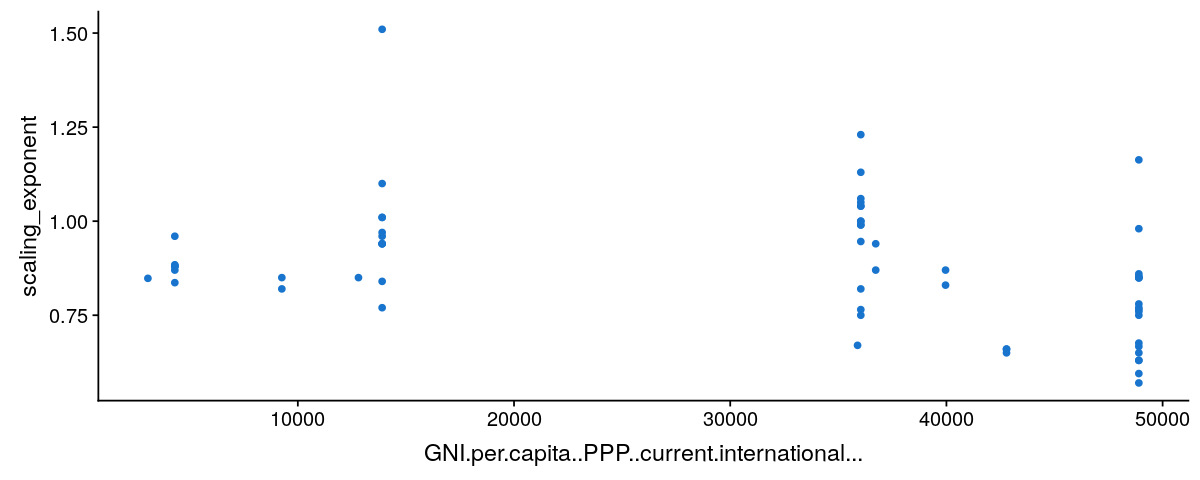

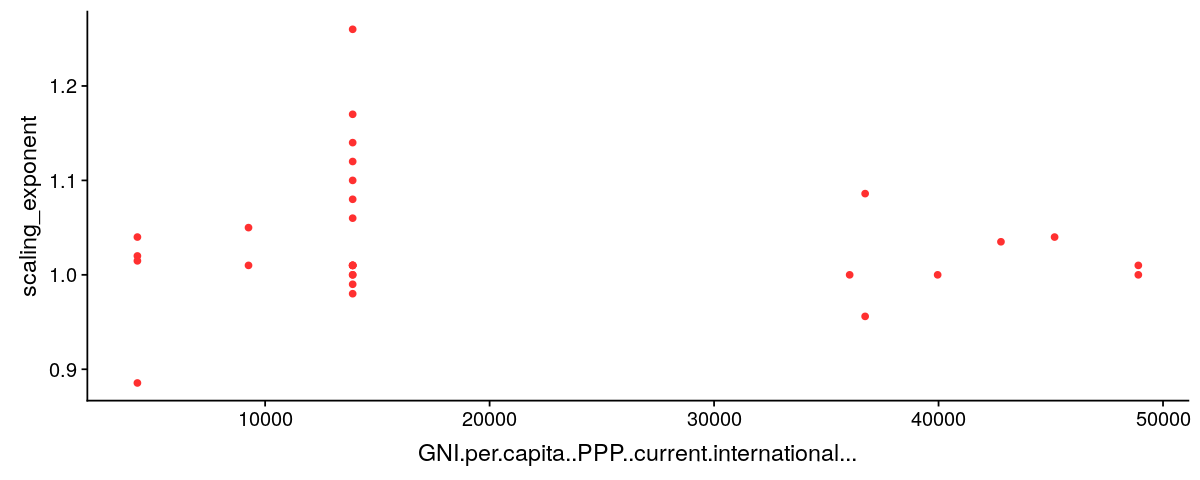

[1] "GNI..Atlas.method..current.US.."


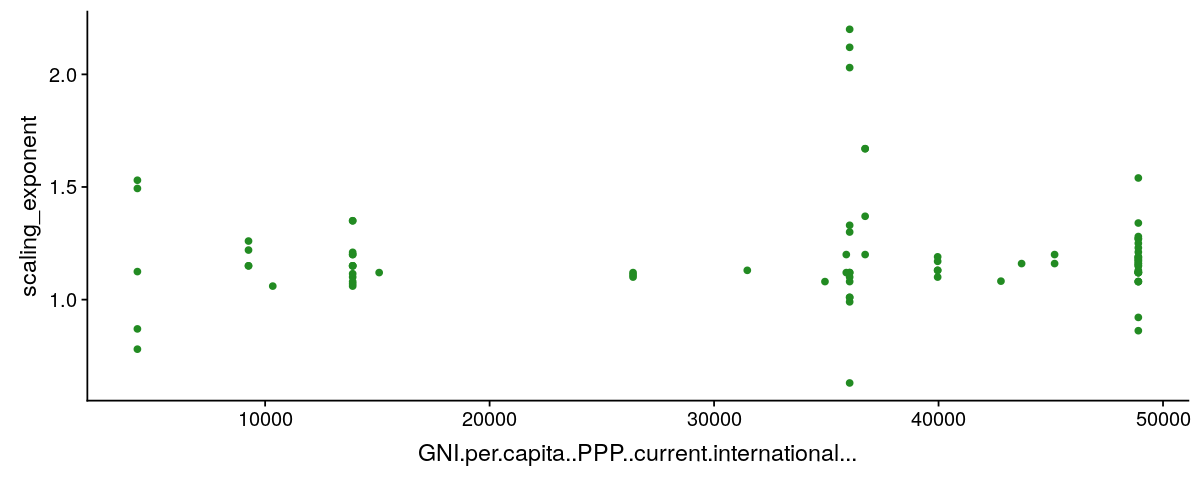

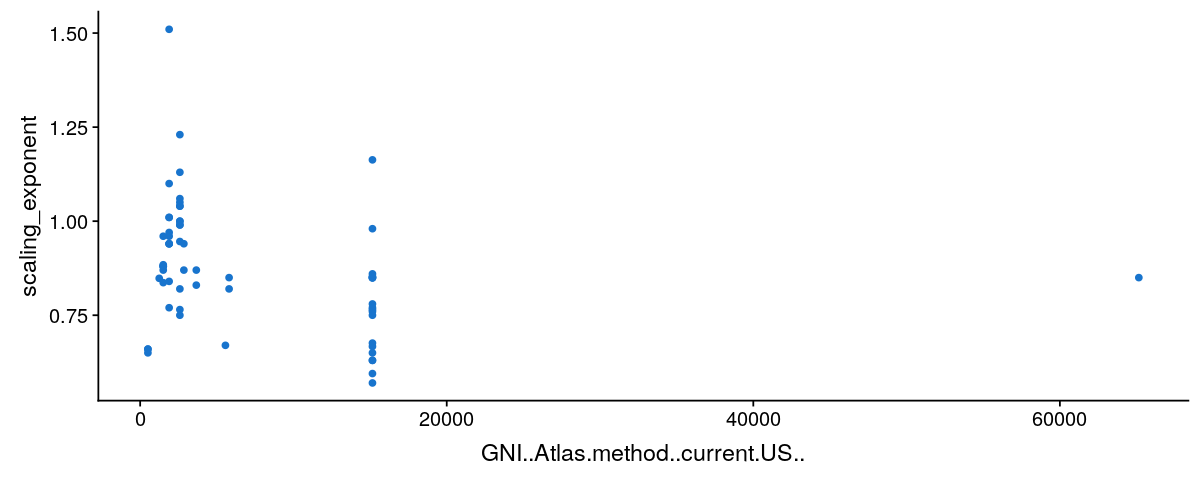

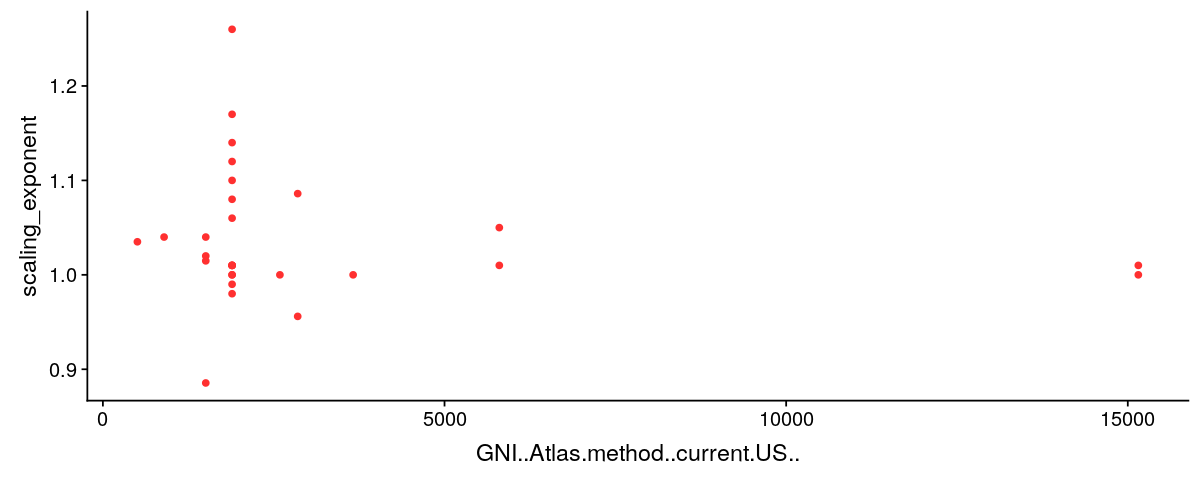

[1] "GNI..PPP..current.international..."


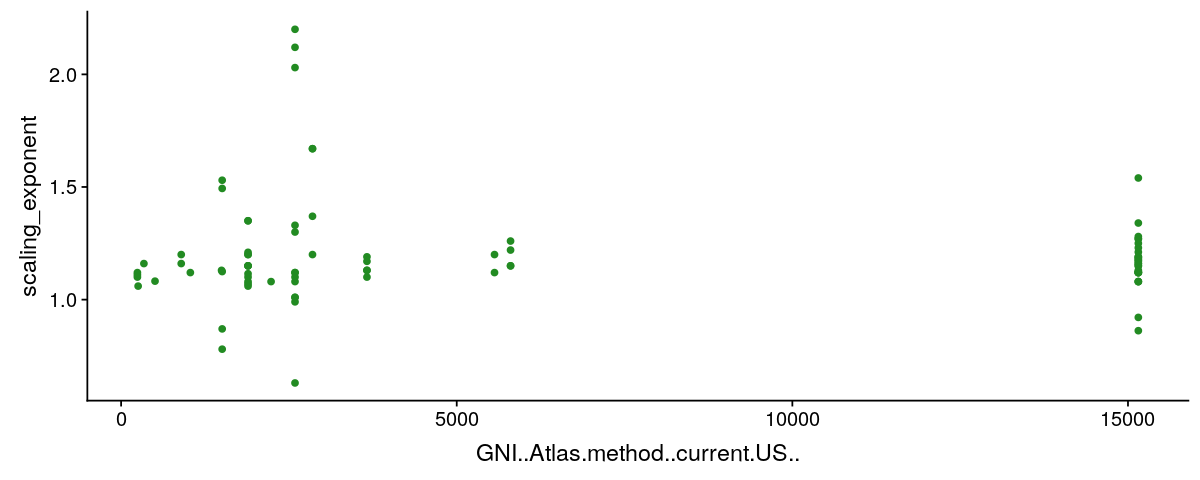

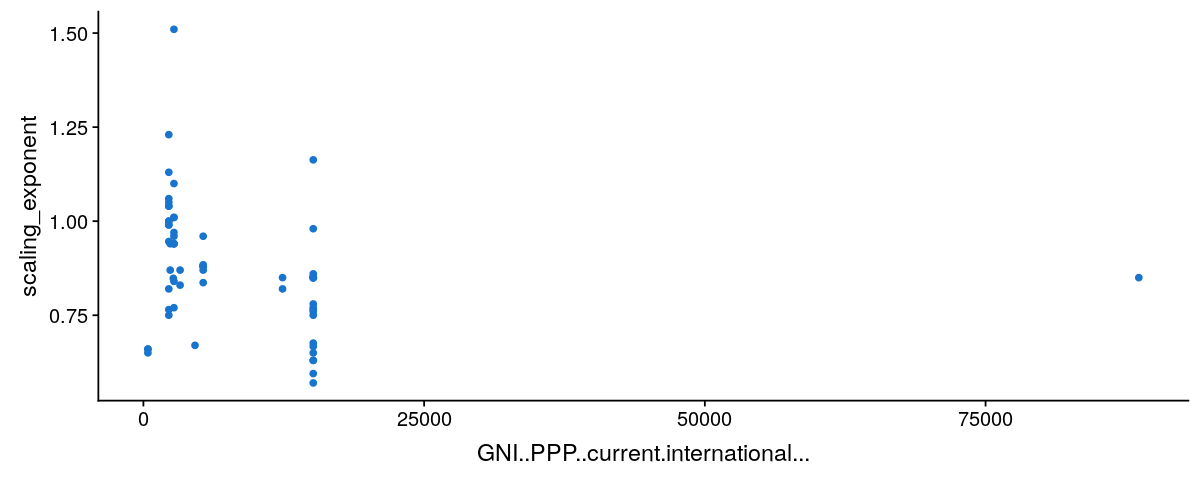

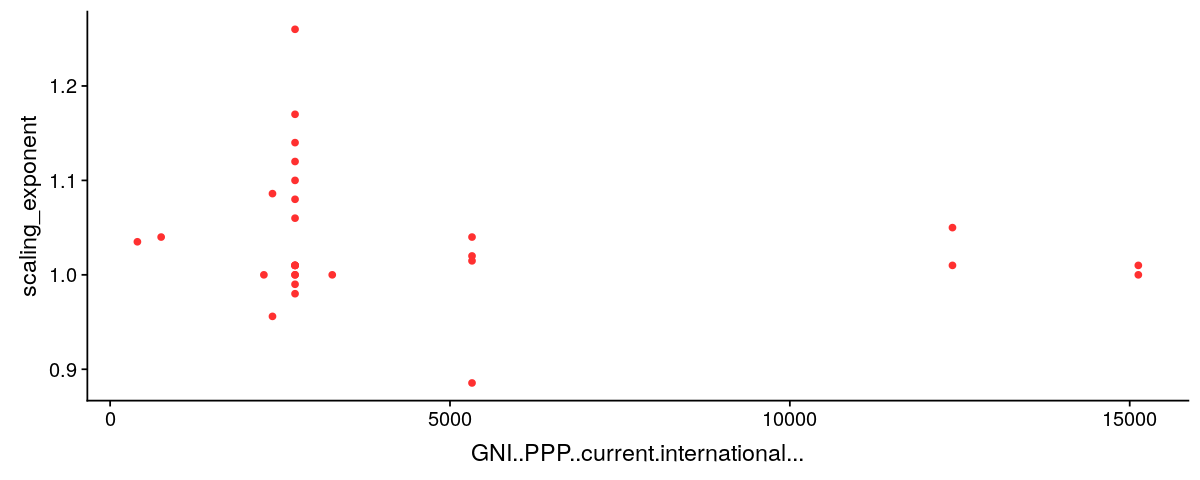

[1] "Gross.capital.formation....of.GDP."


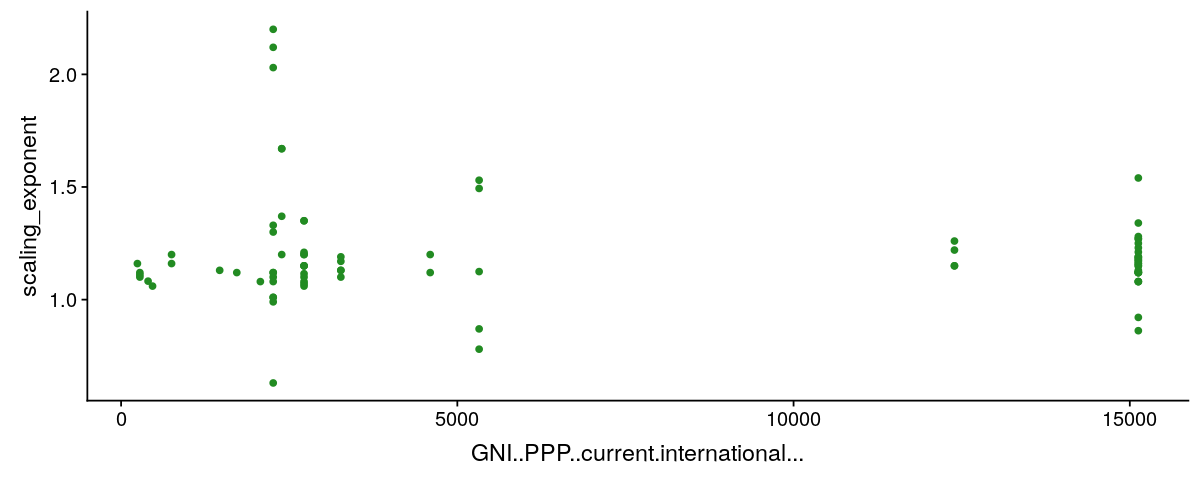

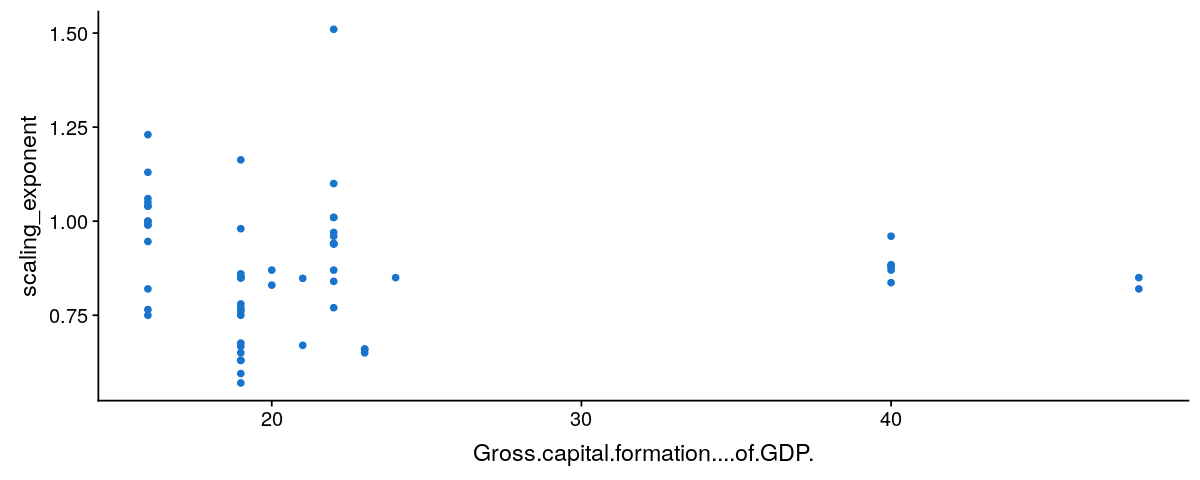

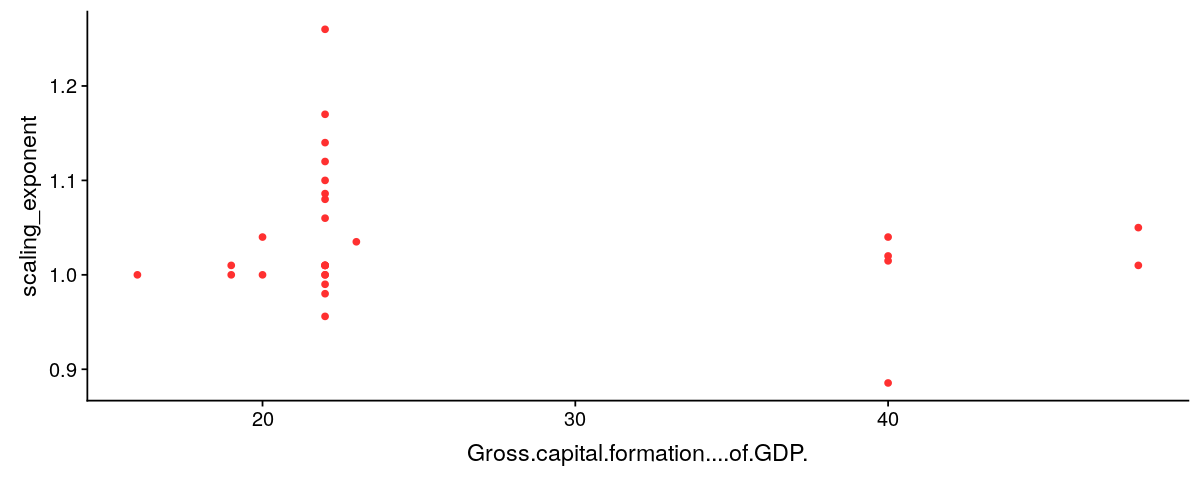

[1] "High.technology.exports....of.manufactured.exports."


Warning message:
“Removed 1 rows containing missing values (geom_point).”

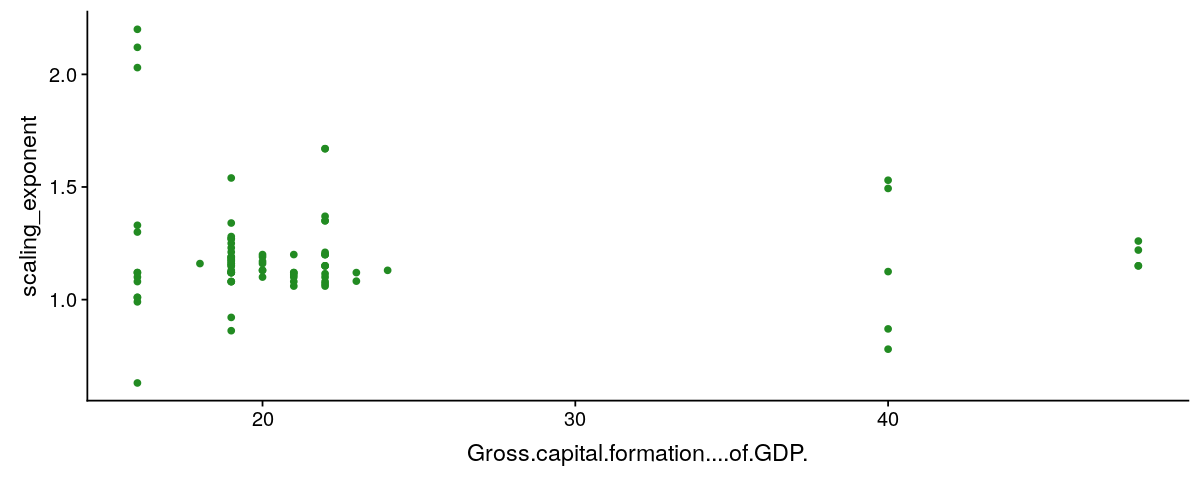

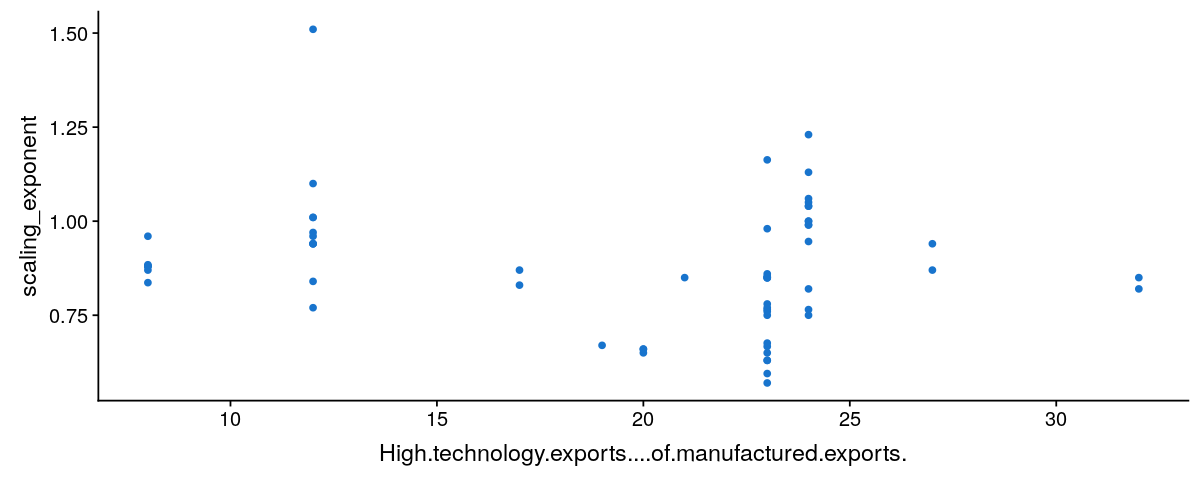

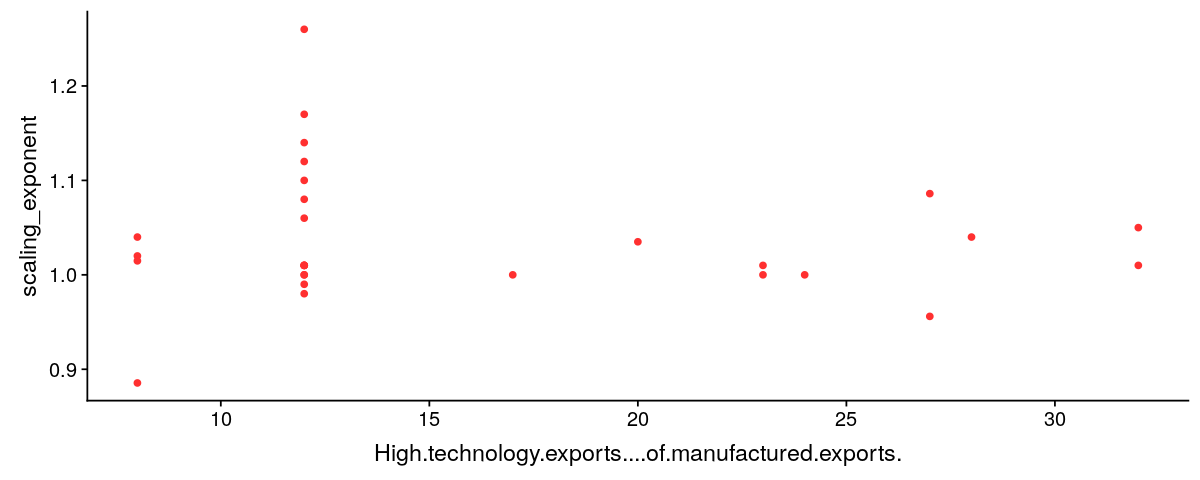

[1] "Immunization..measles....of.children.ages.12.23.months."


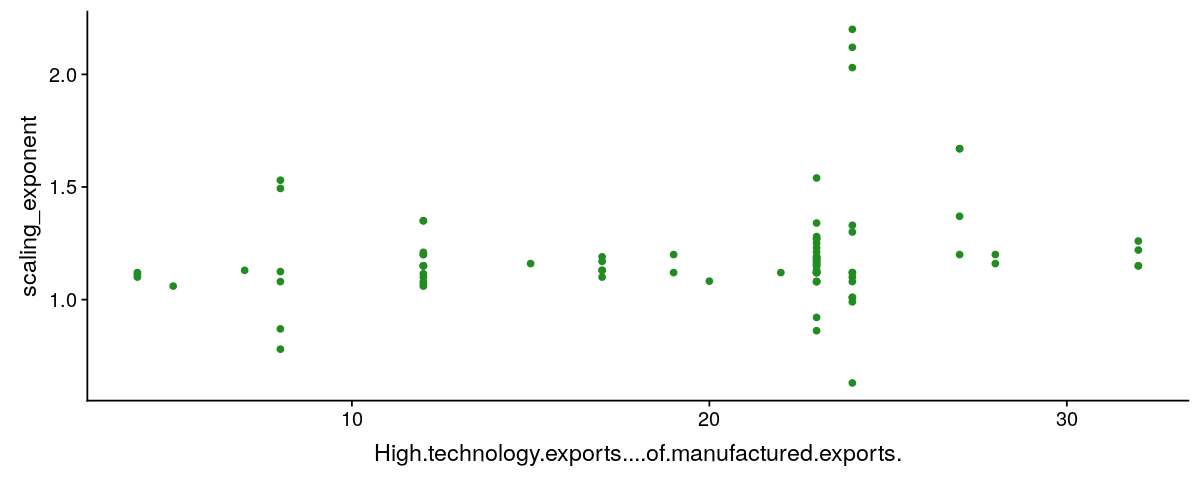

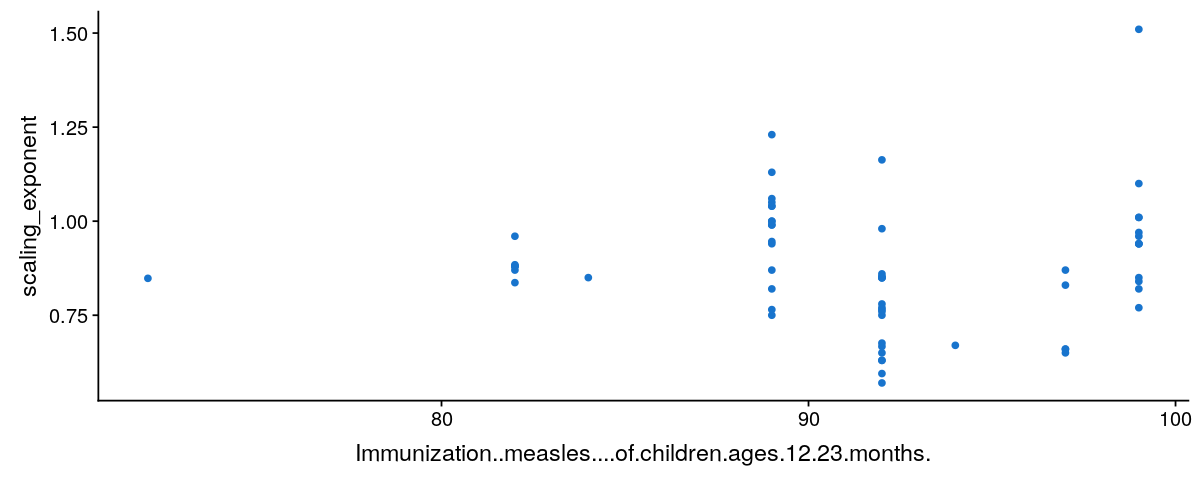

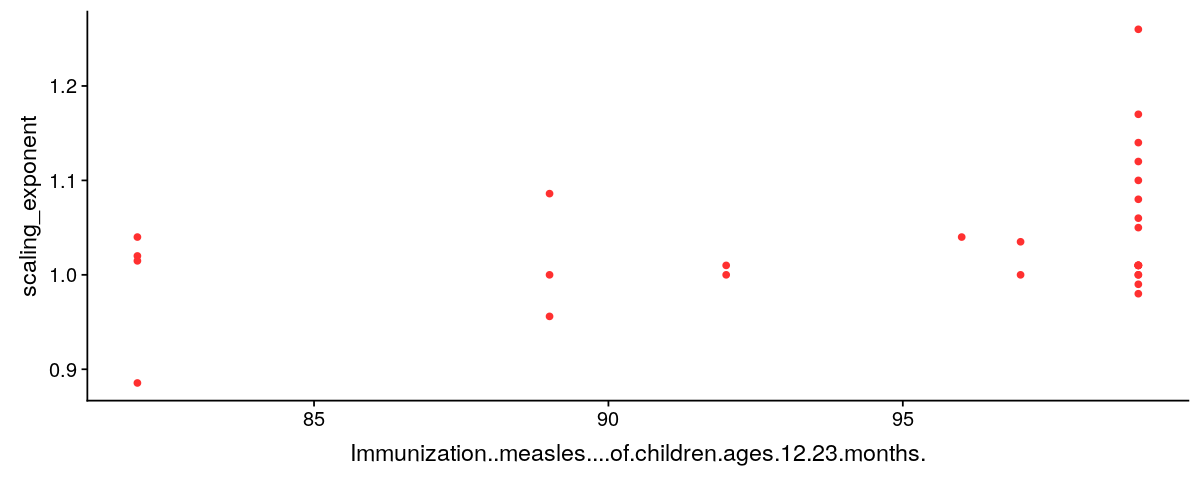

[1] "Imports.of.goods.and.services....of.GDP."


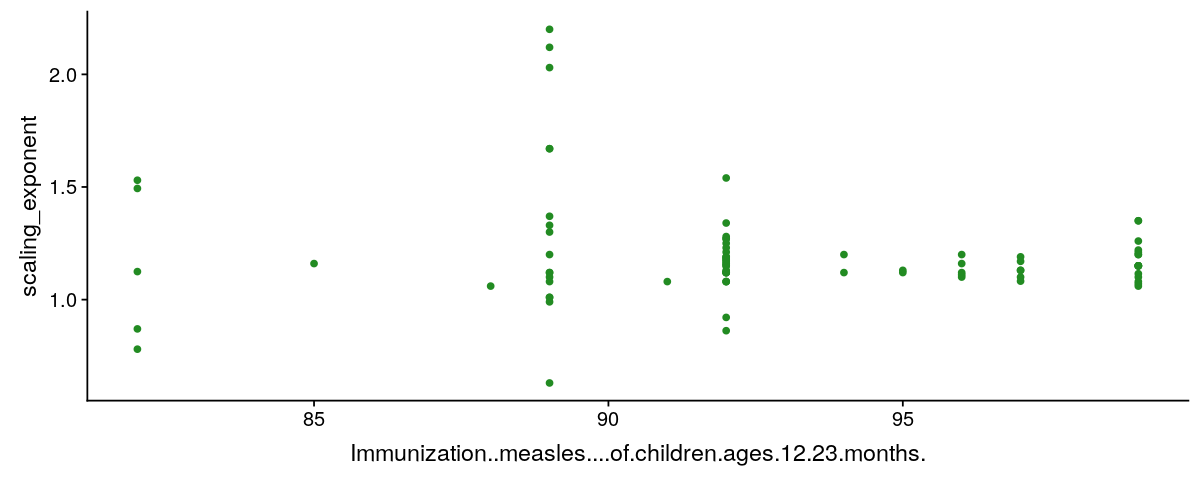

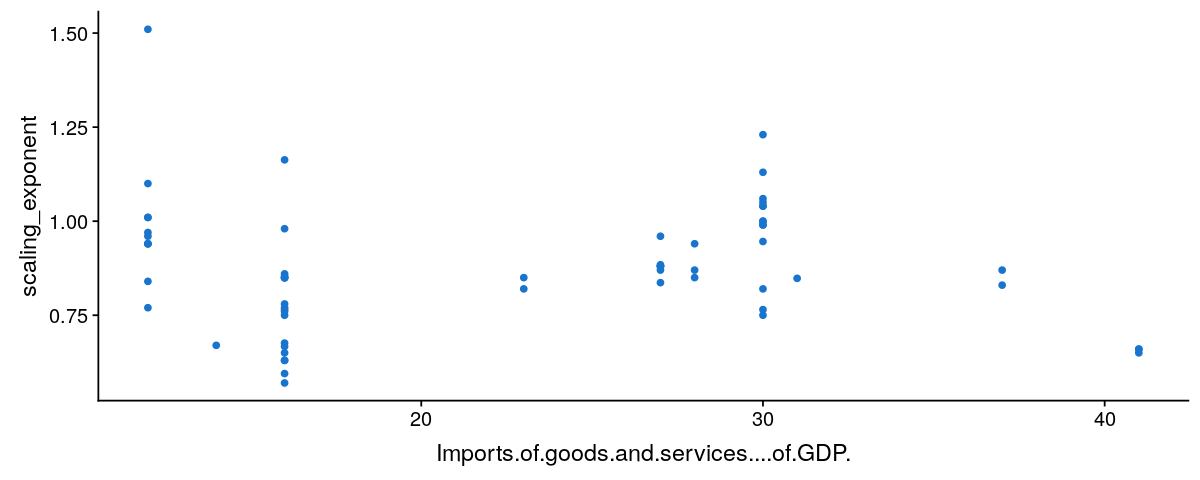

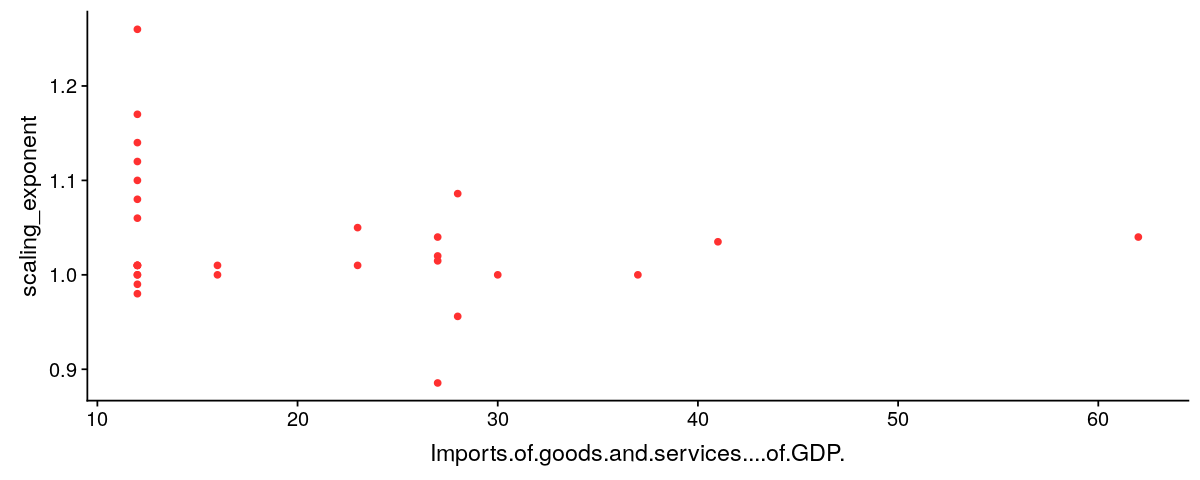

[1] "Income.share.held.by.lowest.20."


Warning message:
“Removed 2 rows containing missing values (geom_point).”

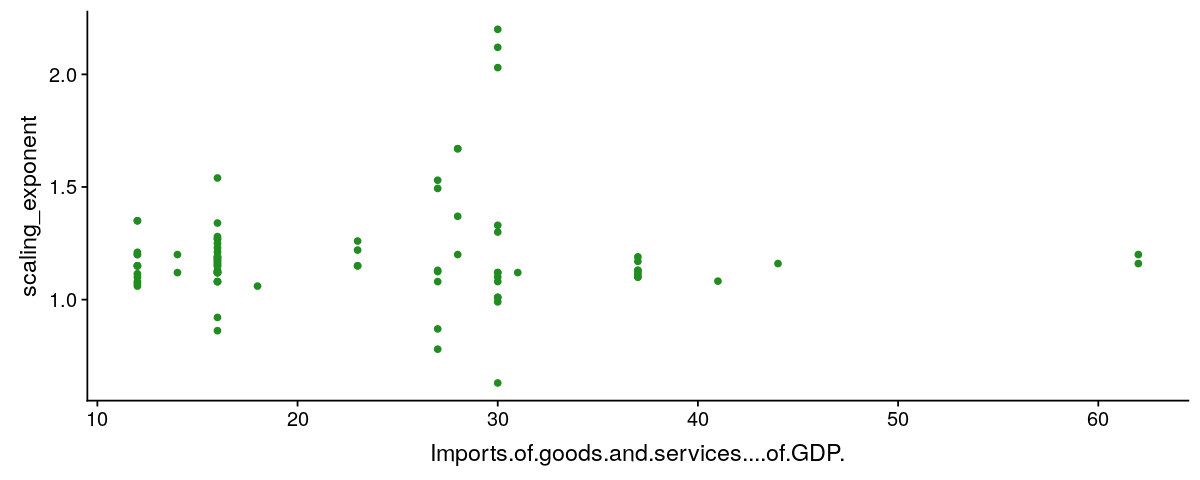

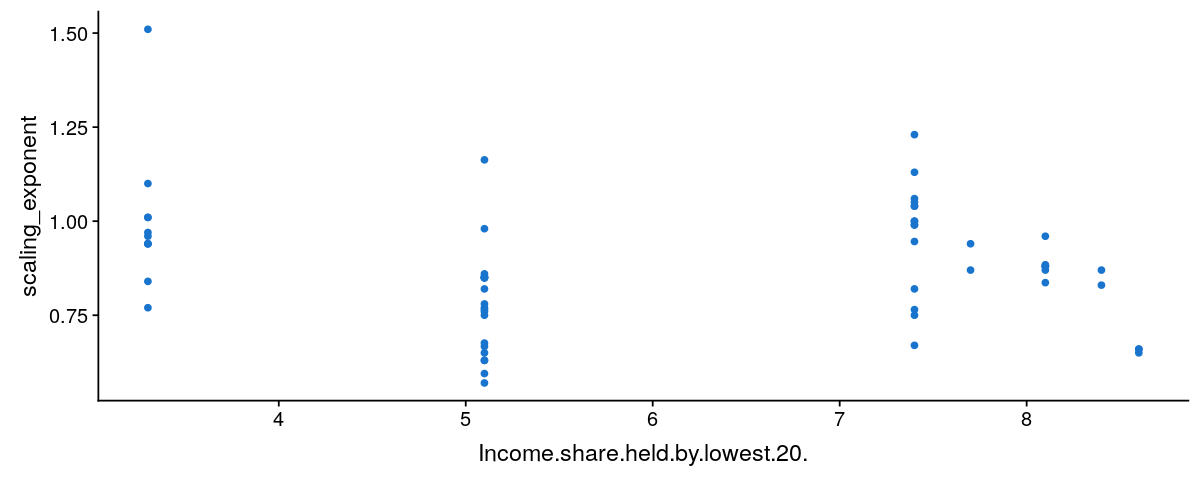

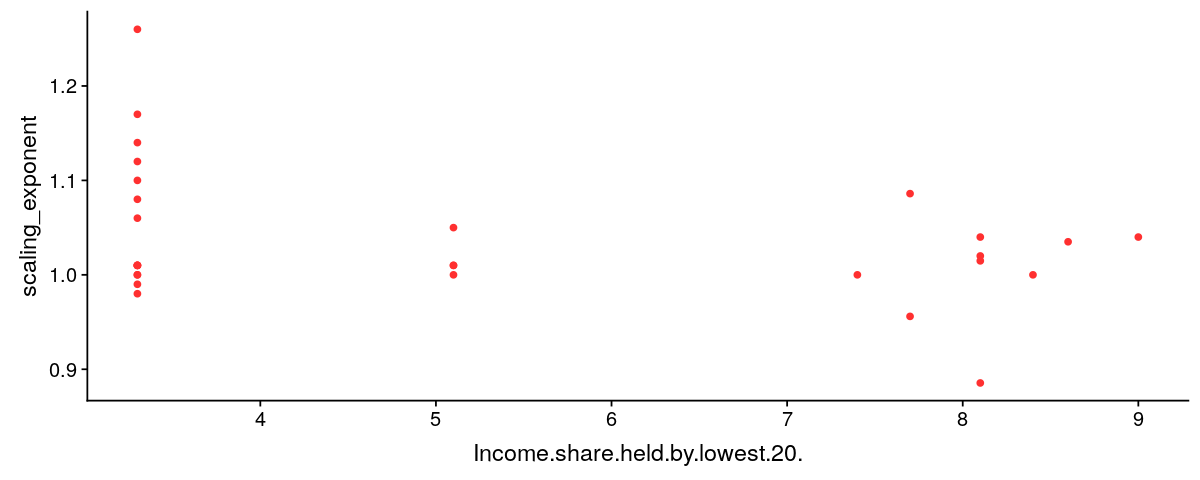

[1] "Individuals.using.the.Internet....of.population."


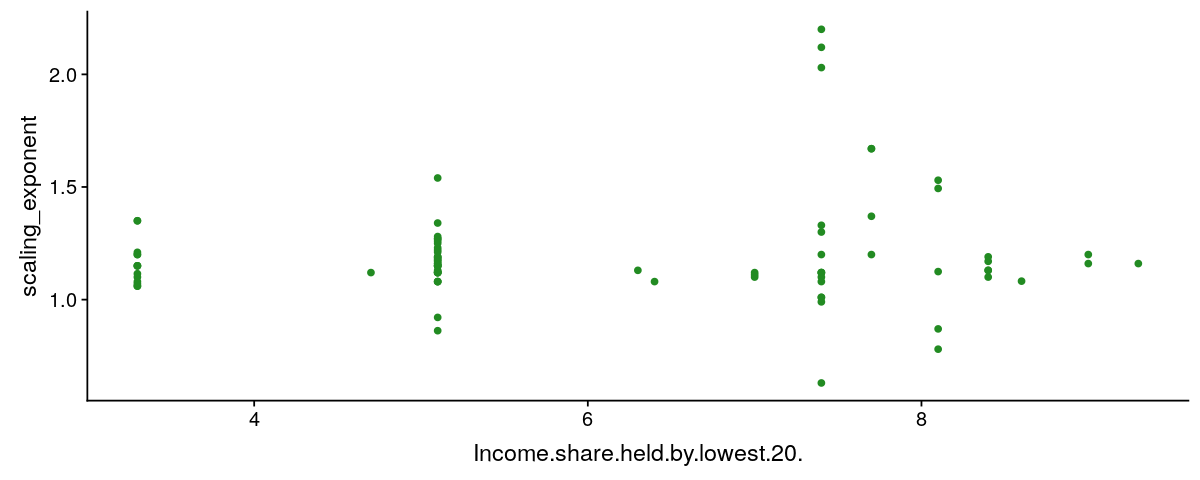

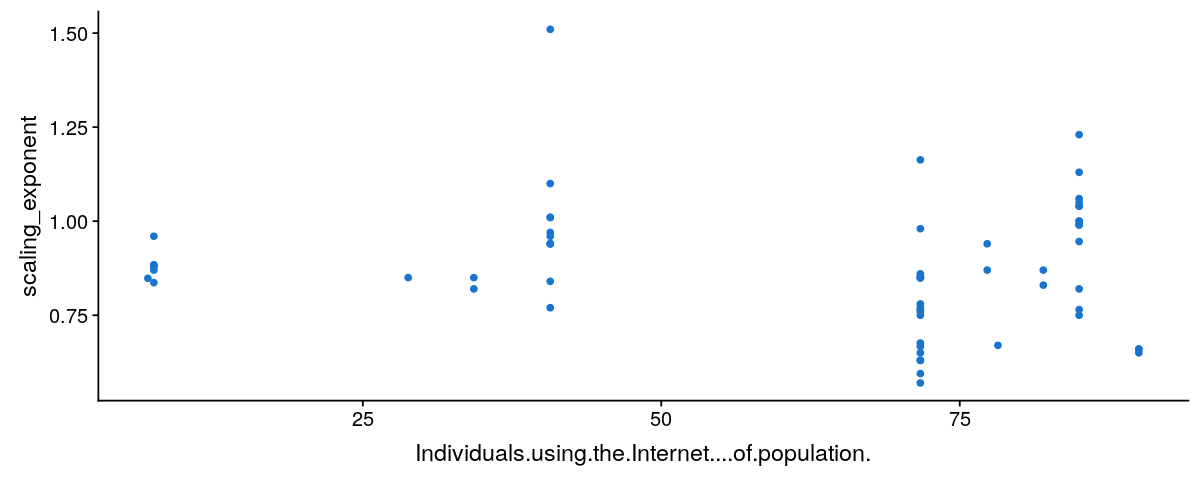

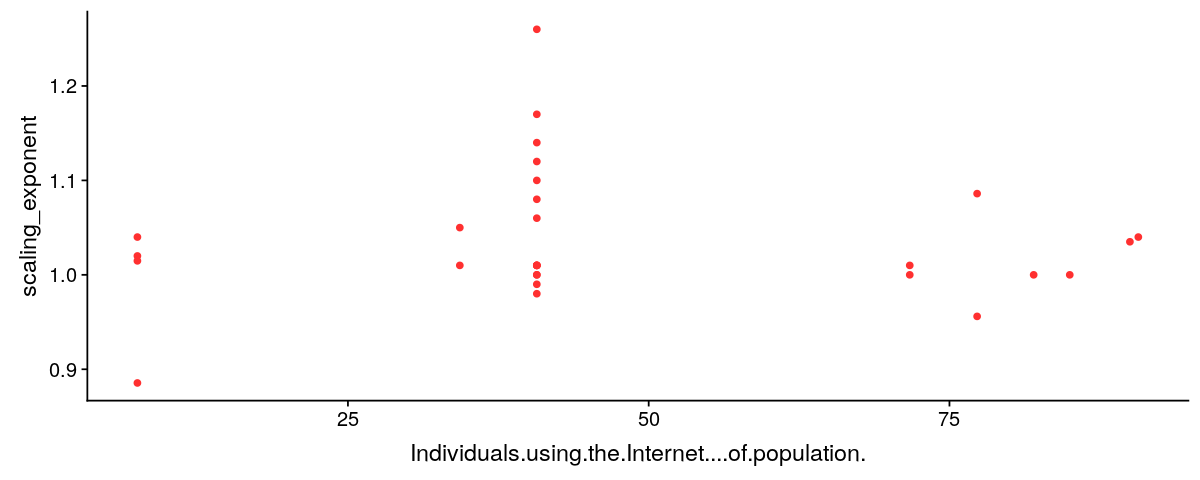

[1] "Industry..including.construction...value.added....of.GDP."


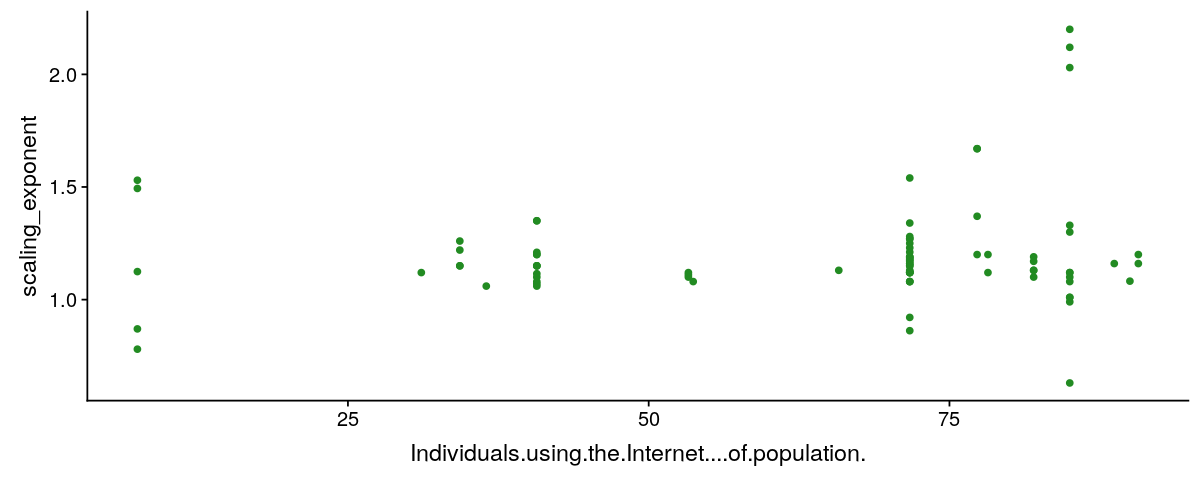

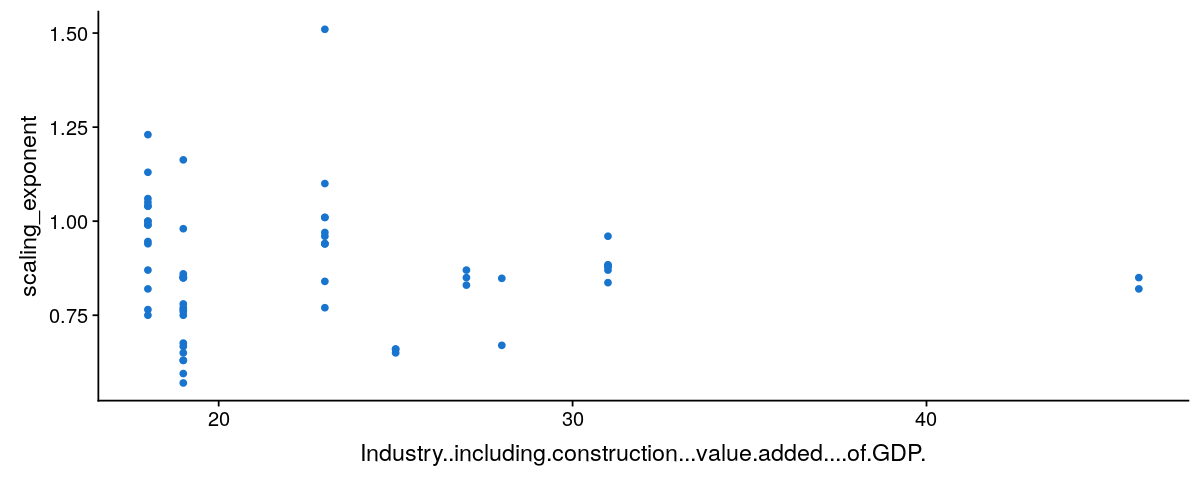

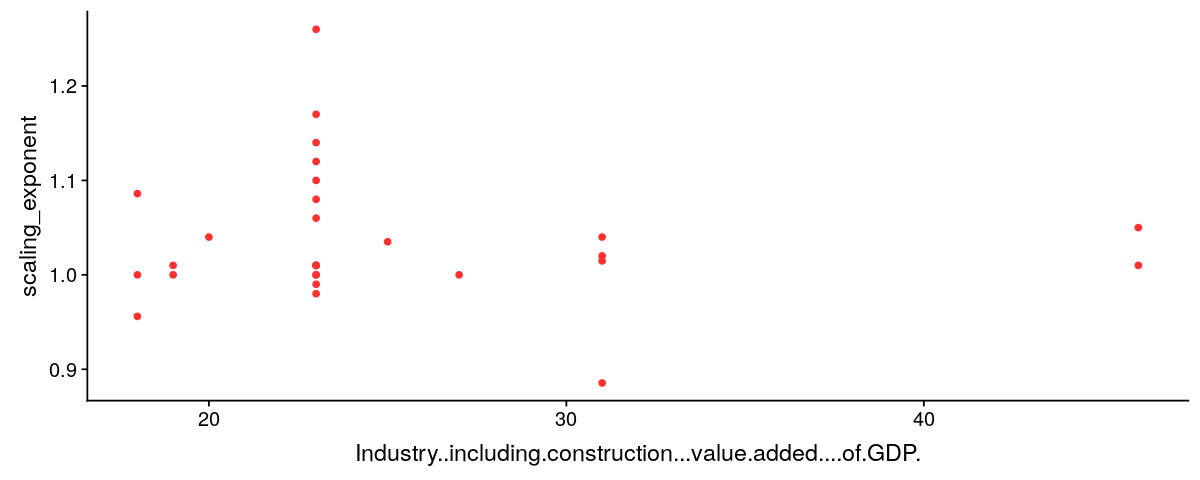

[1] "Inflation..GDP.deflator..annual..."


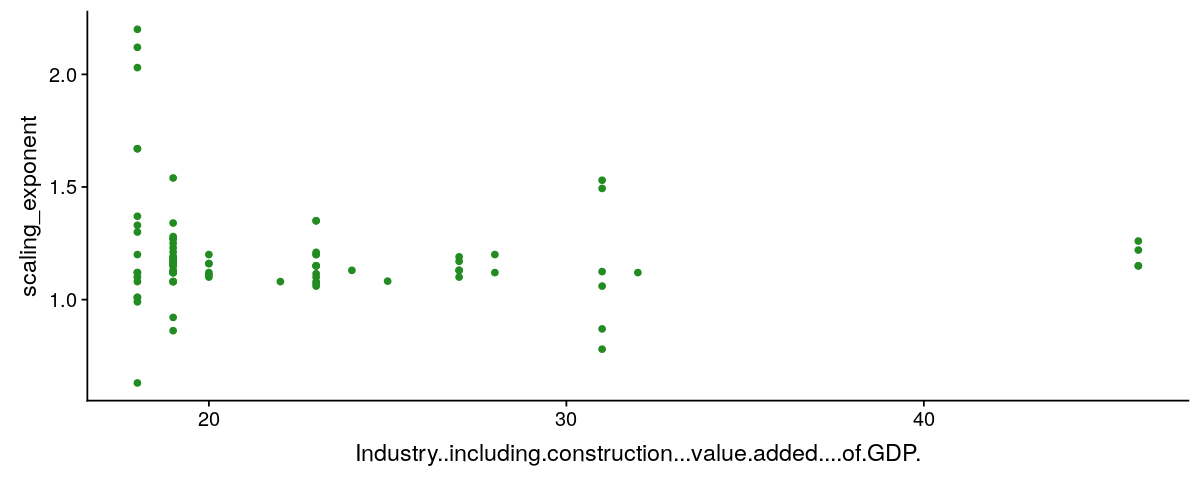

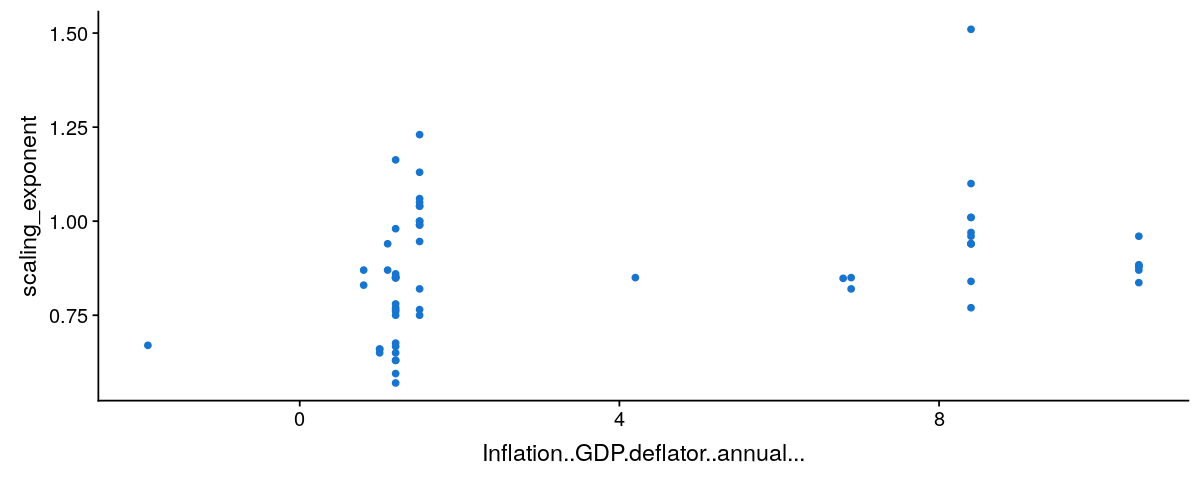

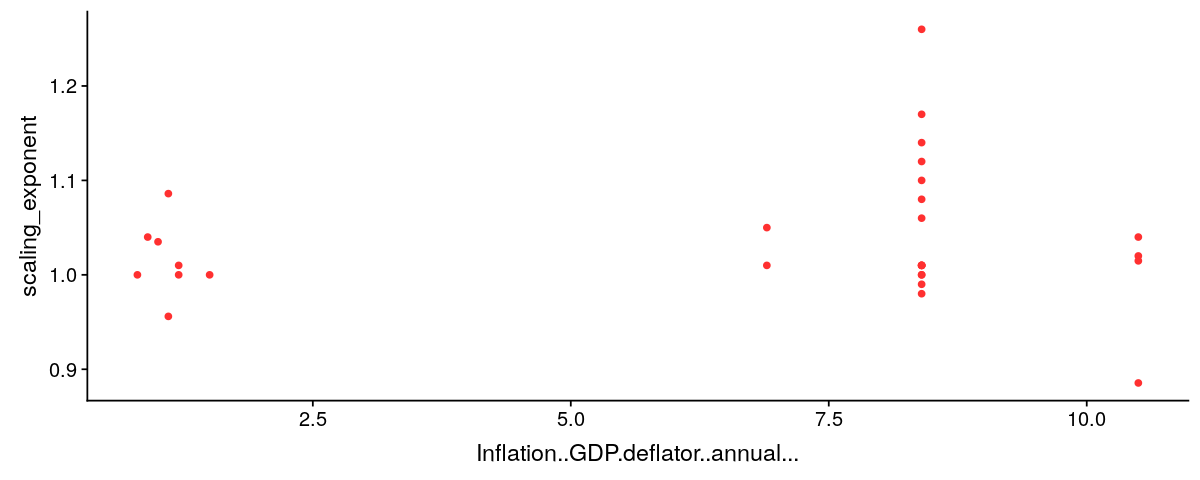

[1] "Life.expectancy.at.birth..total..years."


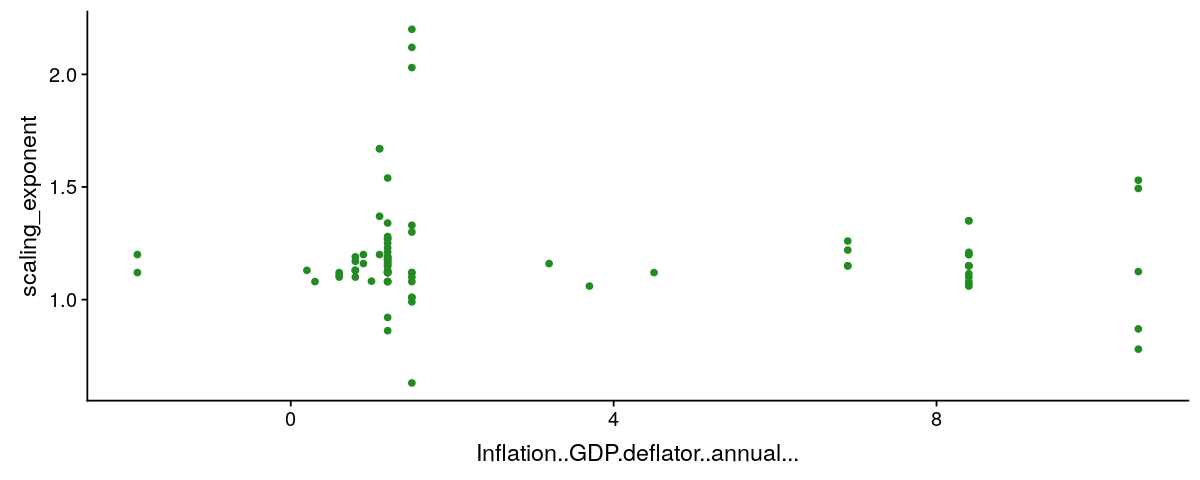

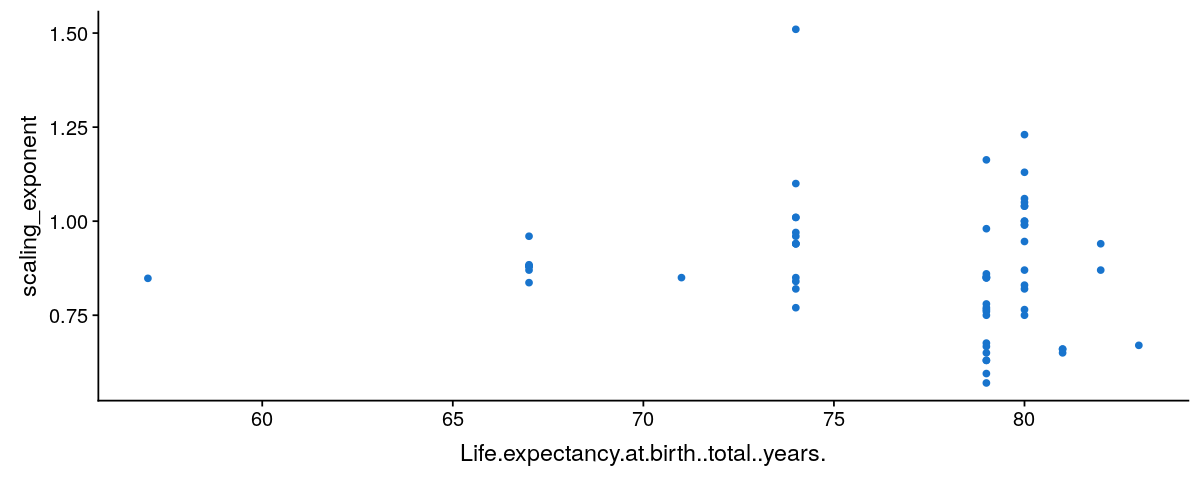

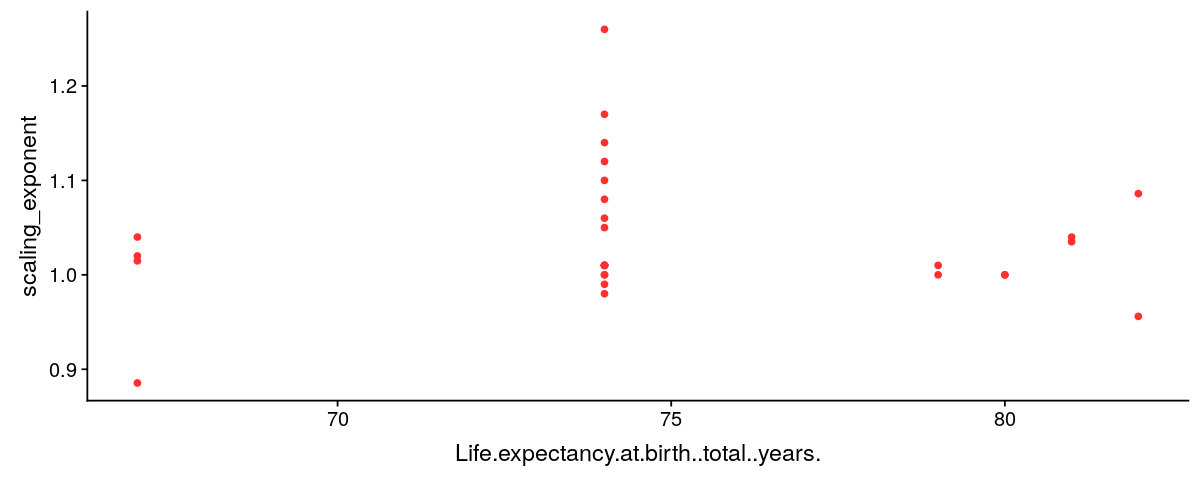

[1] "Merchandise.trade....of.GDP."


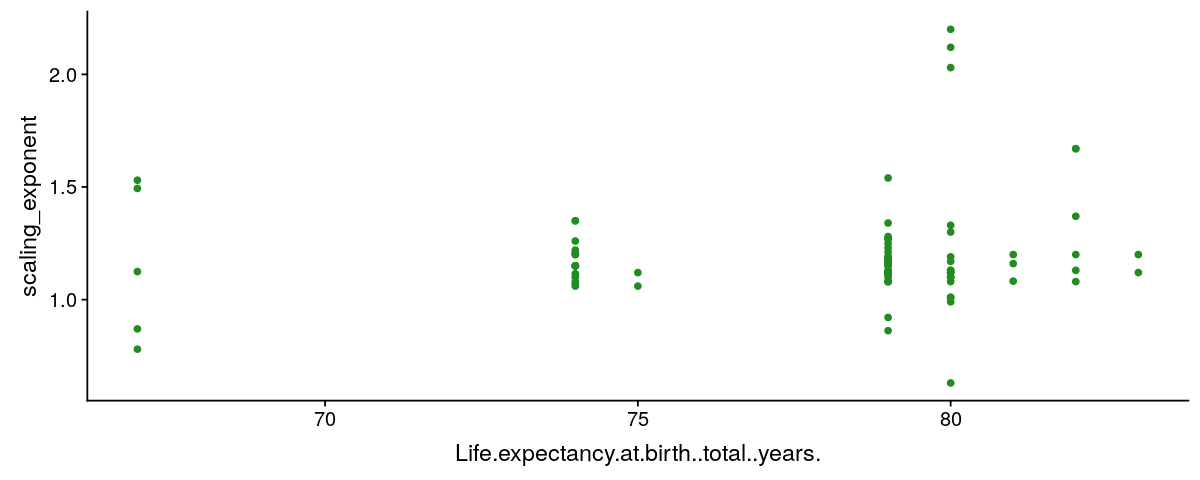

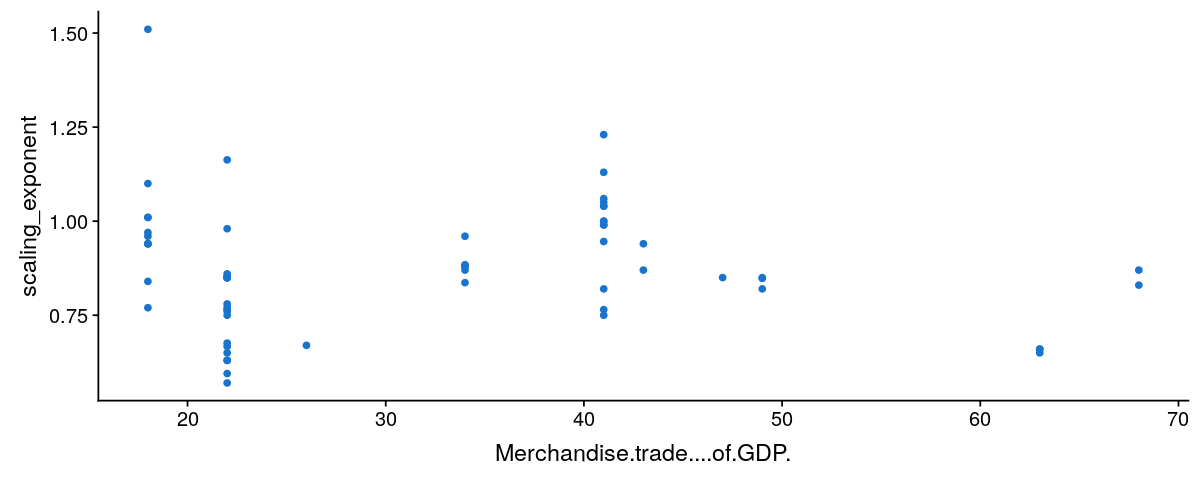

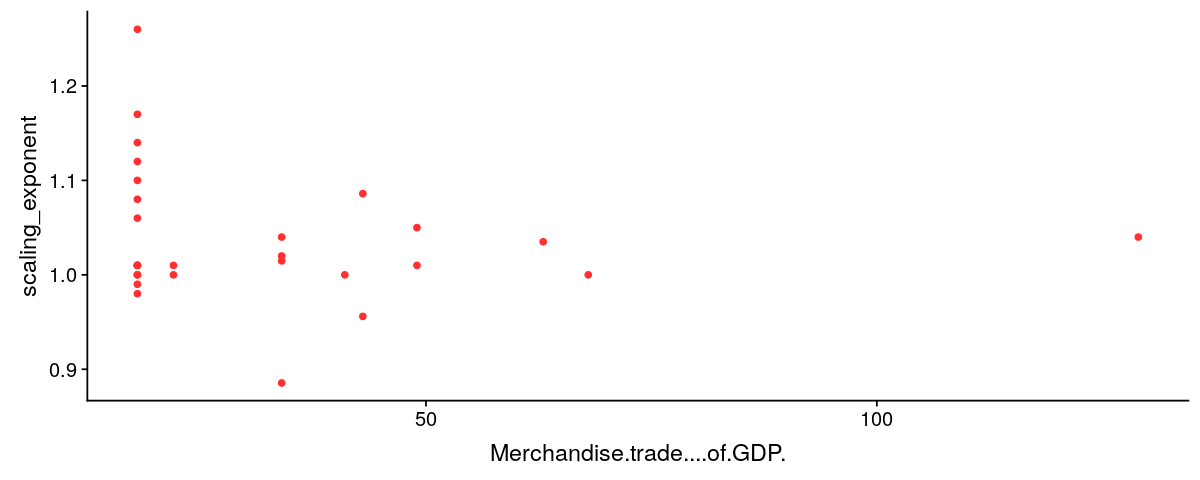

[1] "Military.expenditure....of.GDP."


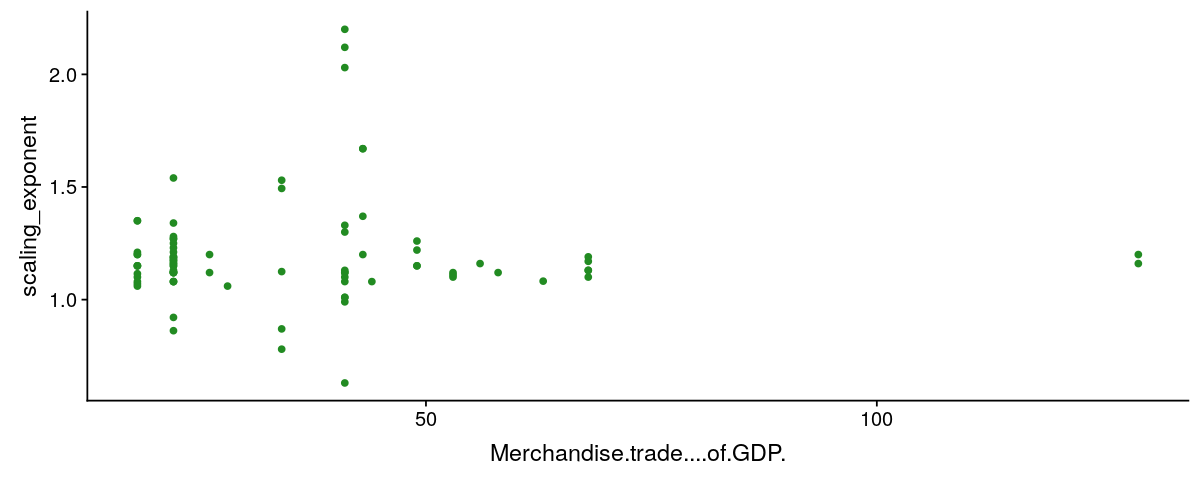

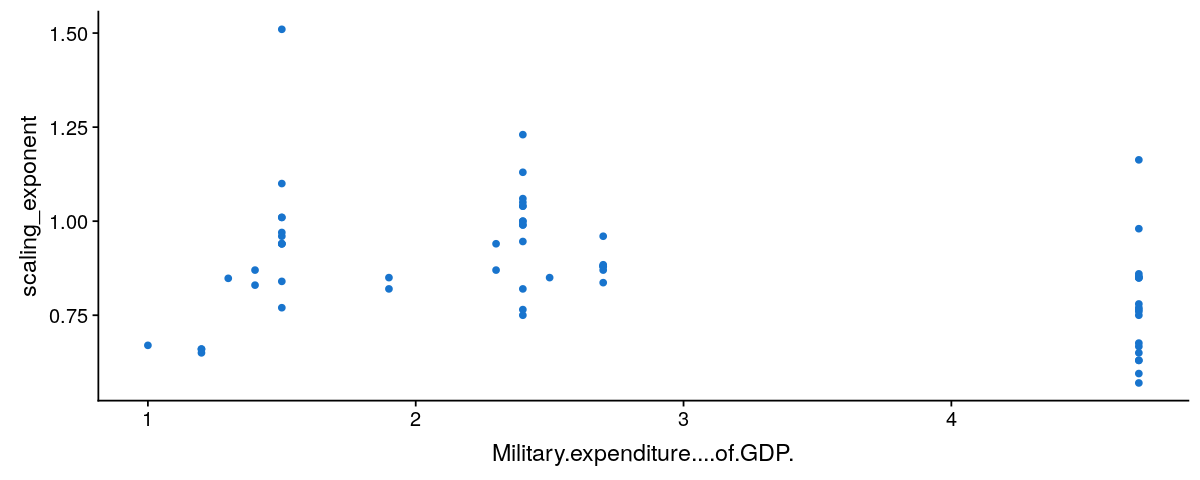

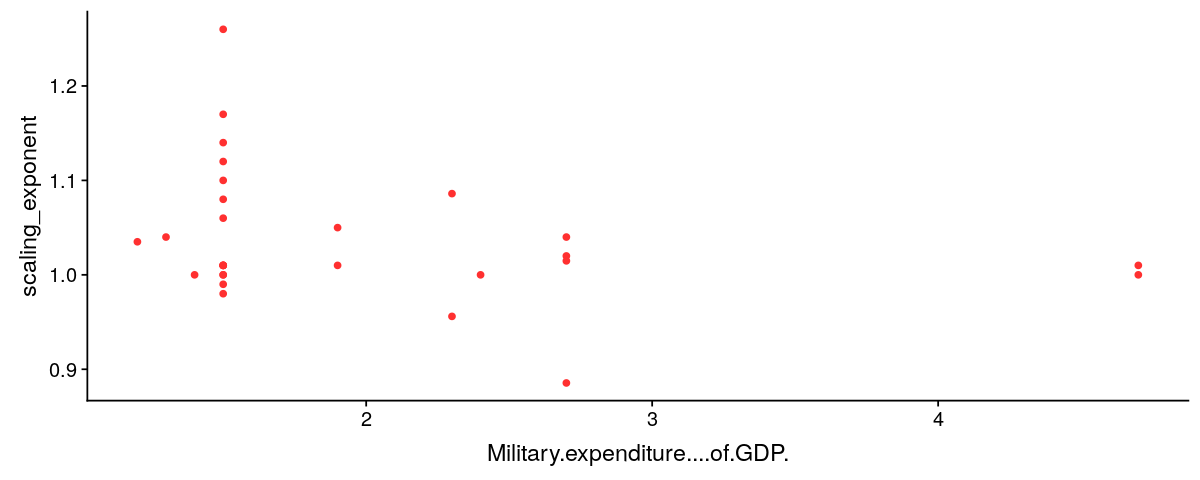

[1] "Mobile.cellular.subscriptions..per.100.people."


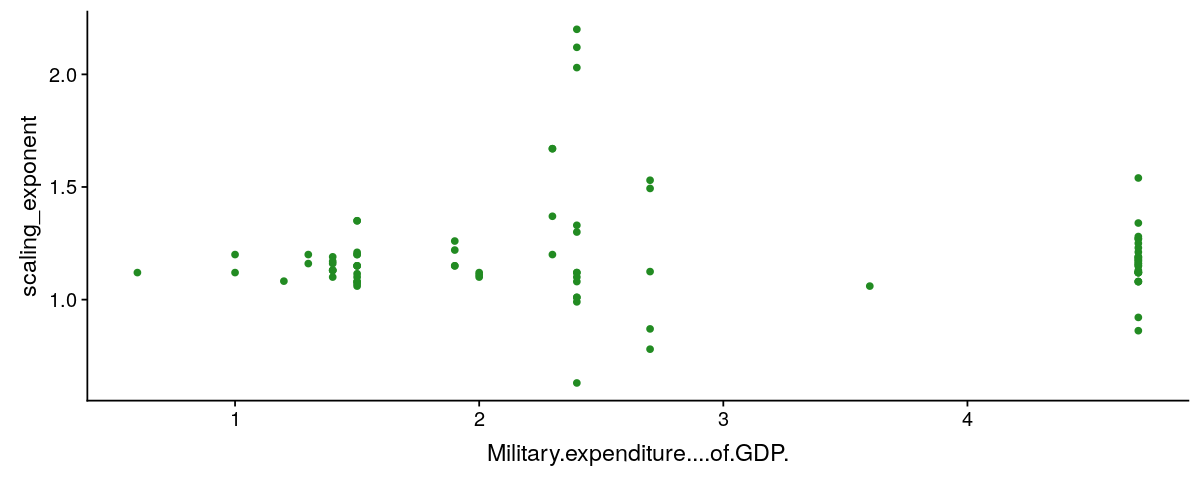

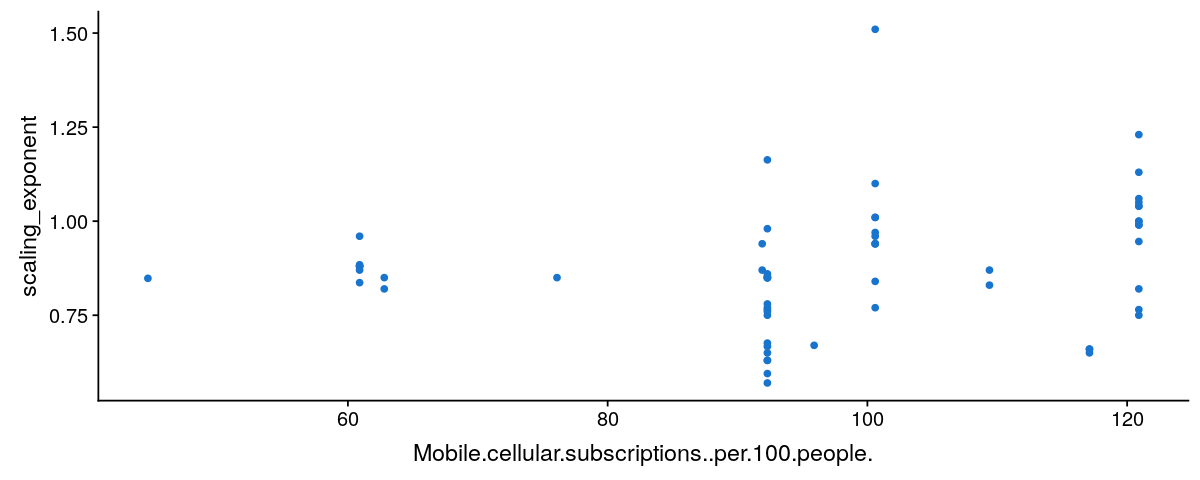

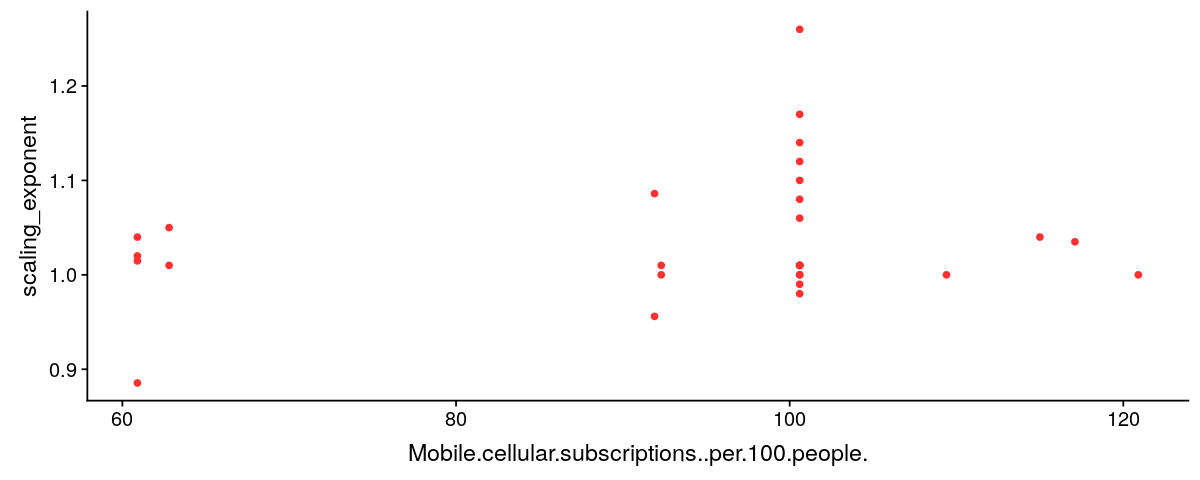

[1] "Mortality.rate..under.5..per.1.000.live.births."


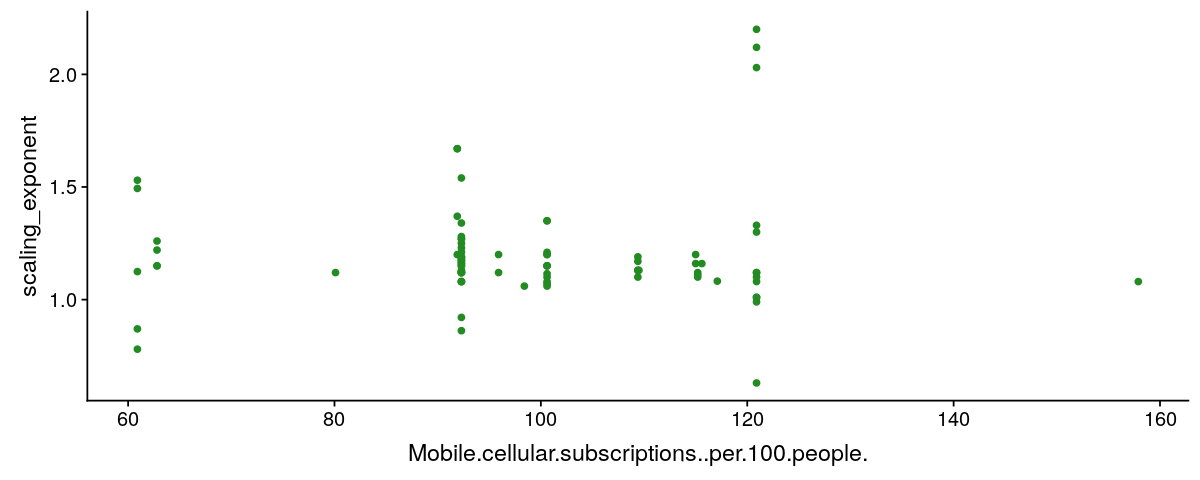

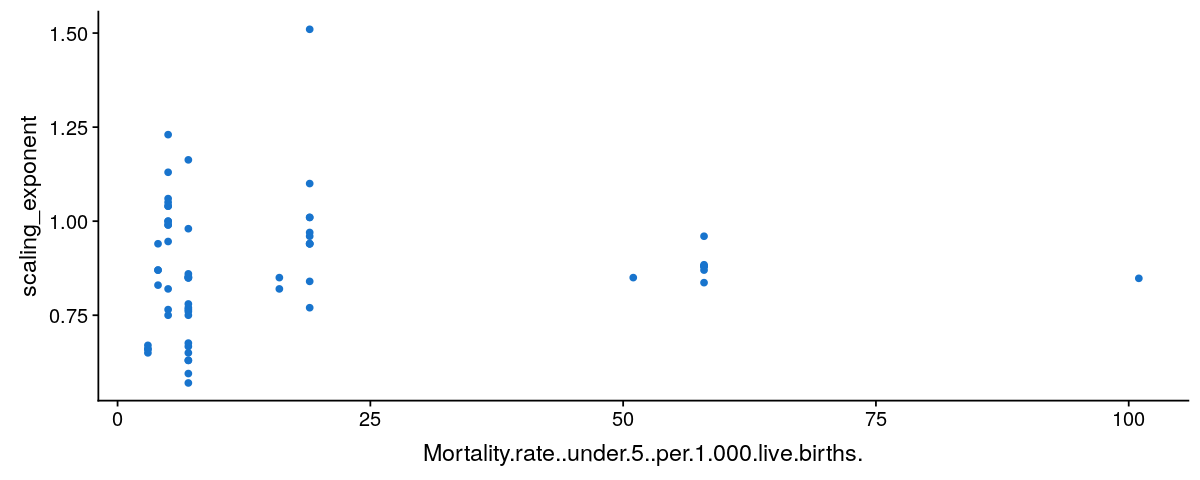

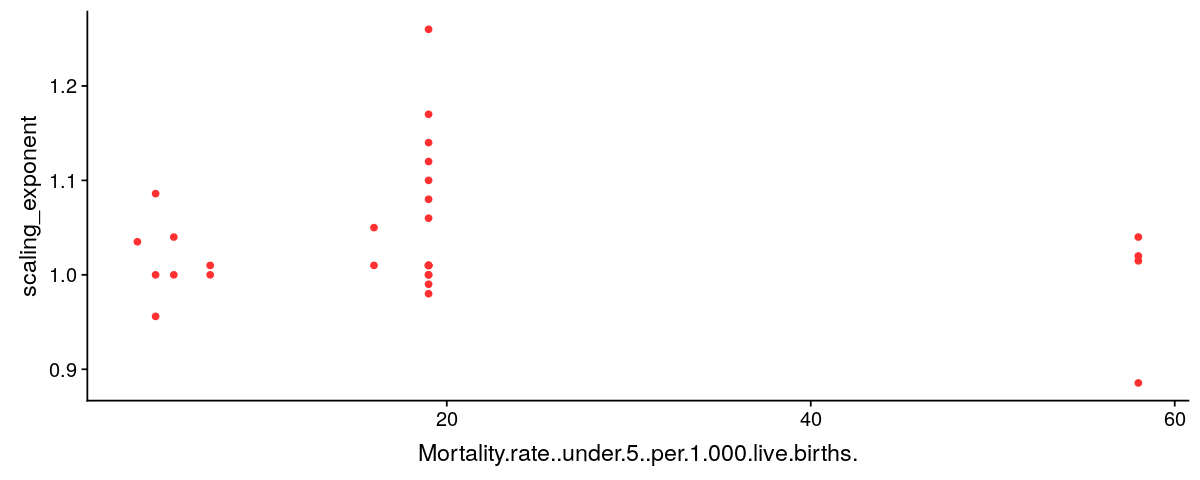

[1] "Net.barter.terms.of.trade.index..2000...100."


Warning message:
“Removed 1 rows containing missing values (geom_point).”

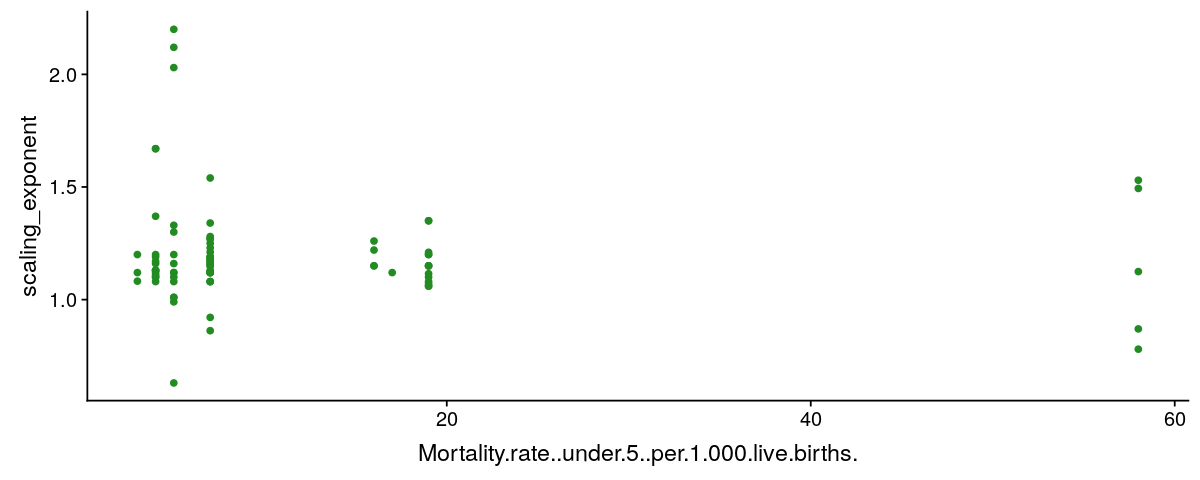

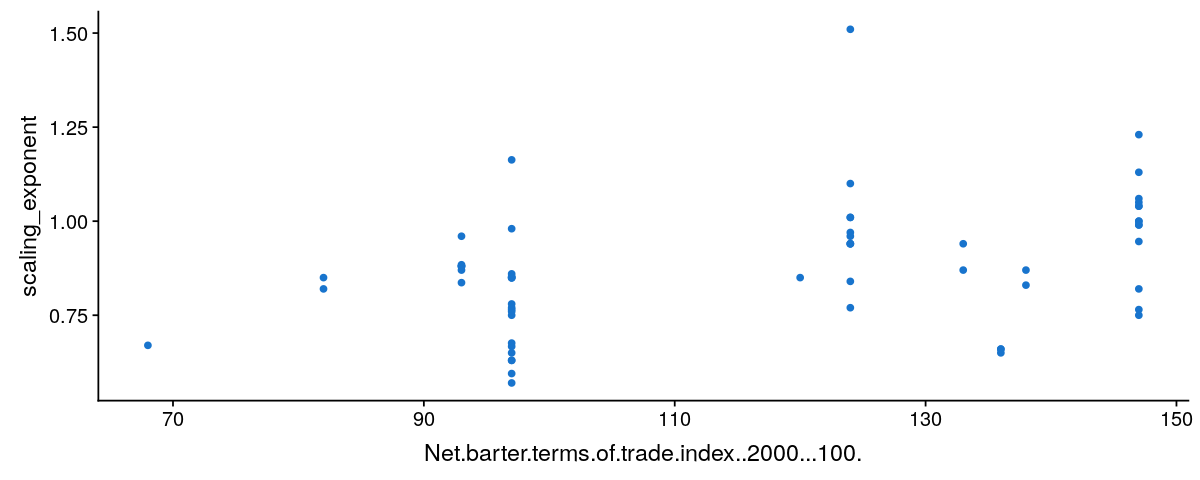

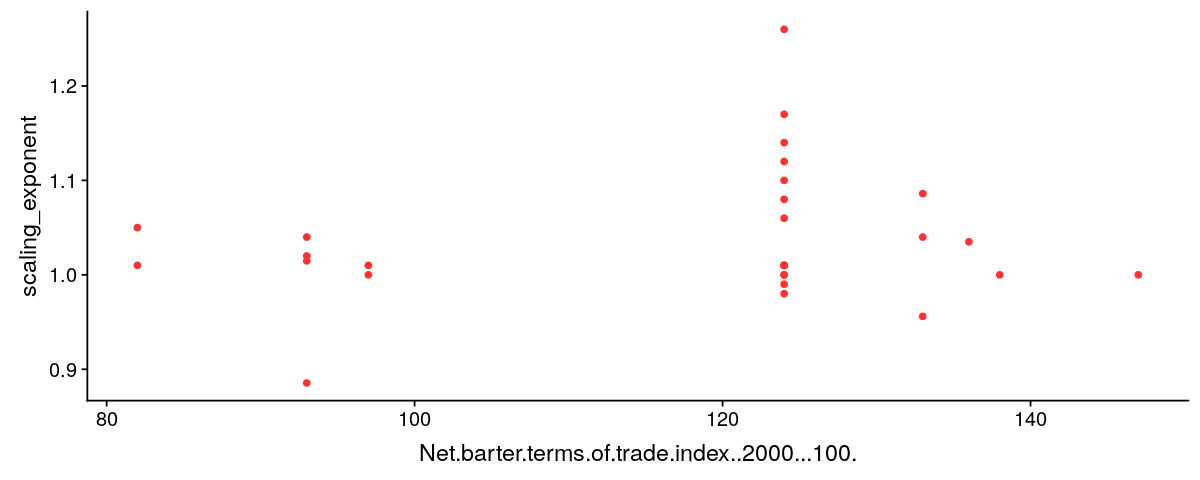

[1] "Net.lending.......net.borrowing........of.GDP."


Warning message:
“Removed 3 rows containing missing values (geom_point).”

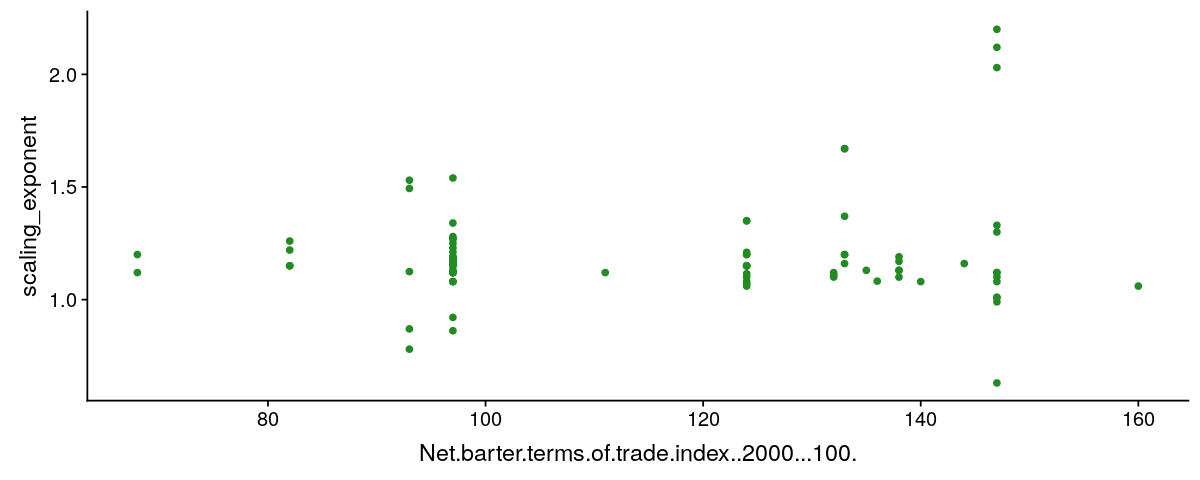

Warning message:
“Removed 2 rows containing missing values (geom_point).”

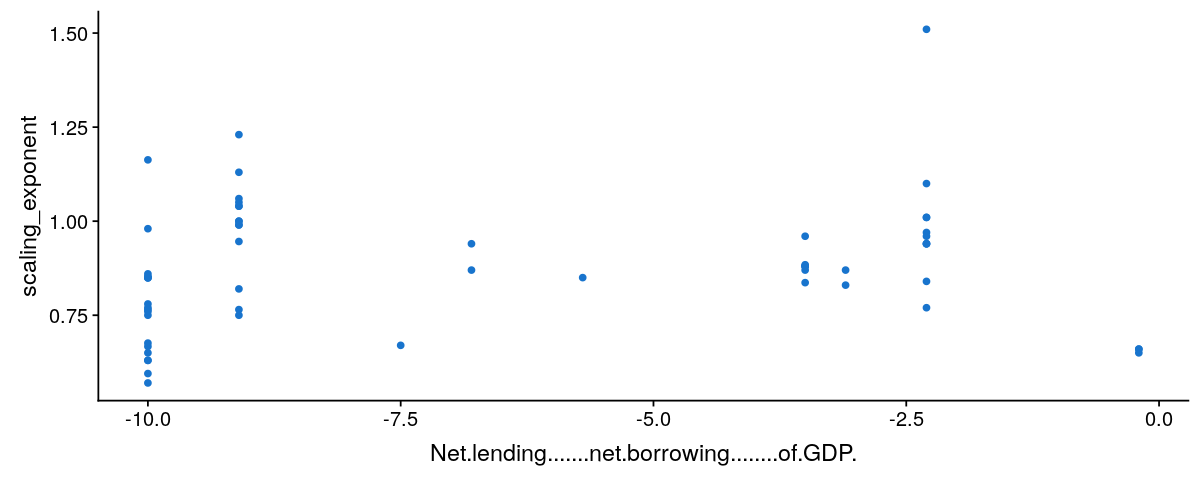

Warning message:
“Removed 4 rows containing missing values (geom_point).”

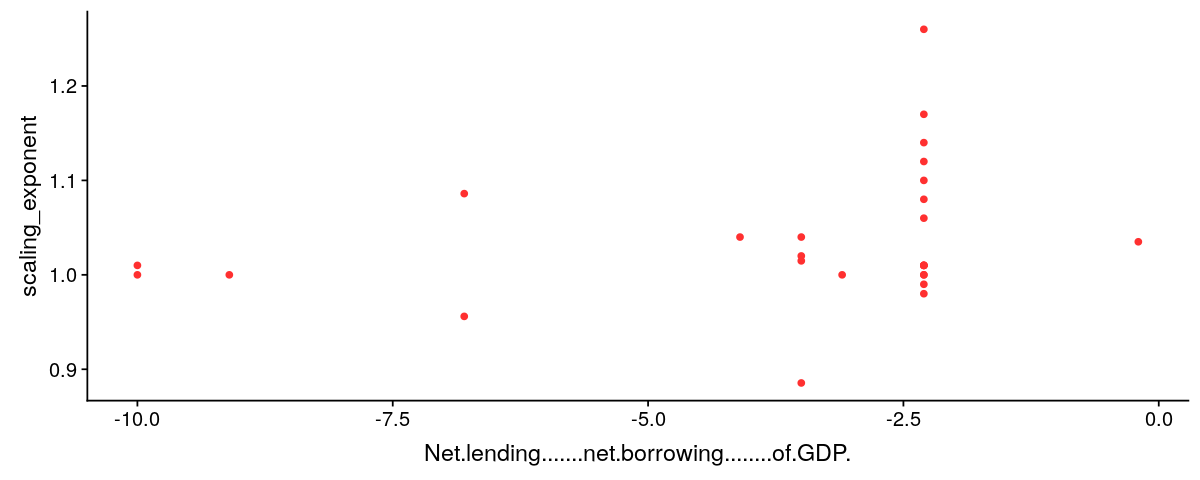

[1] "Net.migration"


Warning message:
“Removed 63 rows containing missing values (geom_point).”

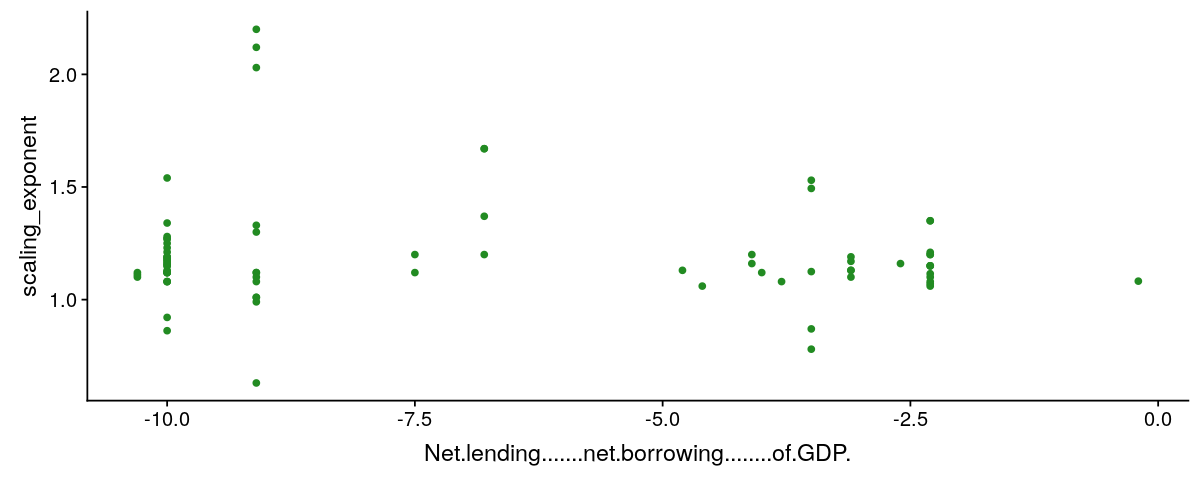

Warning message:
“Removed 29 rows containing missing values (geom_point).”

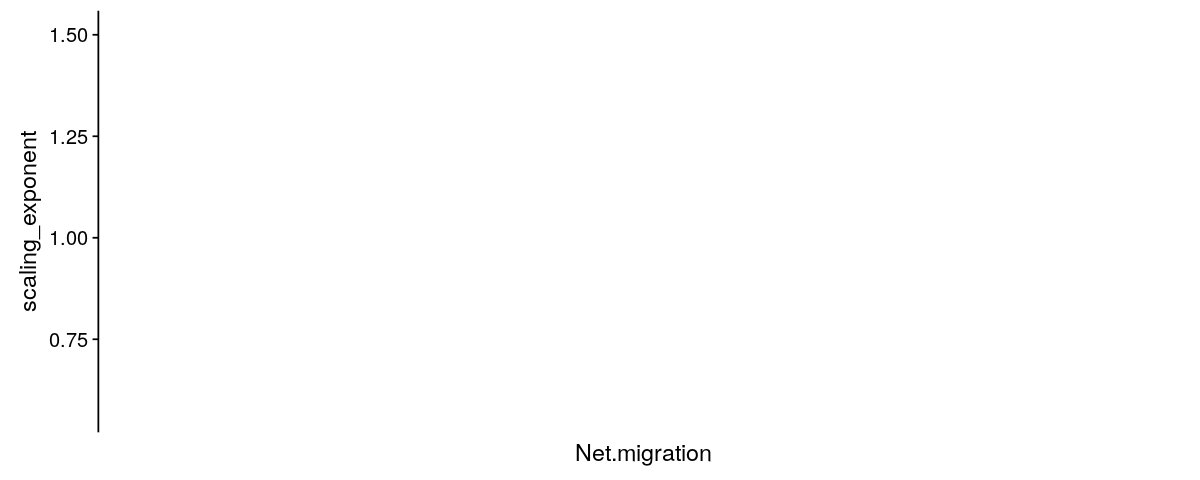

Warning message:
“Removed 86 rows containing missing values (geom_point).”

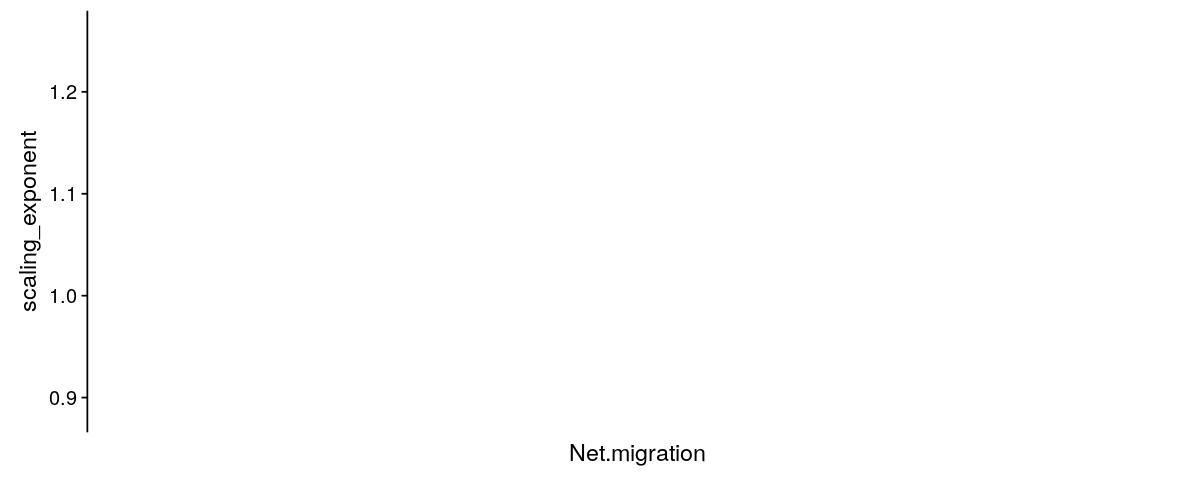

[1] "Net.official.development.assistance.received..current.US.."


Warning message:
“Removed 41 rows containing missing values (geom_point).”

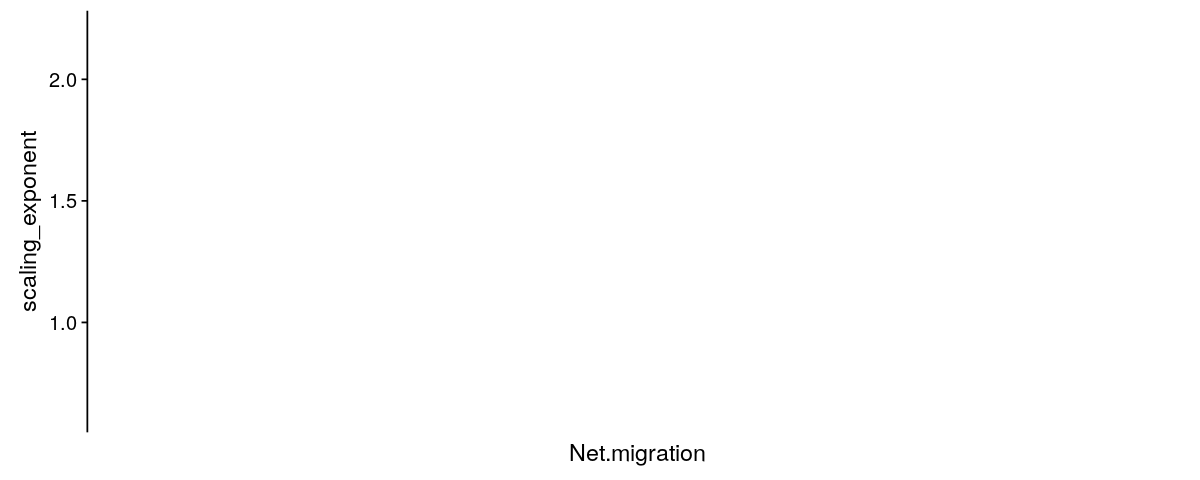

Warning message:
“Removed 8 rows containing missing values (geom_point).”

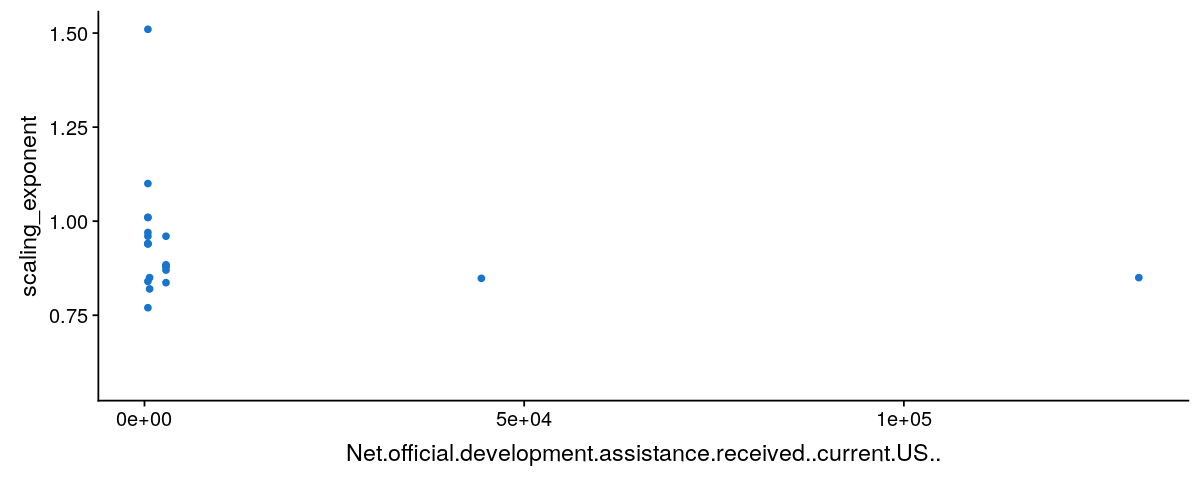

Warning message:
“Removed 62 rows containing missing values (geom_point).”

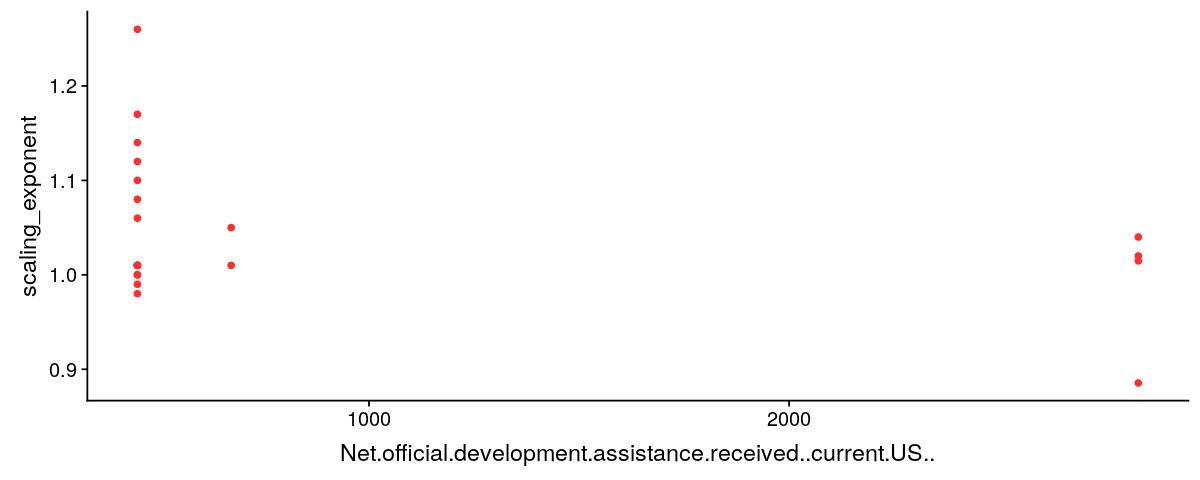

[1] "Personal.remittances..received..current.US.."


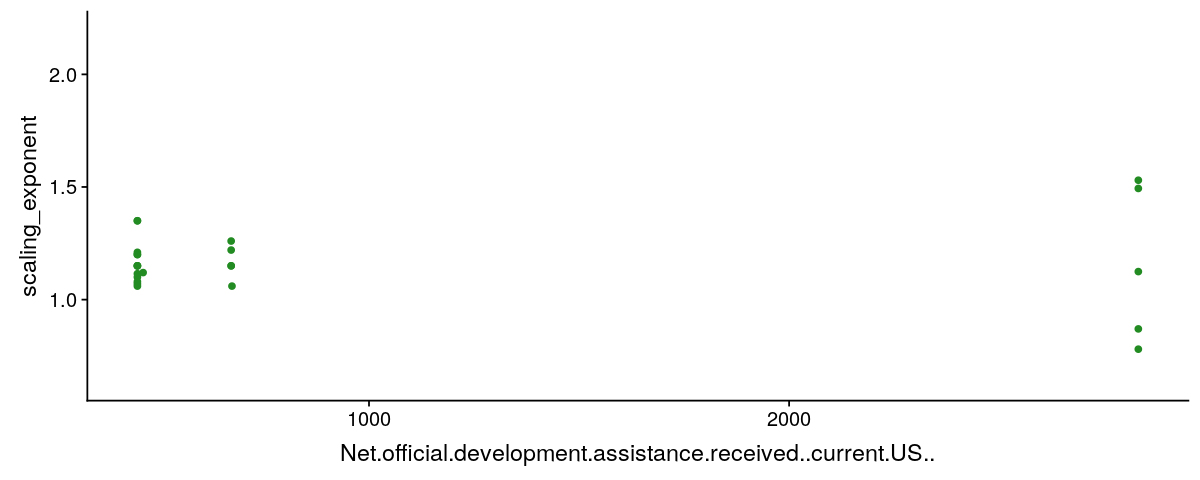

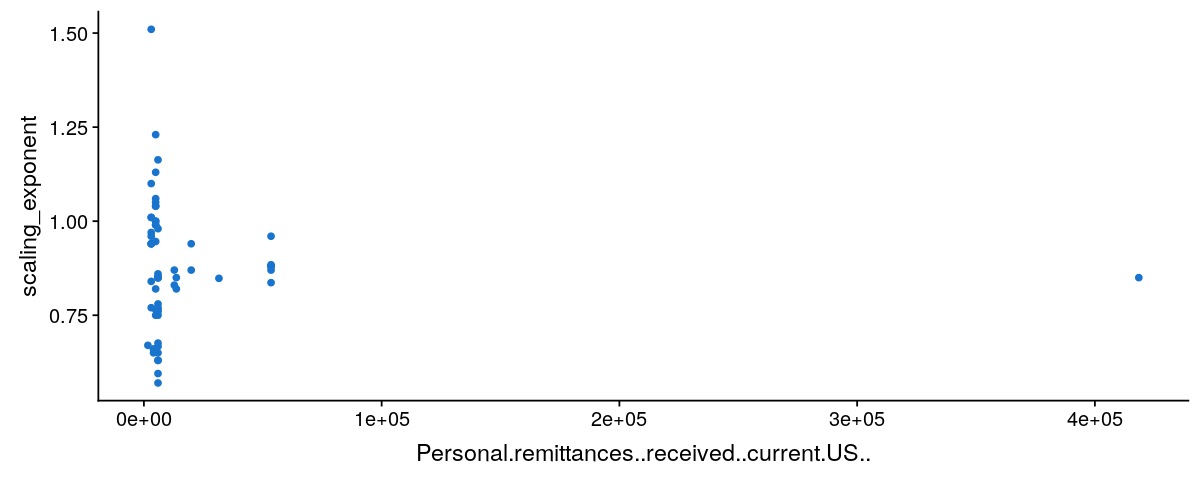

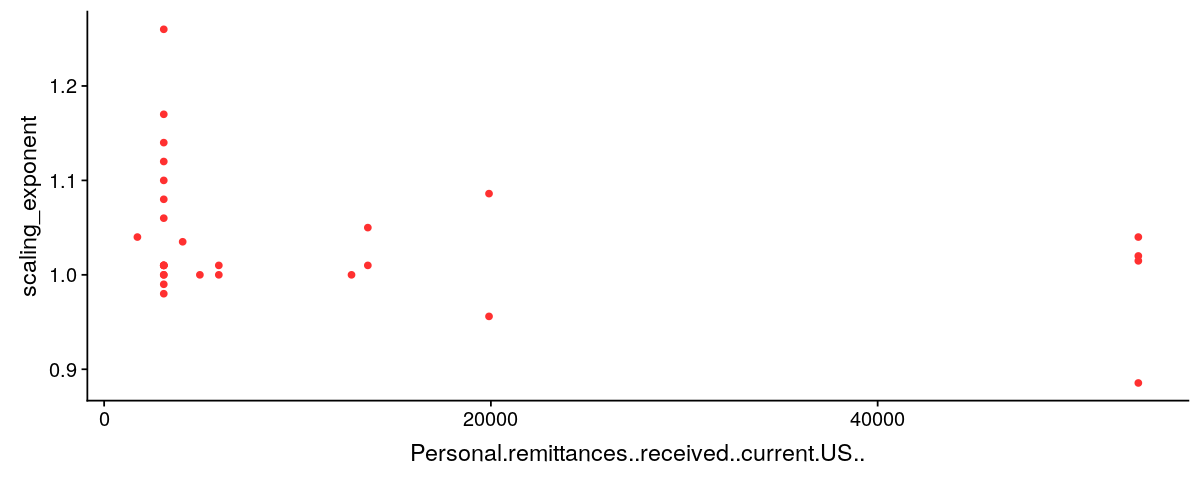

[1] "Population.density..people.per.sq..km.of.land.area."


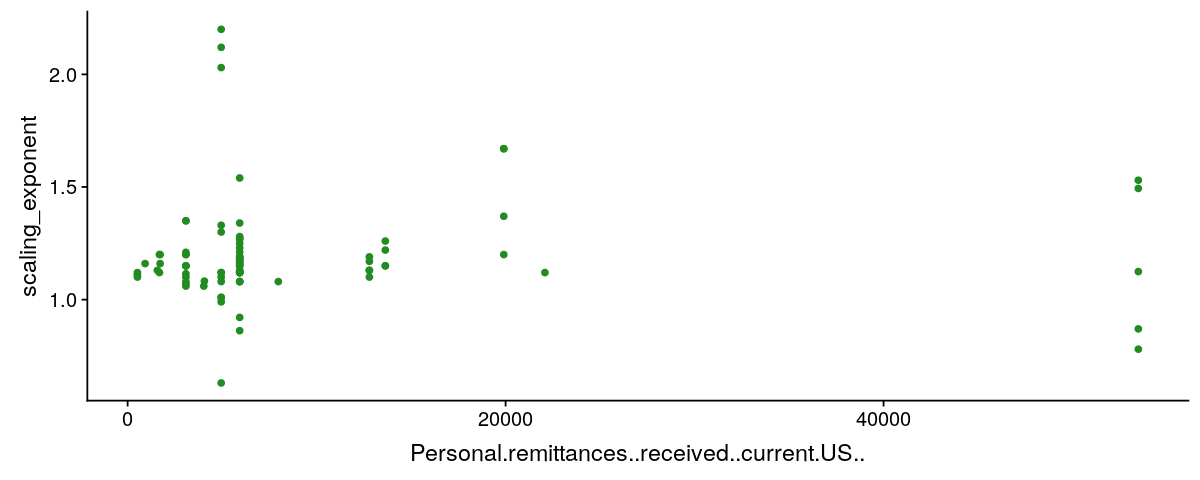

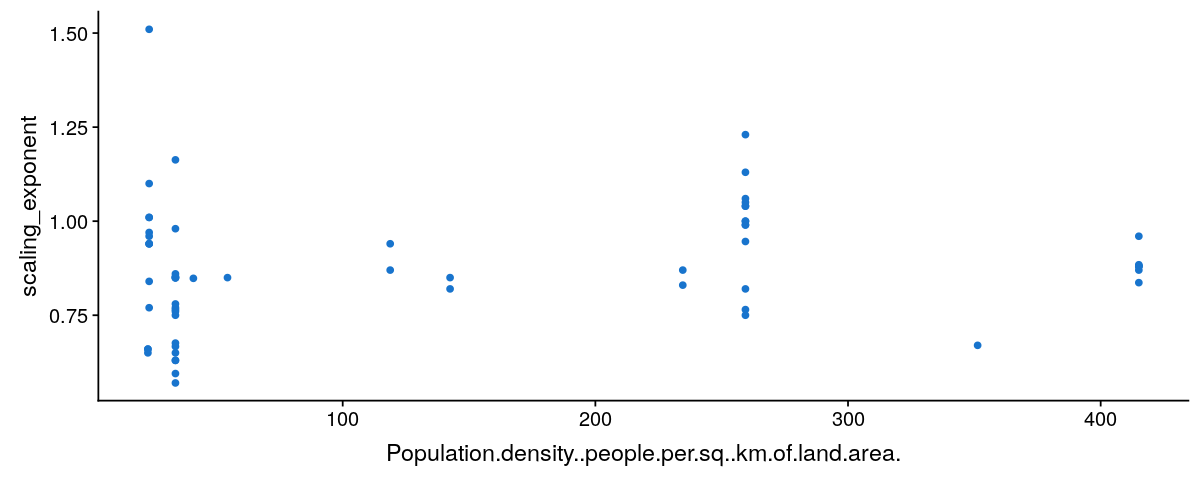

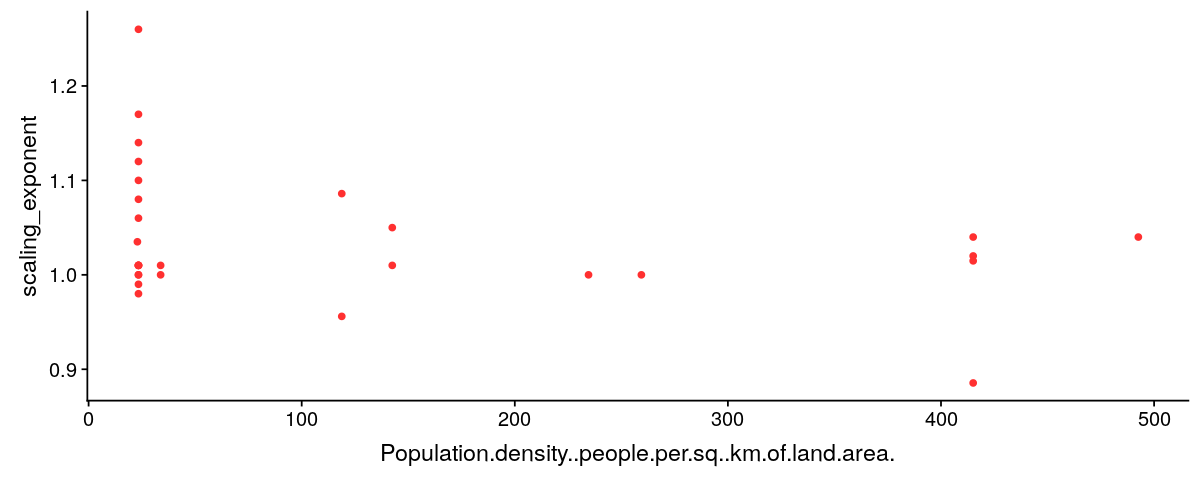

[1] "Population.growth..annual..."


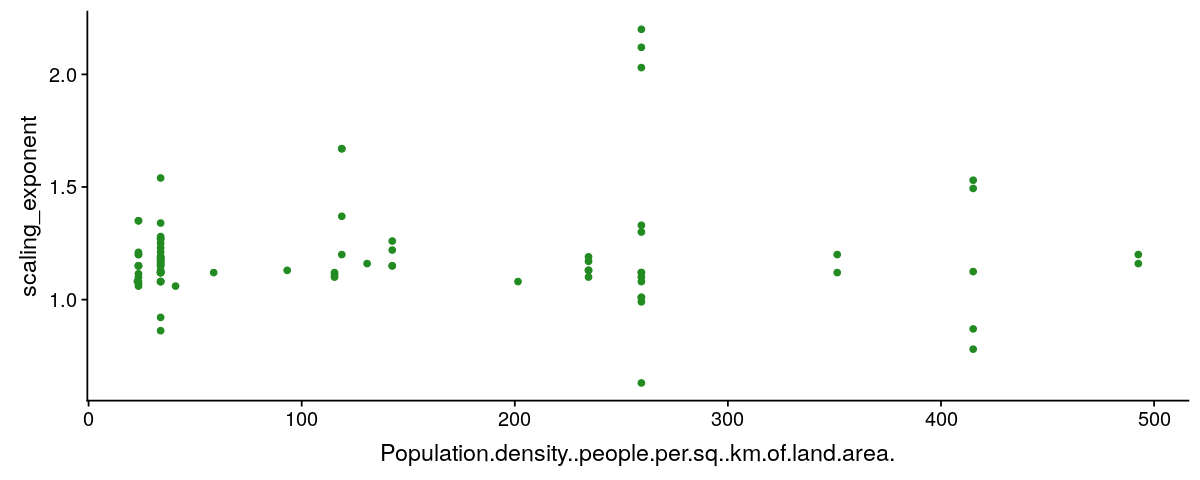

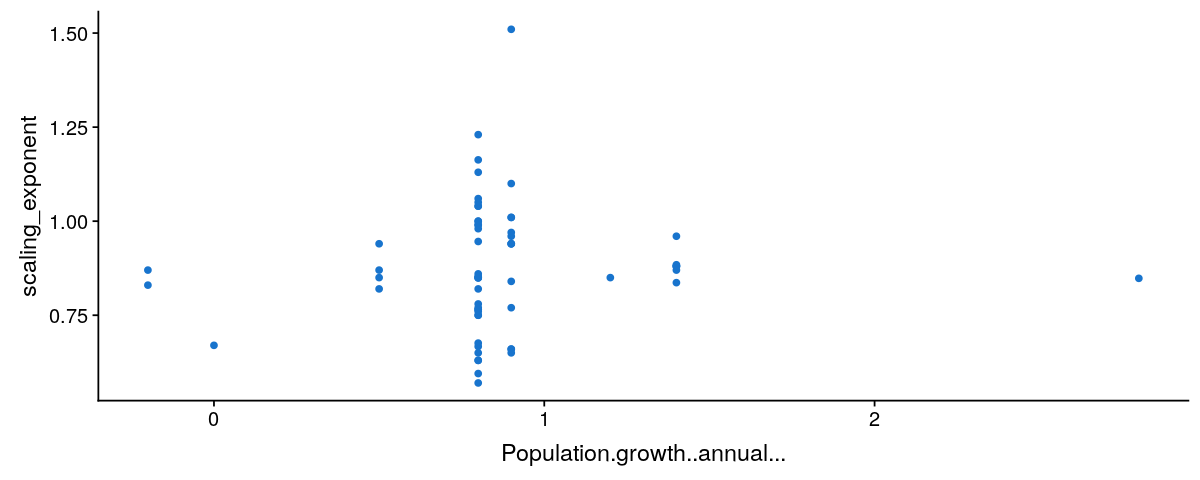

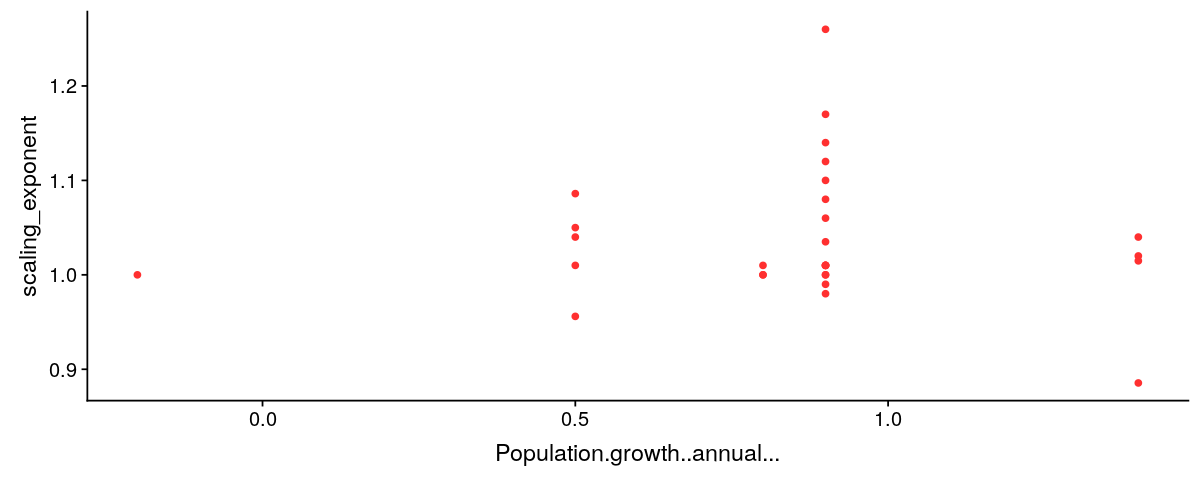

[1] "Population..total"


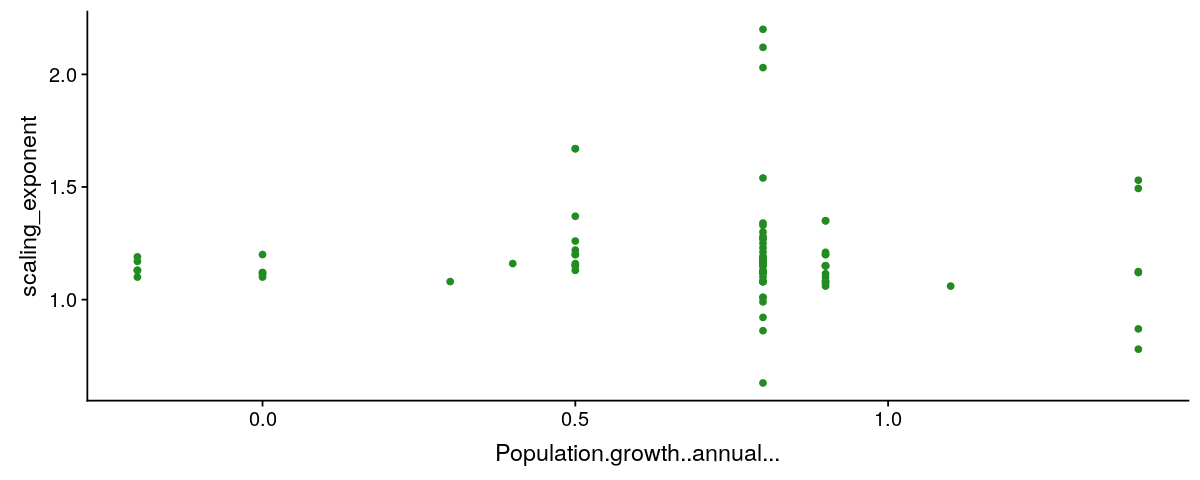

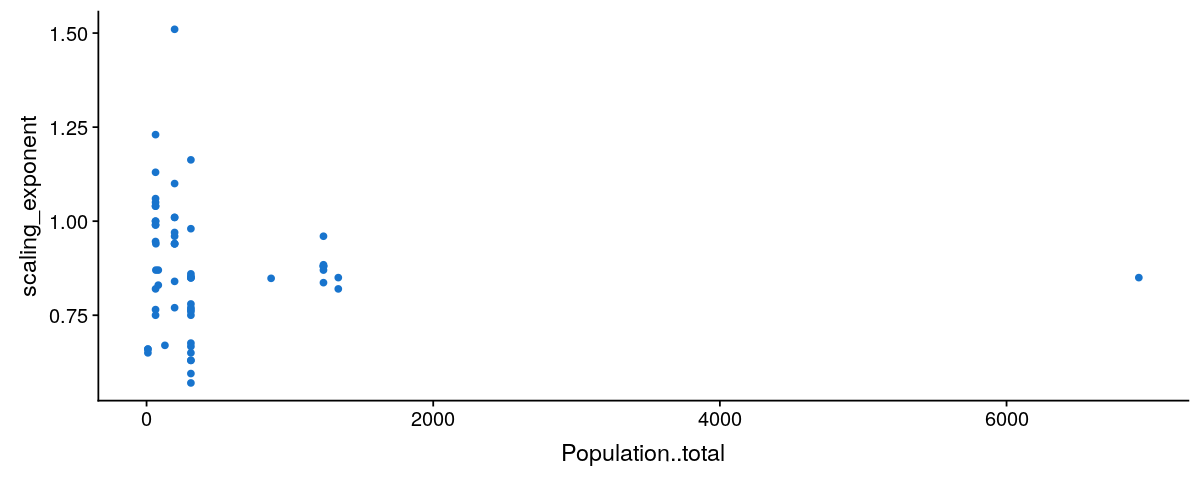

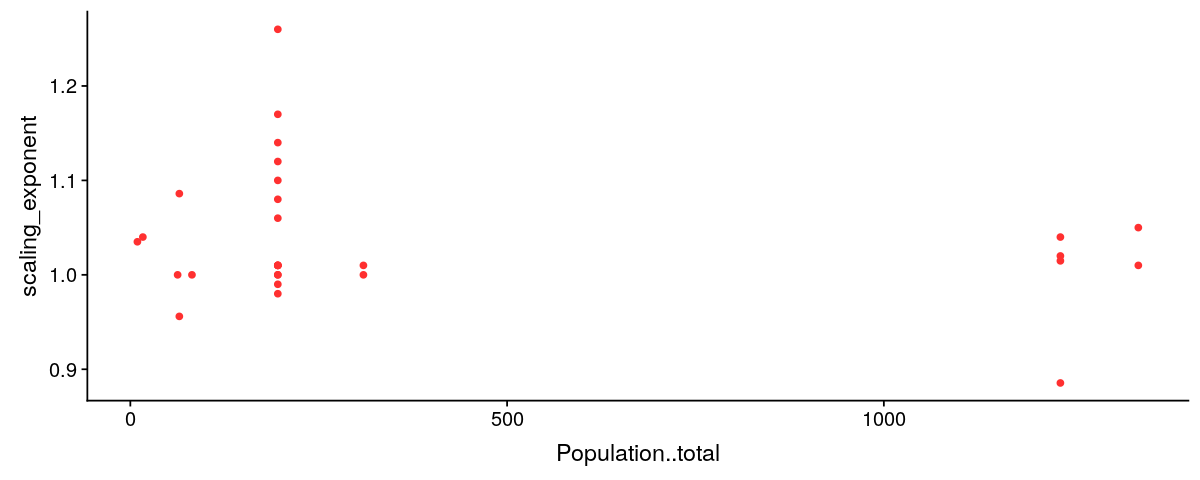

[1] "Poverty.headcount.ratio.at..1.90.a.day..2011.PPP.....of.population."


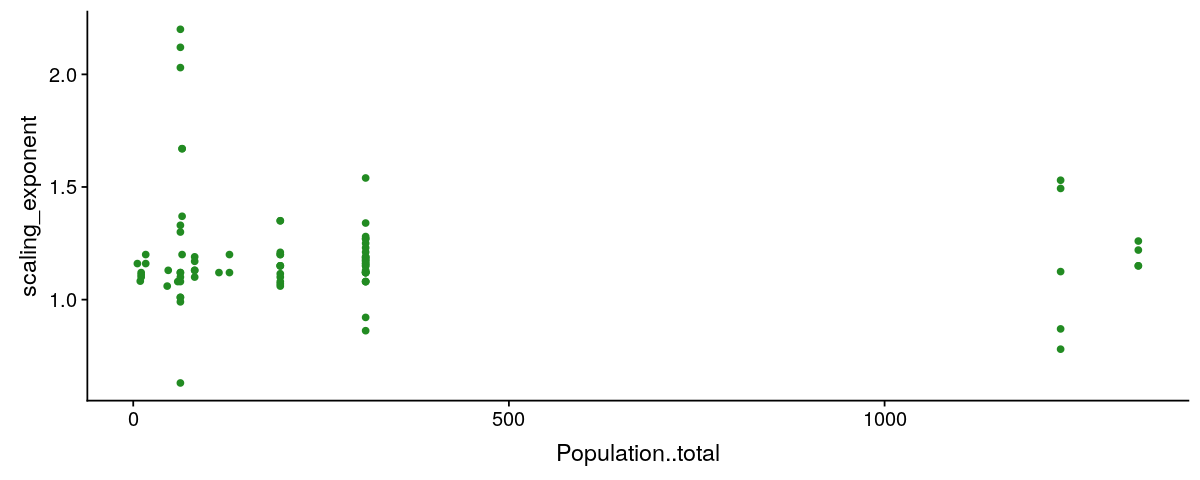

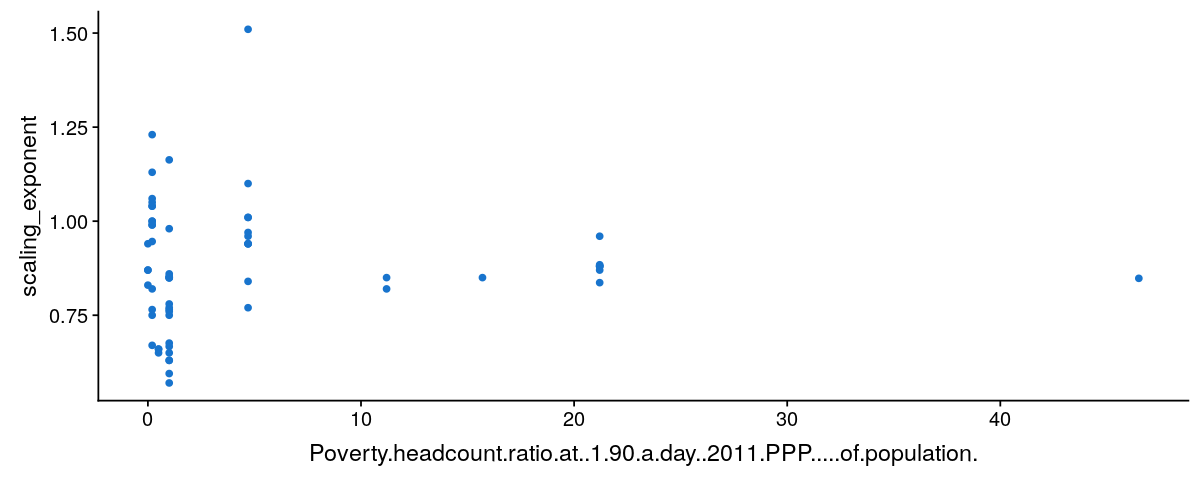

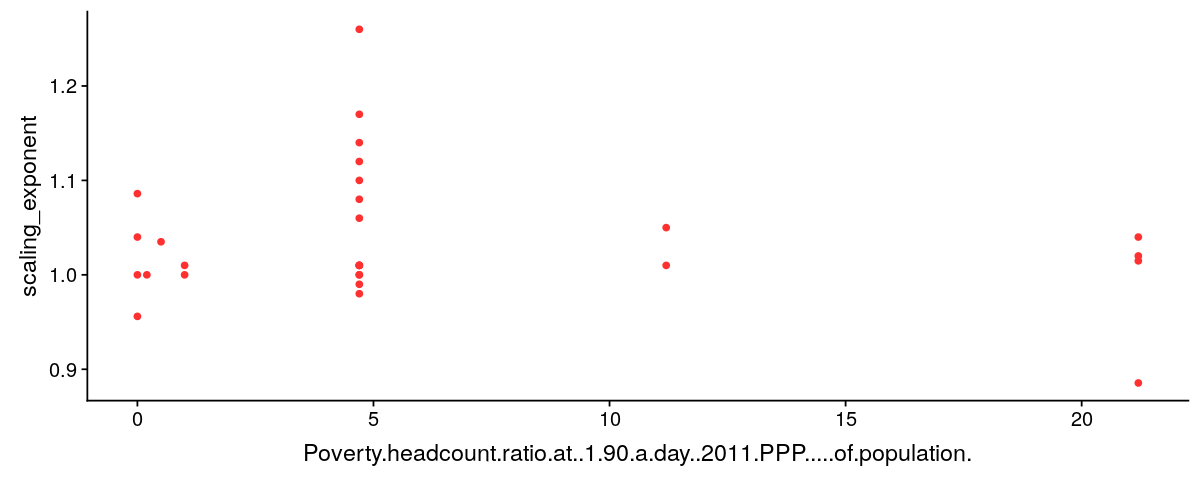

[1] "Poverty.headcount.ratio.at.national.poverty.lines....of.population."


Warning message:
“Removed 54 rows containing missing values (geom_point).”

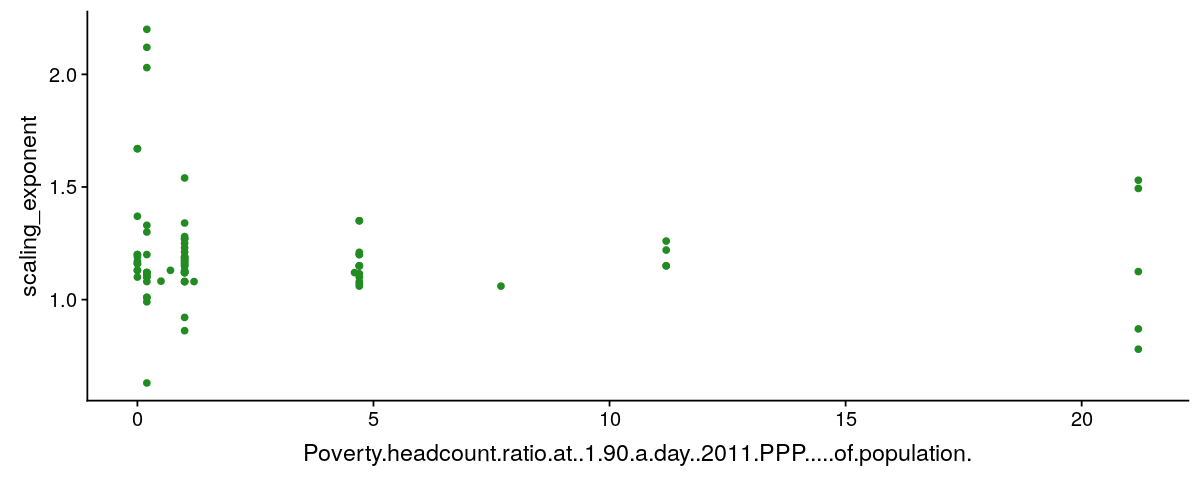

Warning message:
“Removed 23 rows containing missing values (geom_point).”

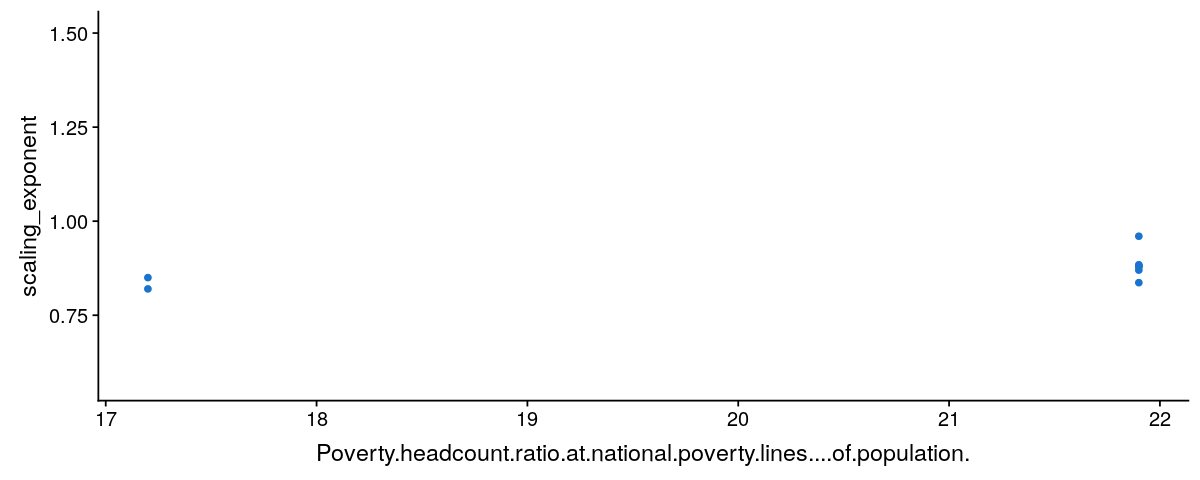

Warning message:
“Removed 76 rows containing missing values (geom_point).”

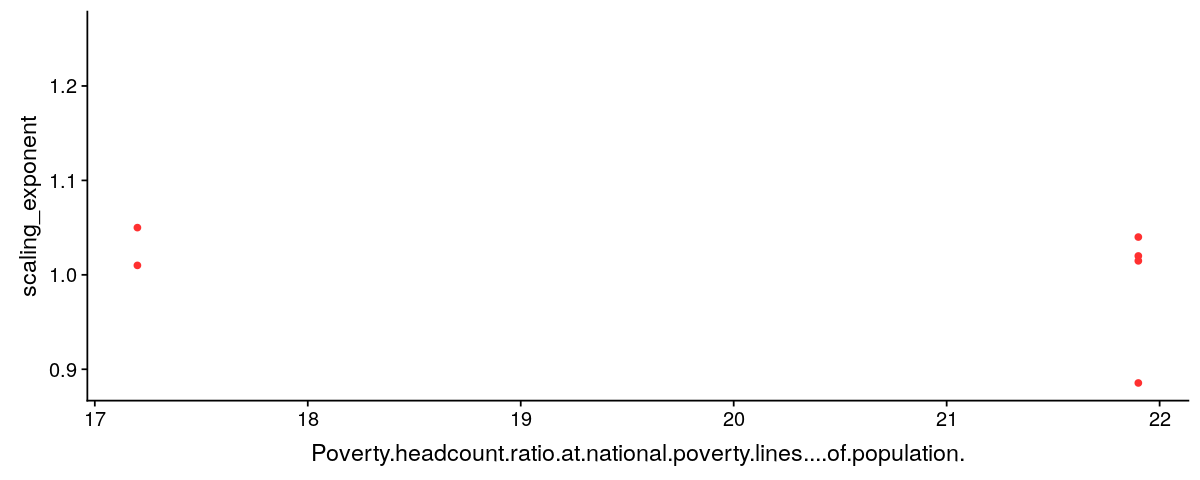

[1] "Prevalence.of.HIV..total....of.population.ages.15.49."


Warning message:
“Removed 26 rows containing missing values (geom_point).”

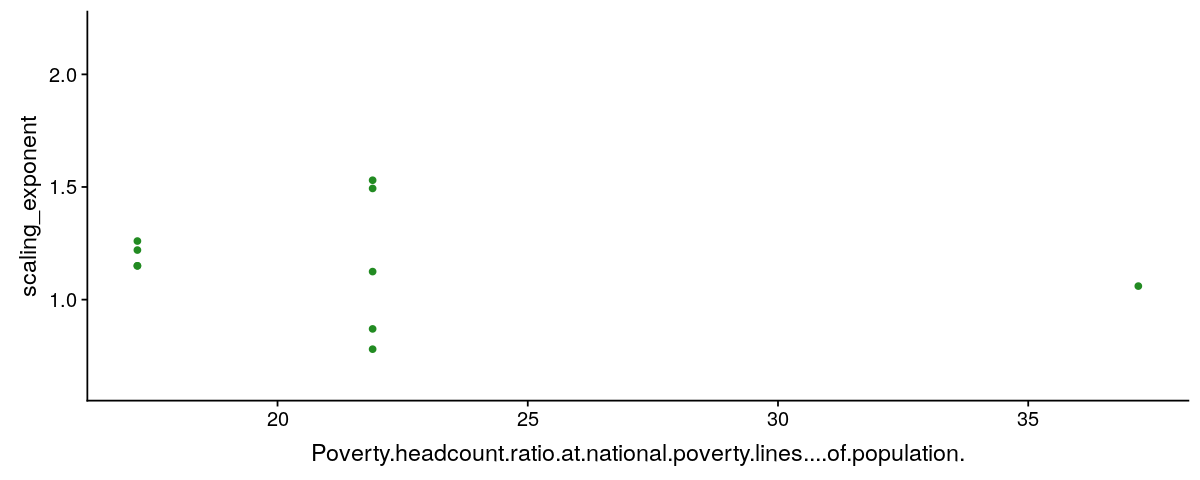

Warning message:
“Removed 8 rows containing missing values (geom_point).”

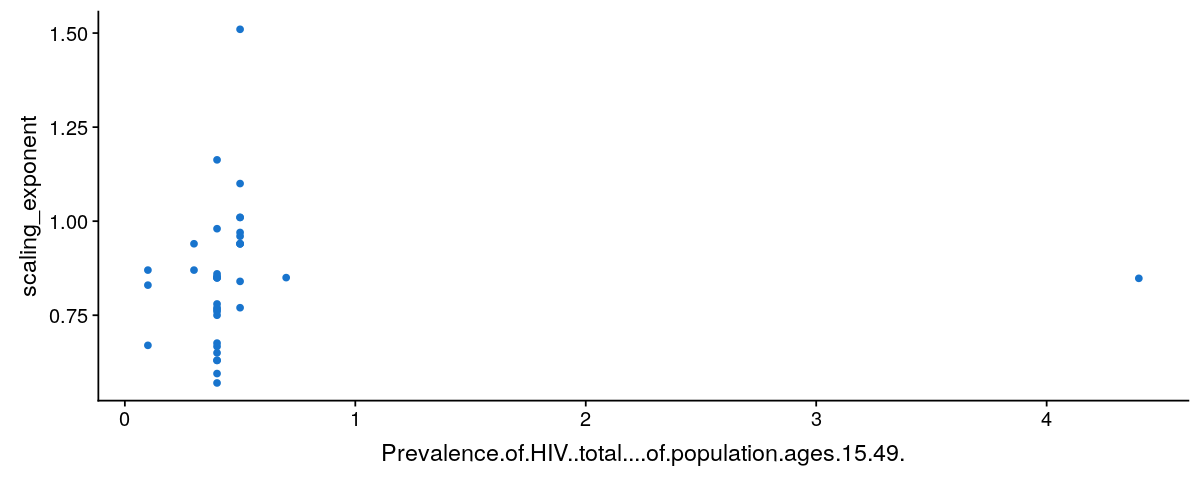

Warning message:
“Removed 23 rows containing missing values (geom_point).”

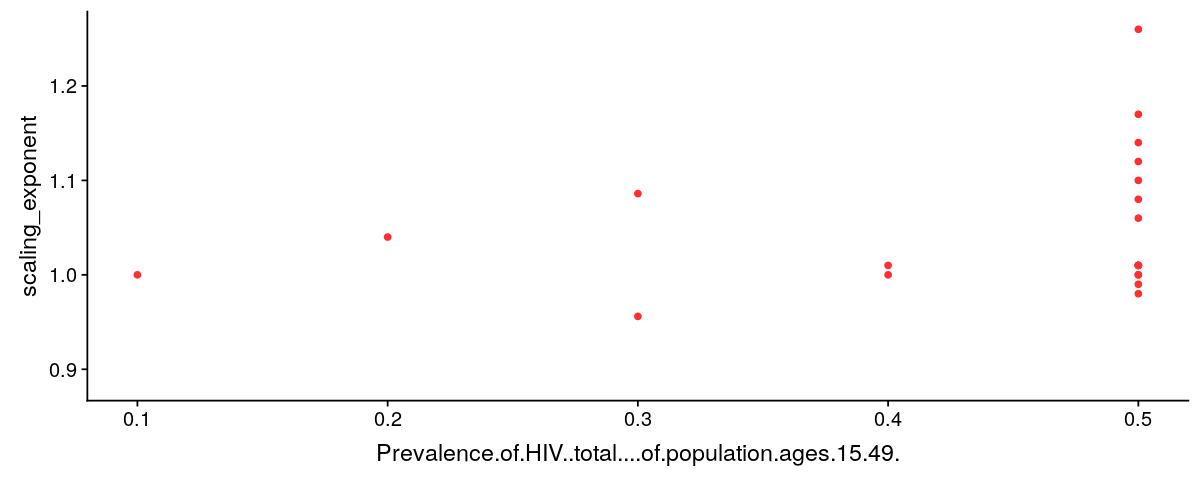

[1] "Prevalence.of.underweight..weight.for.age....of.children.under.5."


Warning message:
“Removed 28 rows containing missing values (geom_point).”

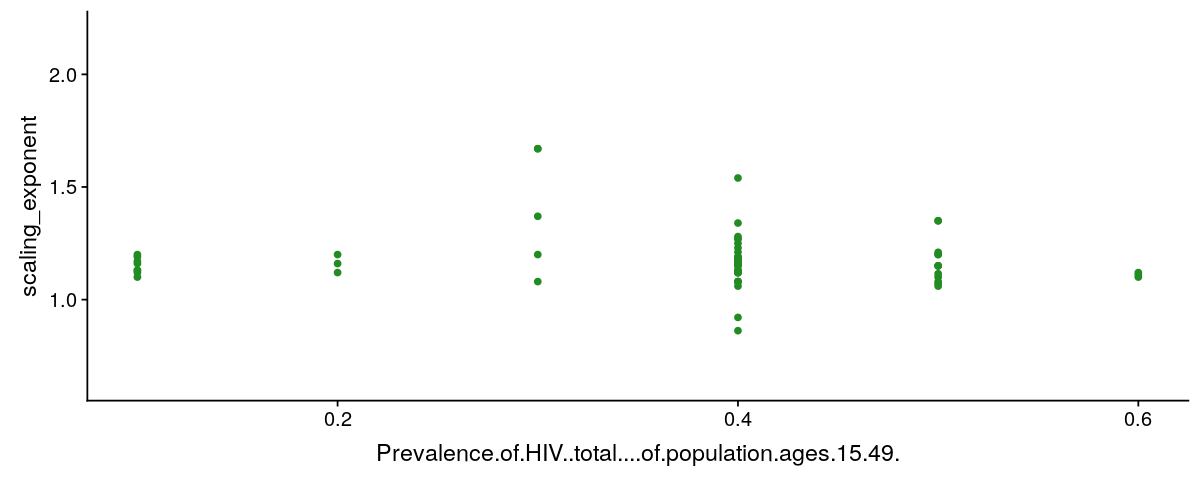

Warning message:
“Removed 10 rows containing missing values (geom_point).”

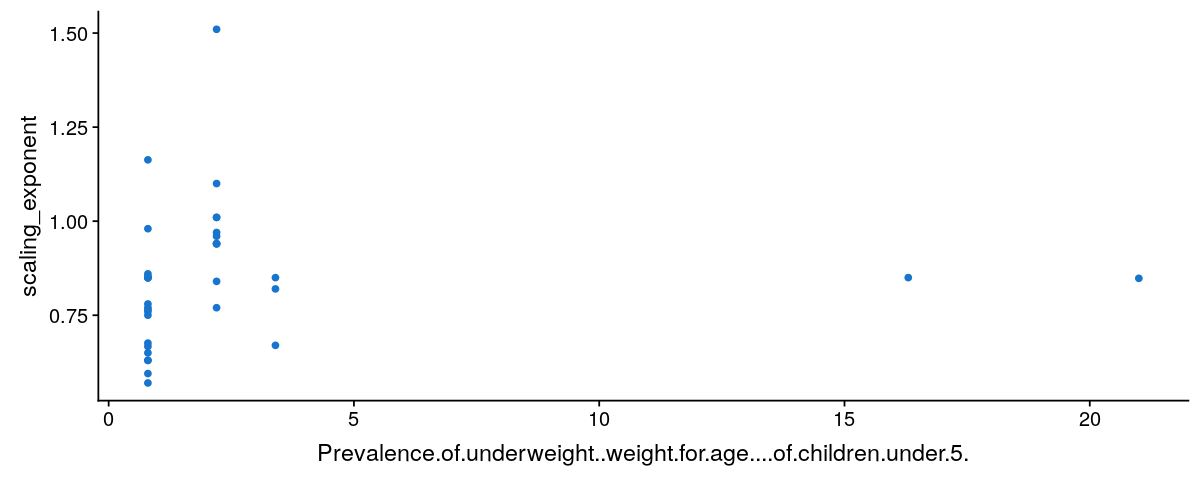

Warning message:
“Removed 36 rows containing missing values (geom_point).”

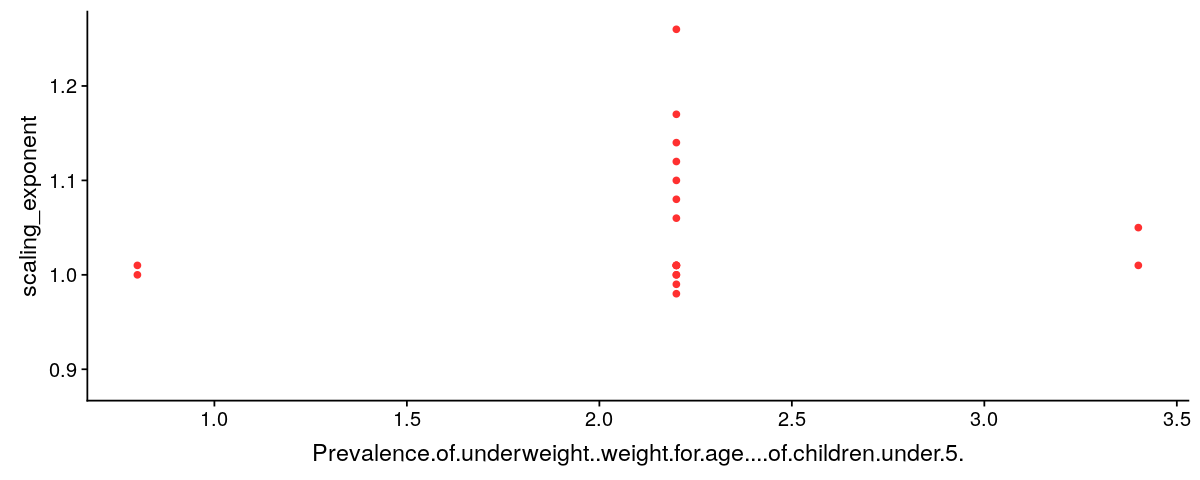

[1] "Primary.completion.rate..total....of.relevant.age.group."


Warning message:
“Removed 56 rows containing missing values (geom_point).”

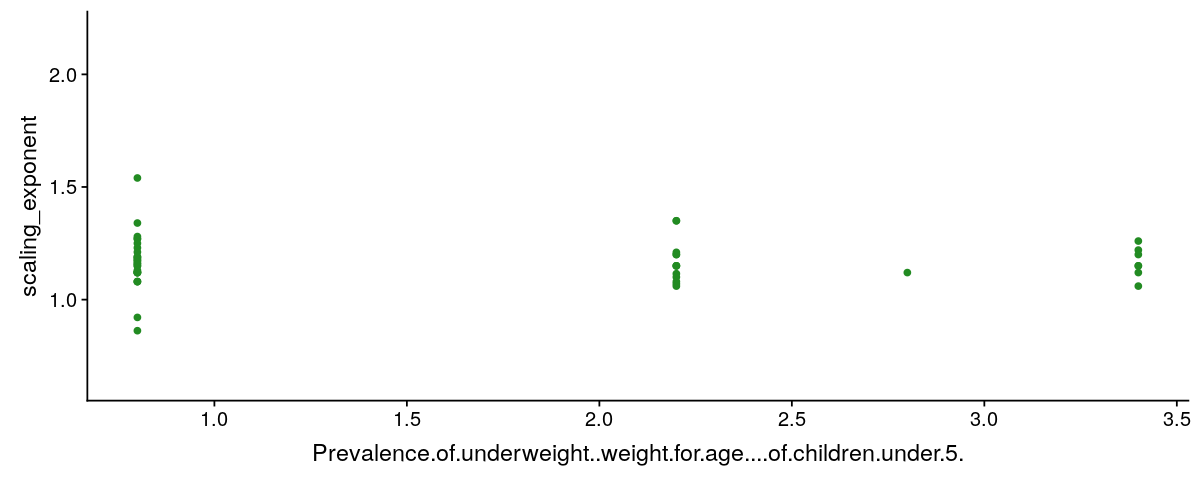

Warning message:
“Removed 27 rows containing missing values (geom_point).”

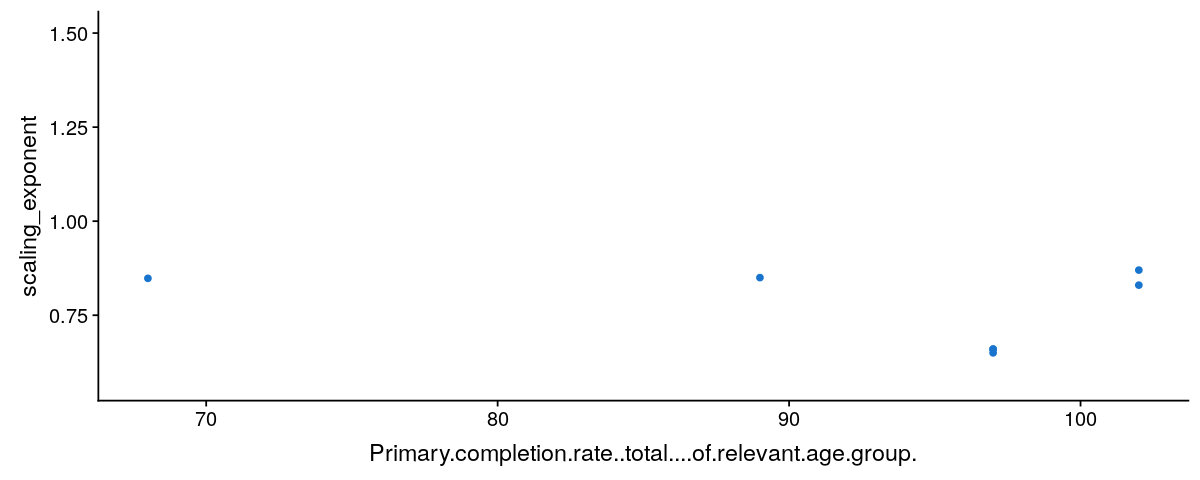

Warning message:
“Removed 75 rows containing missing values (geom_point).”

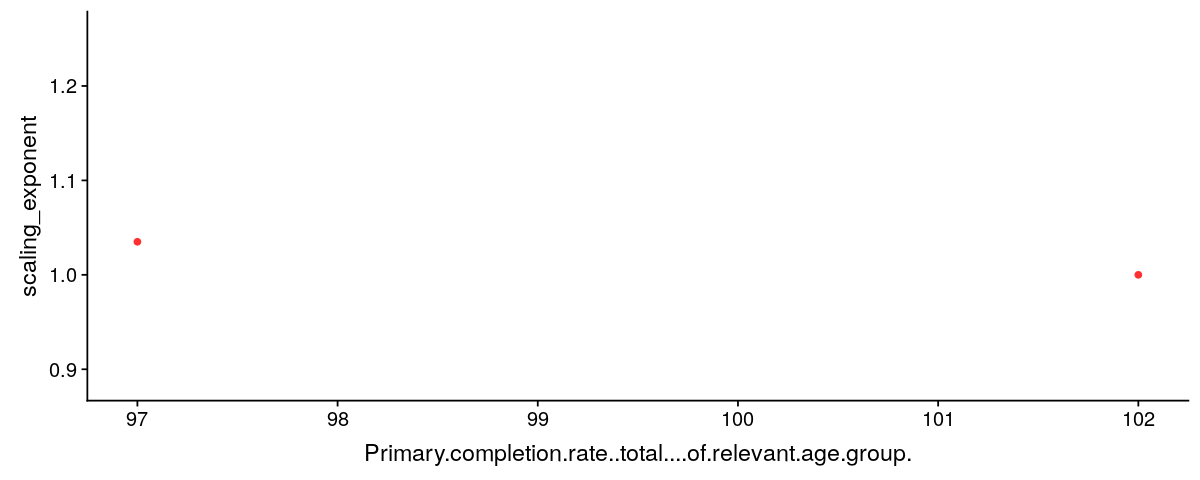

[1] "Revenue..excluding.grants....of.GDP."


Warning message:
“Removed 1 rows containing missing values (geom_point).”

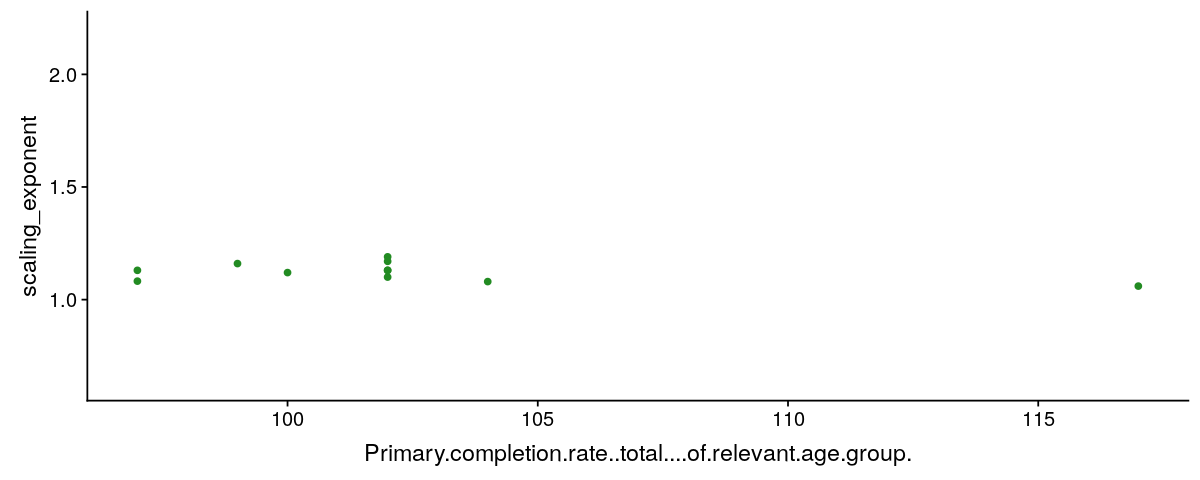

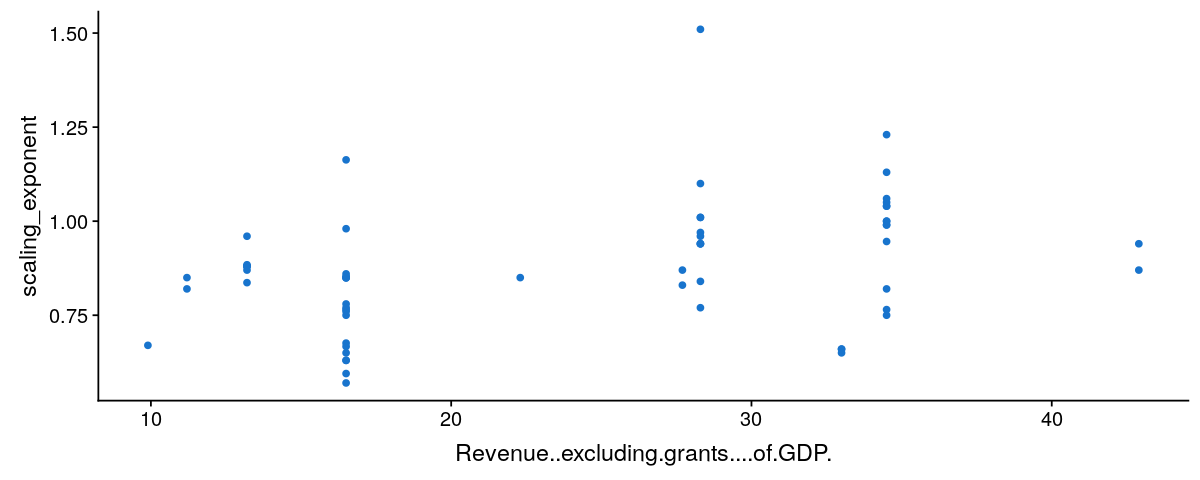

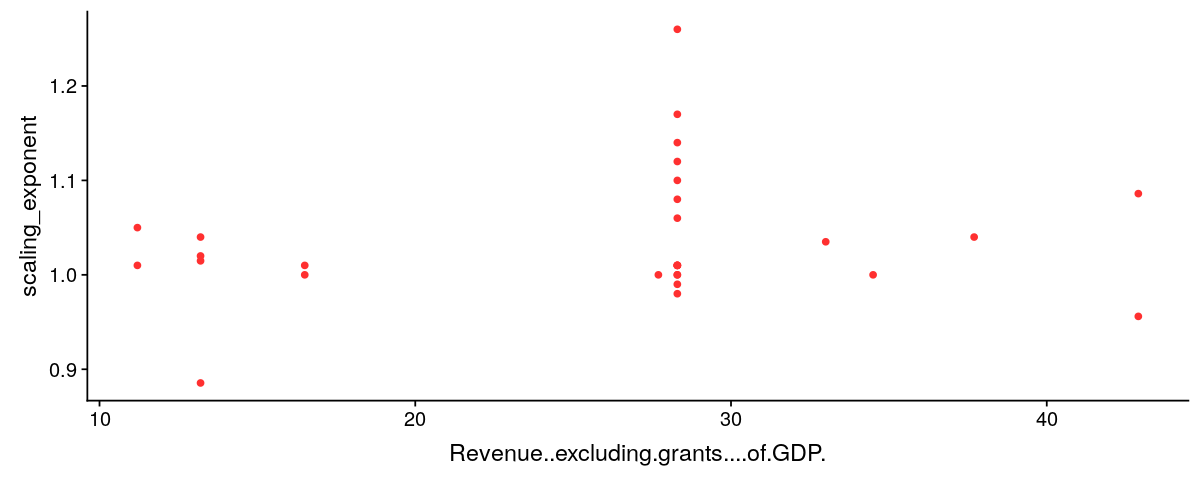

[1] "School.enrollment..primary....gross."


Warning message:
“Removed 1 rows containing missing values (geom_point).”

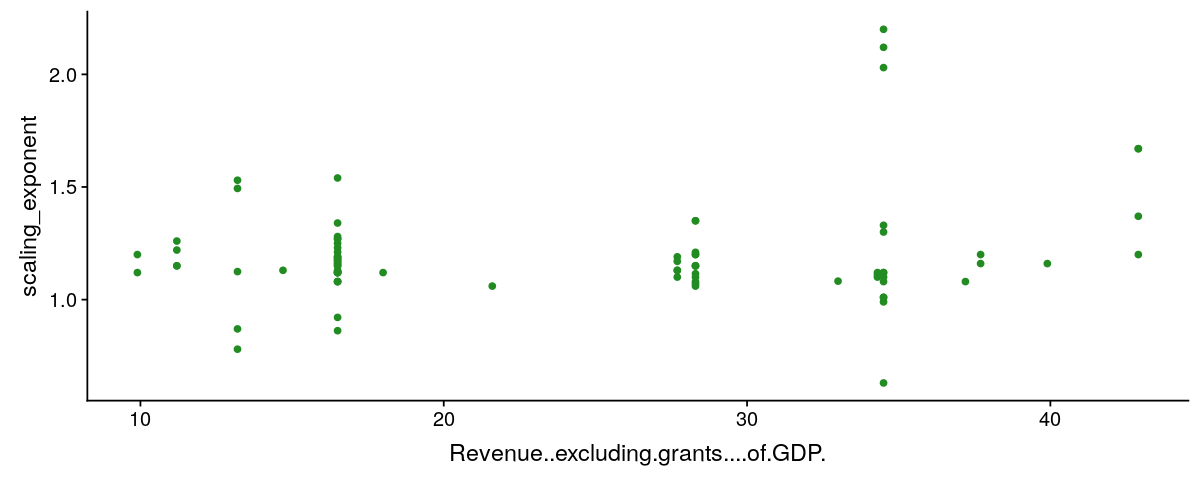

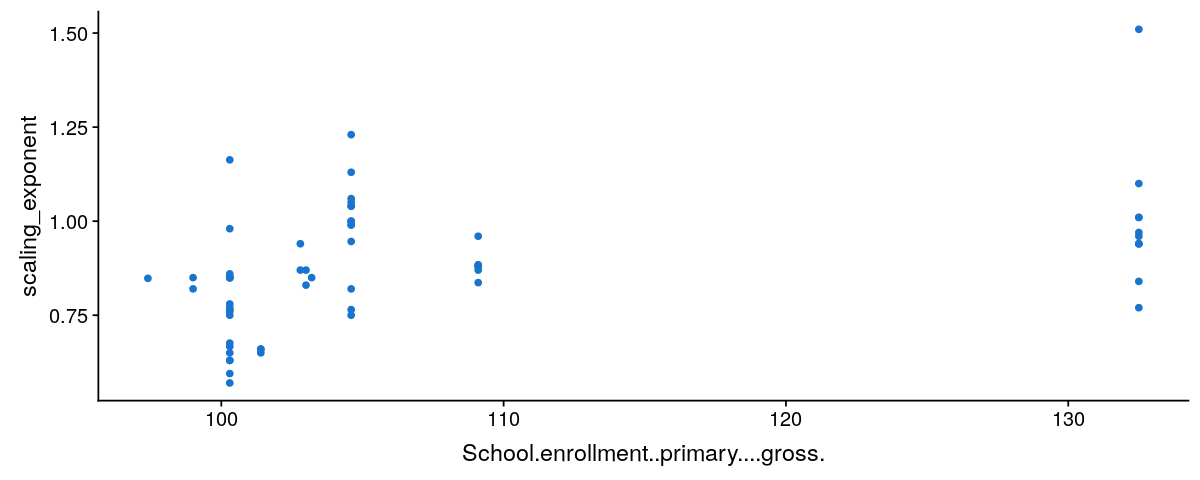

Warning message:
“Removed 2 rows containing missing values (geom_point).”

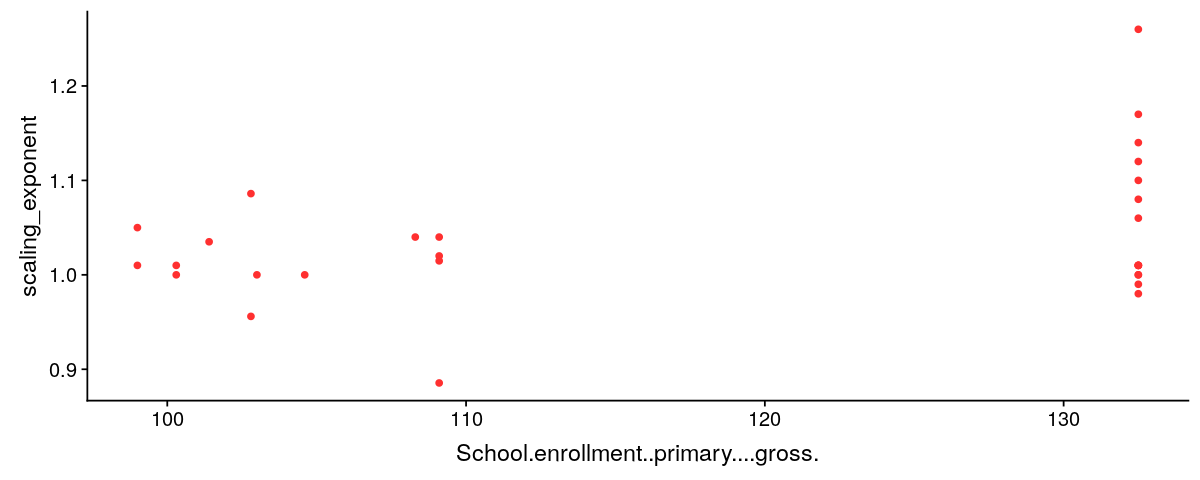

[1] "School.enrollment..primary.and.secondary..gross...gender.parity.index..GPI."


Warning message:
“Removed 12 rows containing missing values (geom_point).”

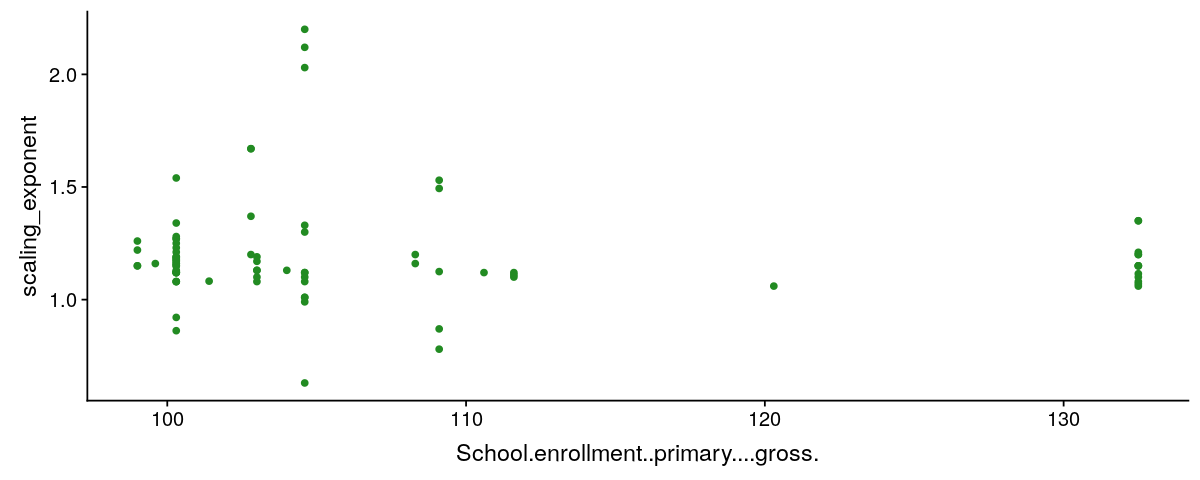

Warning message:
“Removed 15 rows containing missing values (geom_point).”

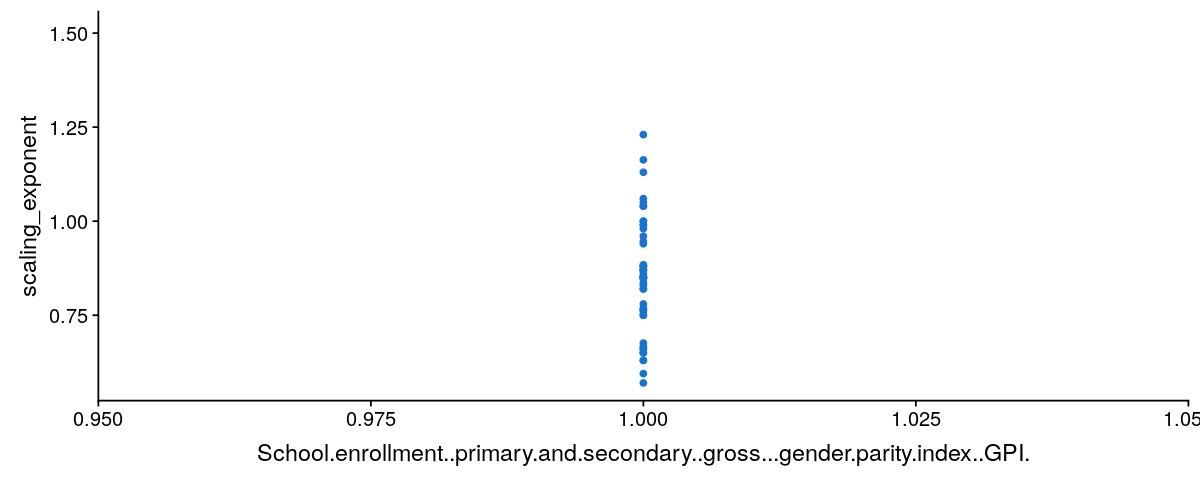

Warning message:
“Removed 15 rows containing missing values (geom_point).”

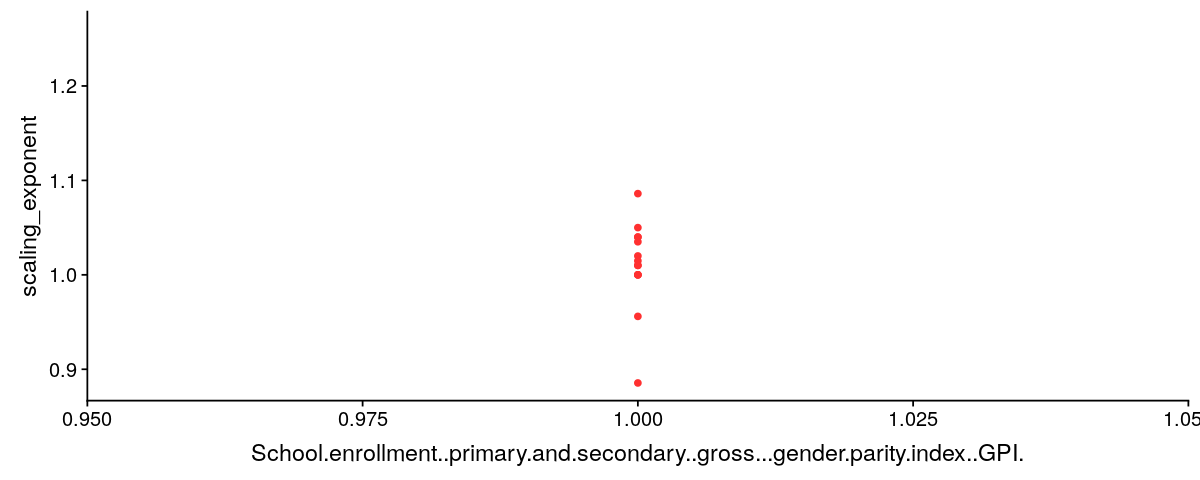

[1] "School.enrollment..secondary....gross."


Warning message:
“Removed 12 rows containing missing values (geom_point).”

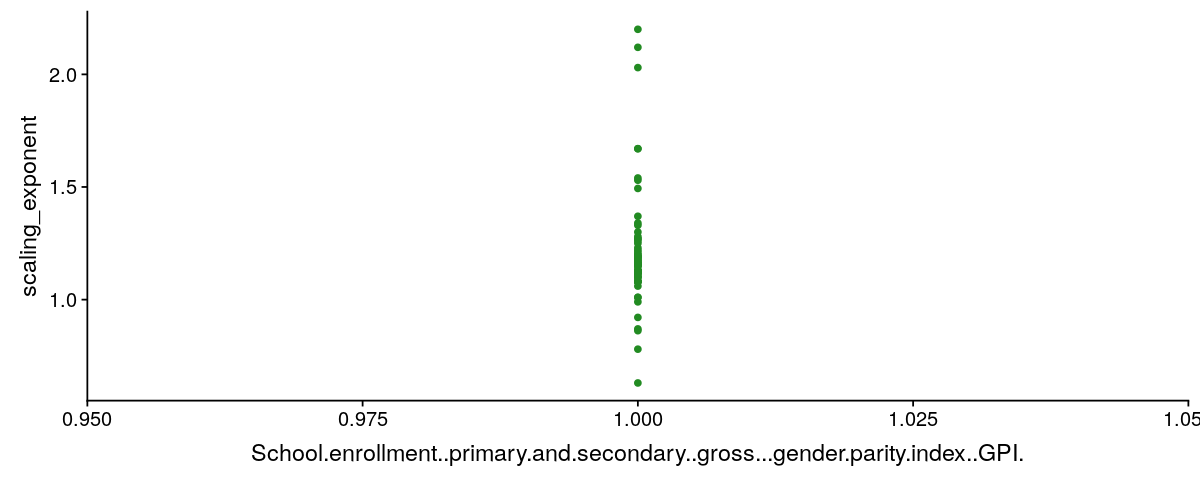

Warning message:
“Removed 15 rows containing missing values (geom_point).”

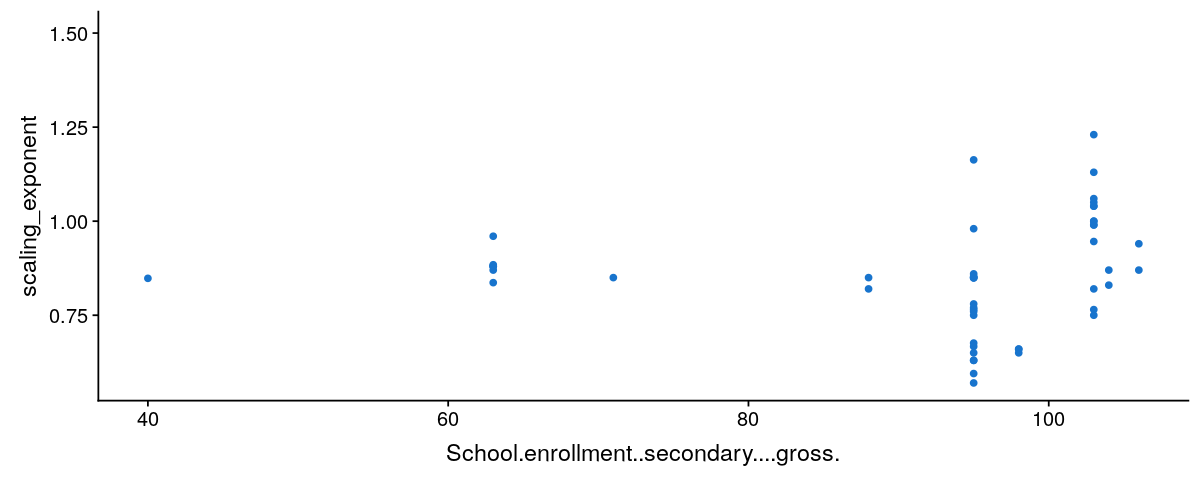

Warning message:
“Removed 15 rows containing missing values (geom_point).”

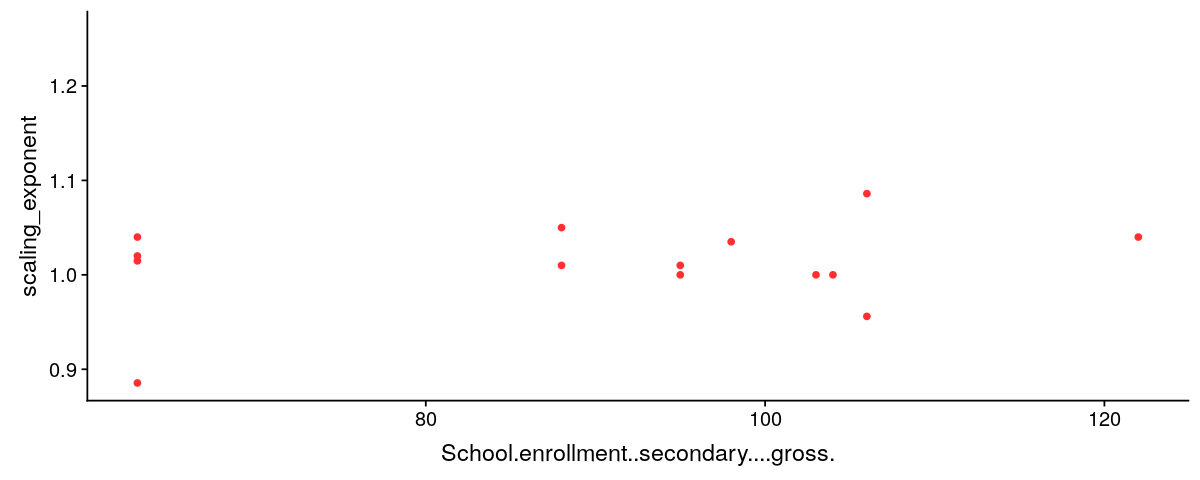

[1] "Statistical.Capacity.score..Overall.average."


Warning message:
“Removed 43 rows containing missing values (geom_point).”

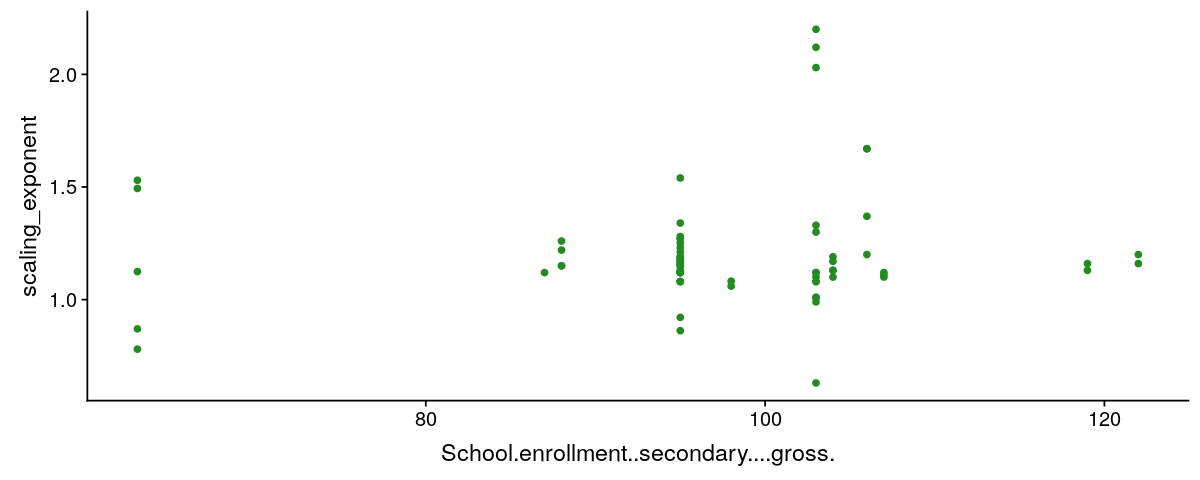

Warning message:
“Removed 8 rows containing missing values (geom_point).”

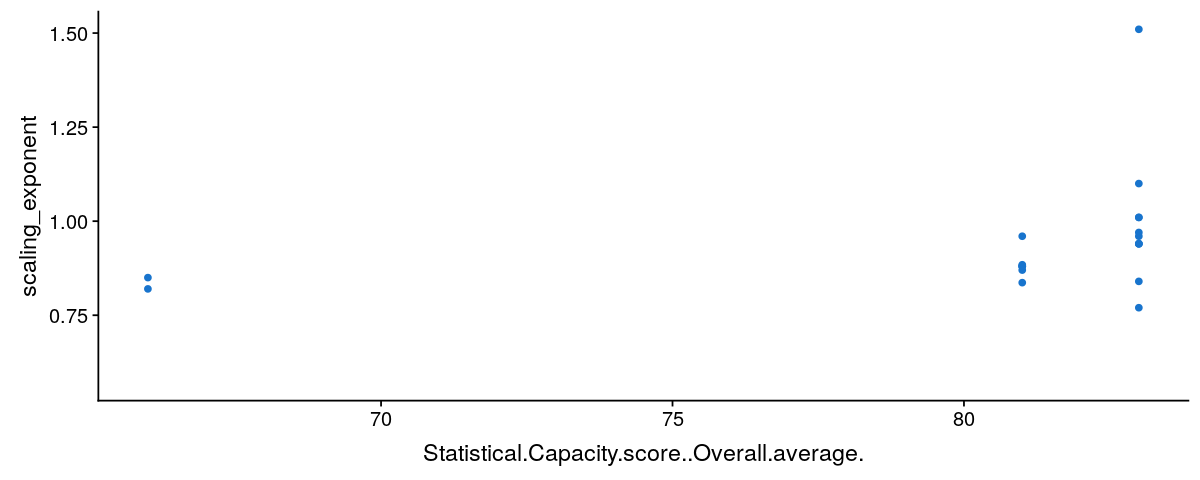

Warning message:
“Removed 62 rows containing missing values (geom_point).”

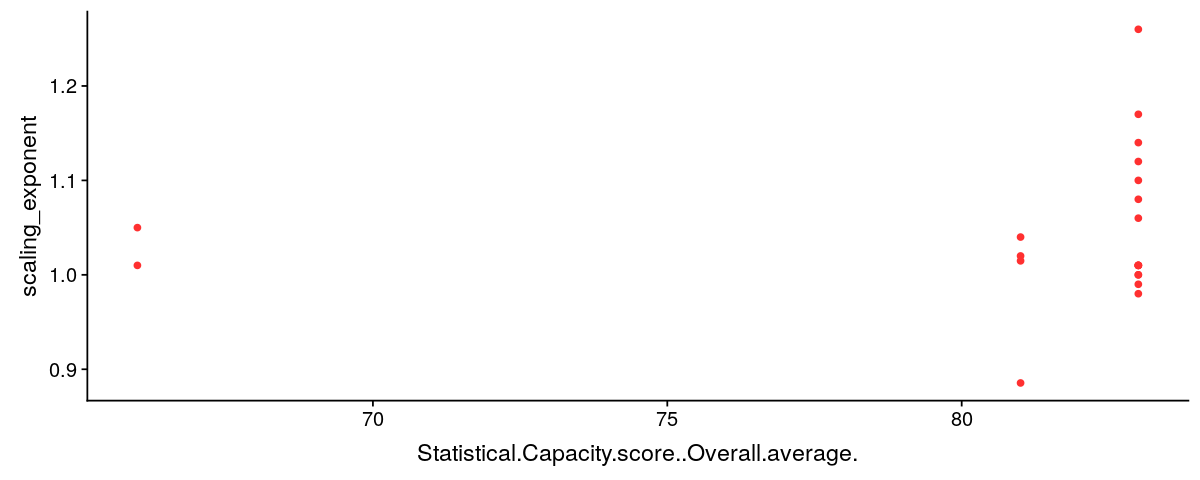

[1] "Surface.area..sq..km."


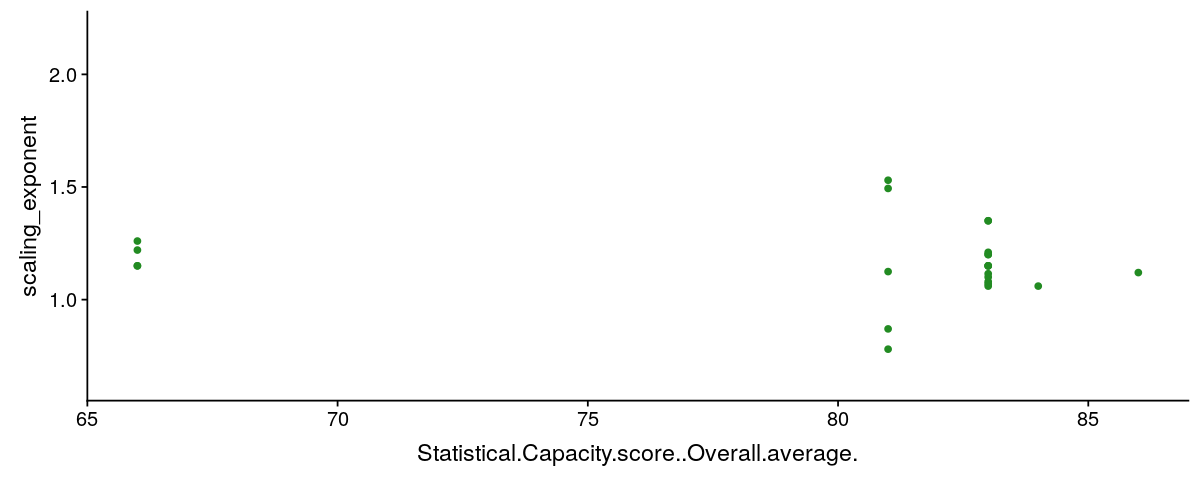

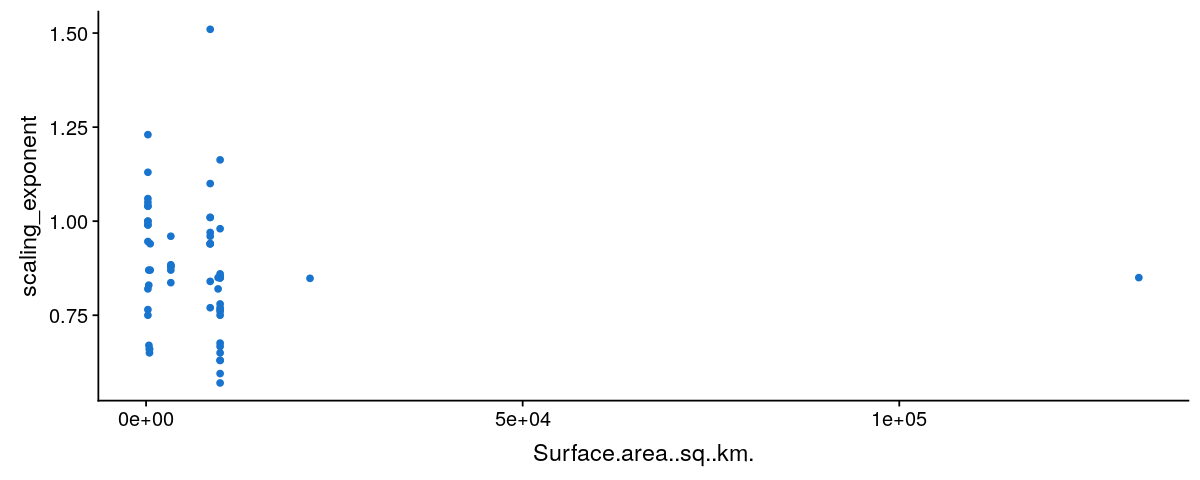

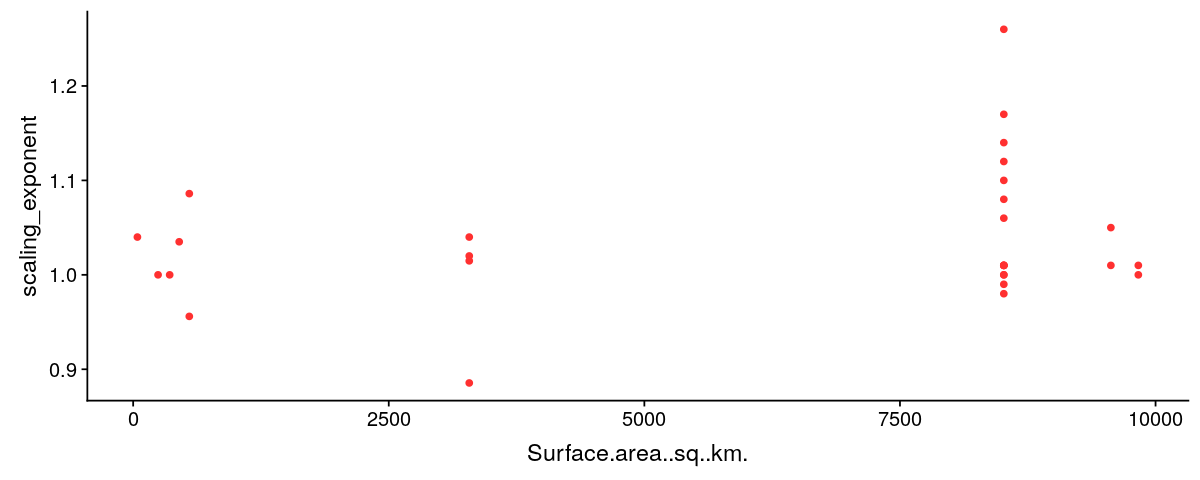

[1] "Tax.revenue....of.GDP."


Warning message:
“Removed 1 rows containing missing values (geom_point).”

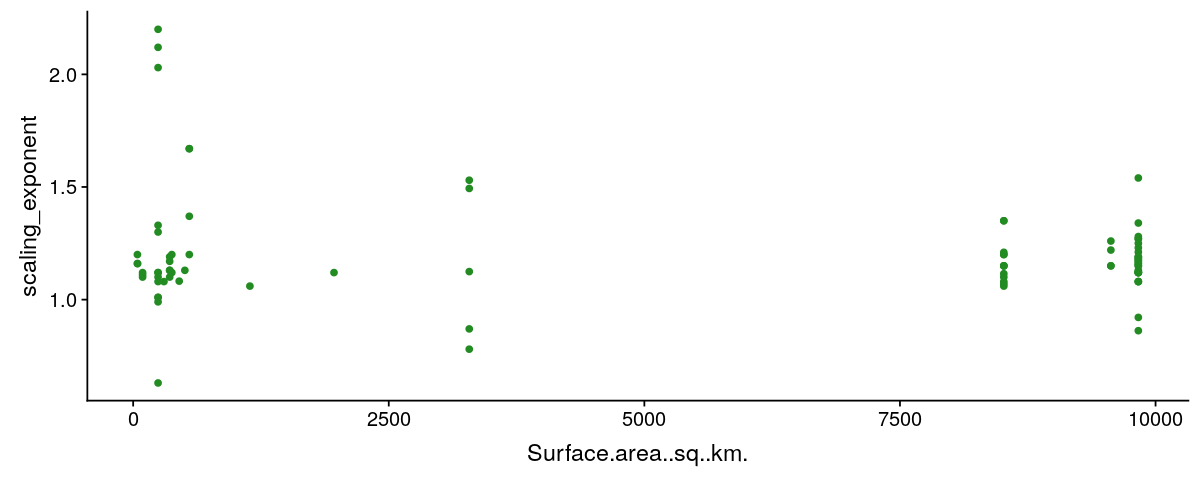

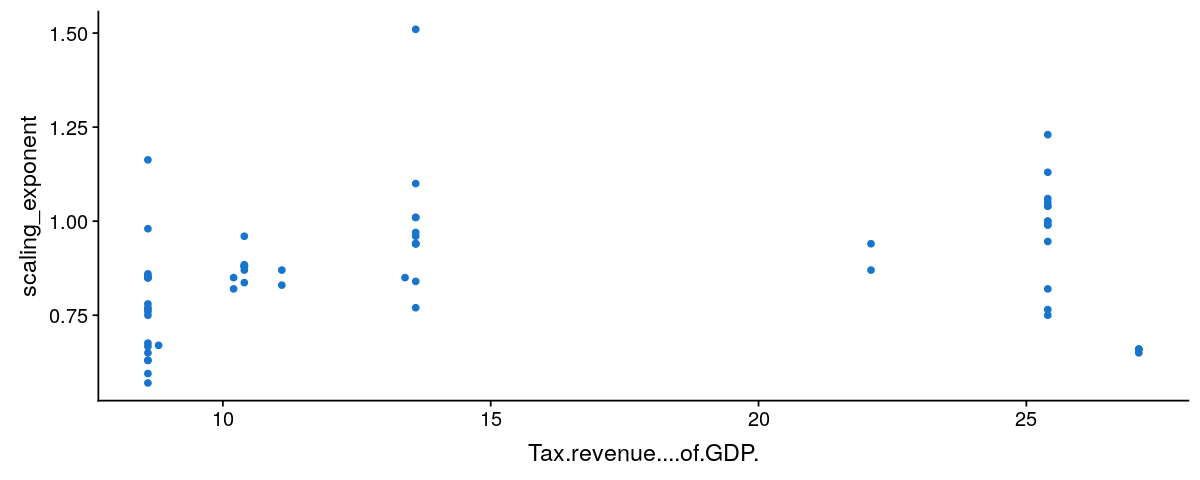

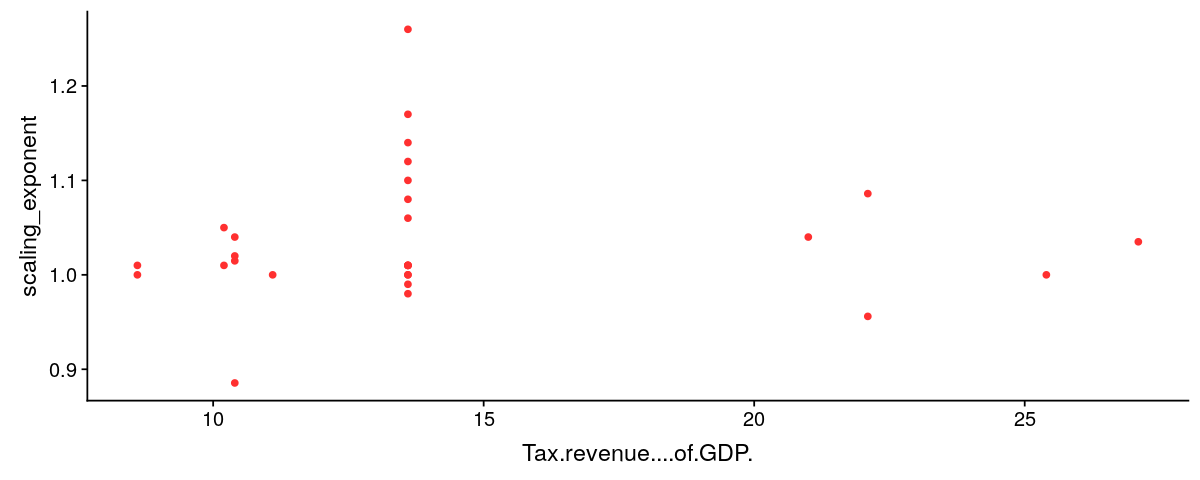

[1] "Terrestrial.and.marine.protected.areas....of.total.territorial.area."


Warning message:
“Removed 63 rows containing missing values (geom_point).”

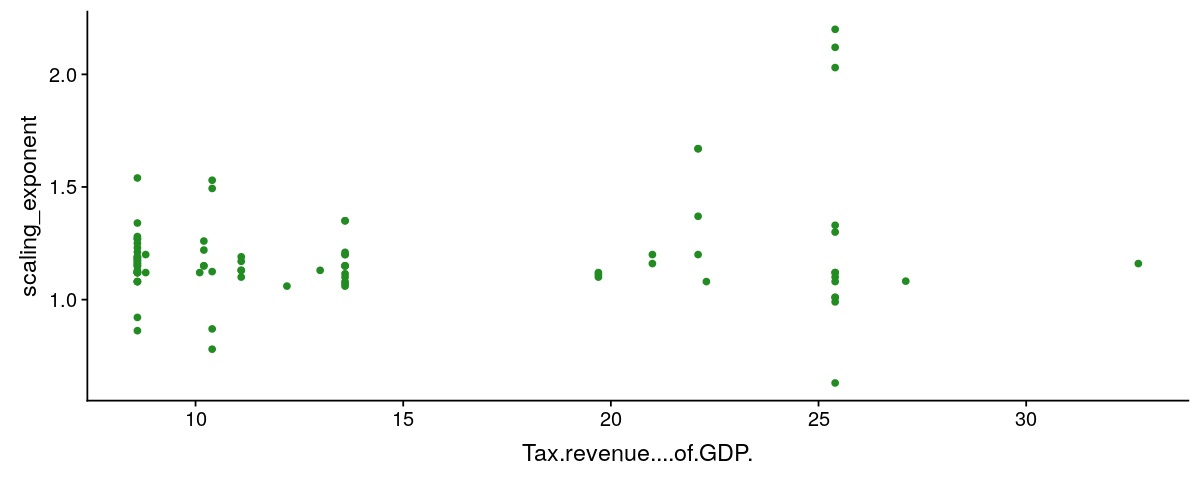

Warning message:
“Removed 29 rows containing missing values (geom_point).”

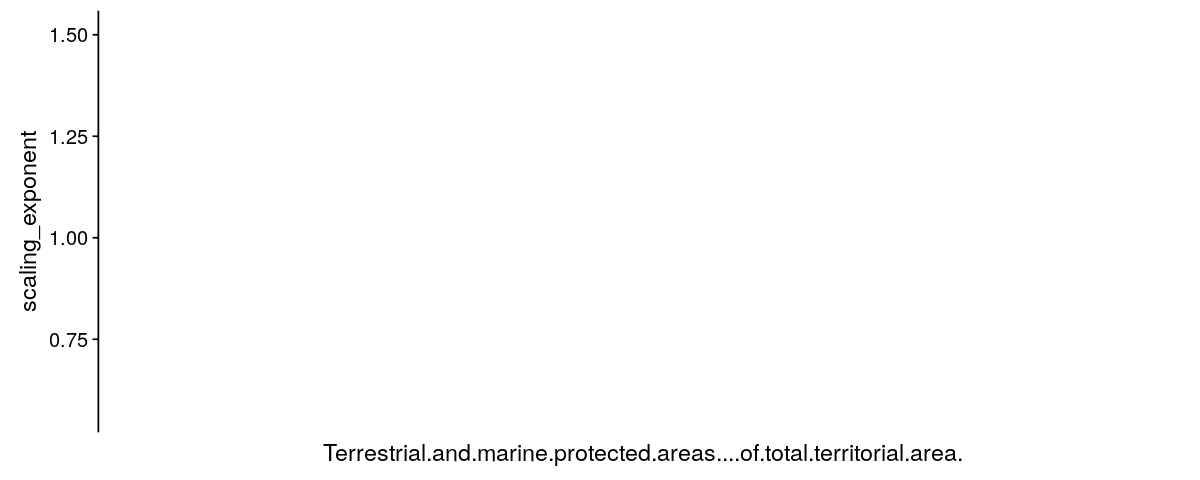

Warning message:
“Removed 86 rows containing missing values (geom_point).”

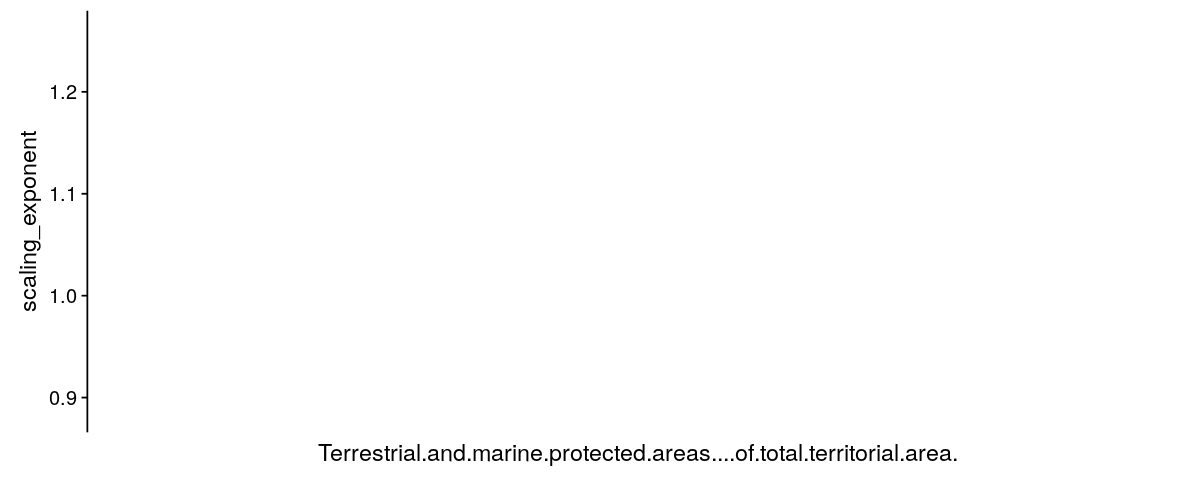

[1] "Time.required.to.start.a.business..days."


Warning message:
“Removed 40 rows containing missing values (geom_point).”

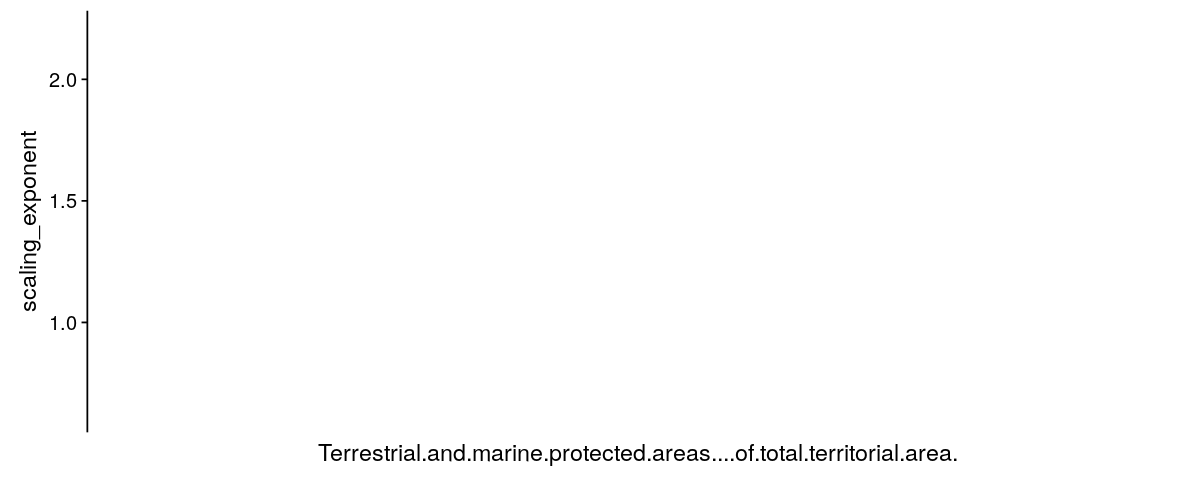

Warning message:
“Removed 23 rows containing missing values (geom_point).”

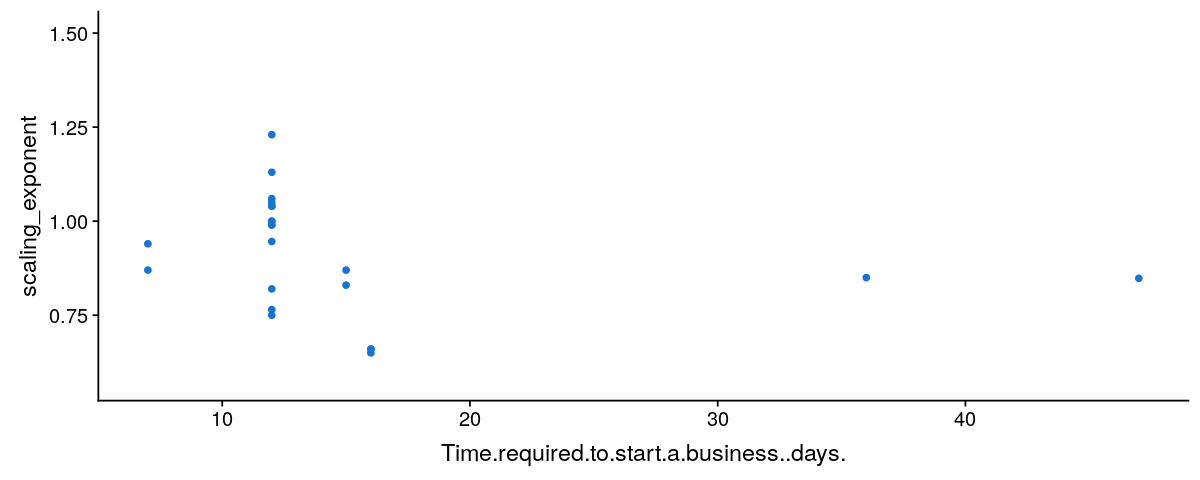

Warning message:
“Removed 54 rows containing missing values (geom_point).”

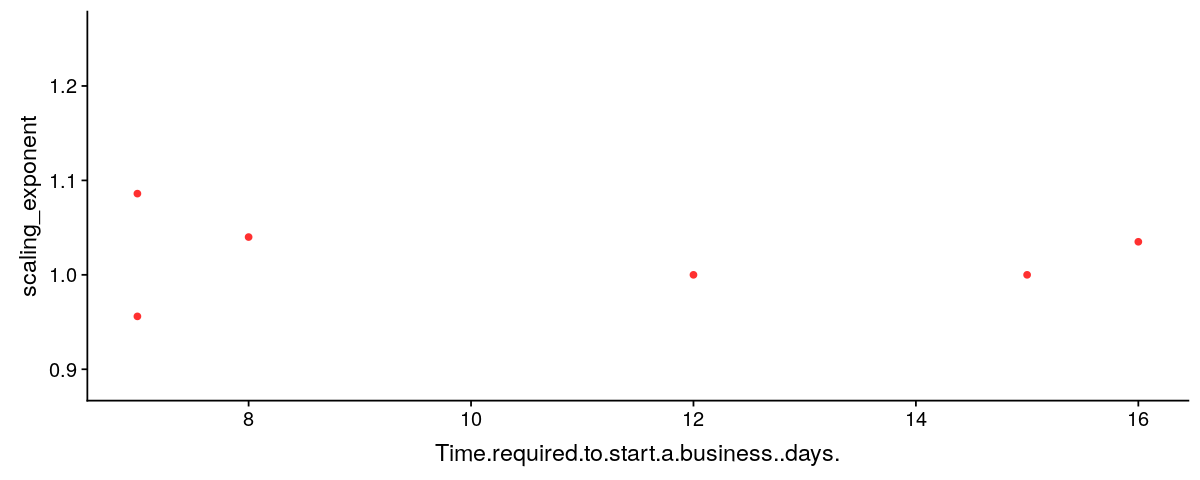

[1] "Total.debt.service....of.exports.of.goods..services.and.primary.income."


Warning message:
“Removed 43 rows containing missing values (geom_point).”

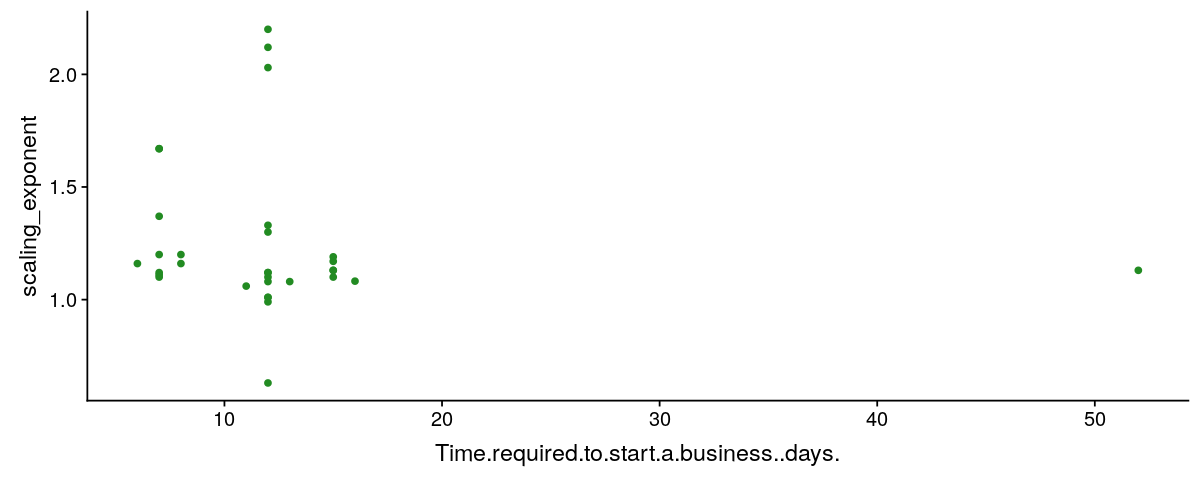

Warning message:
“Removed 8 rows containing missing values (geom_point).”

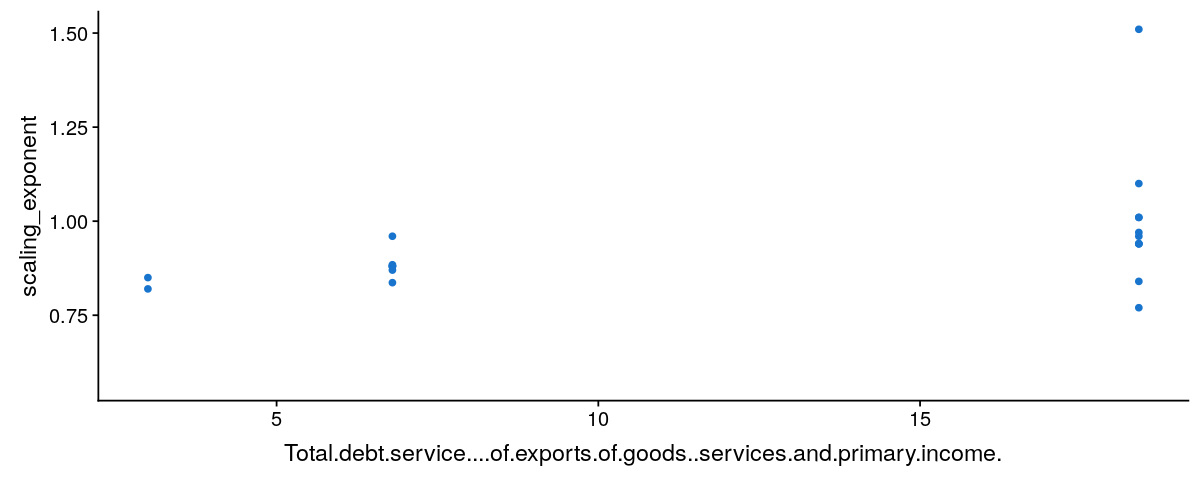

Warning message:
“Removed 62 rows containing missing values (geom_point).”

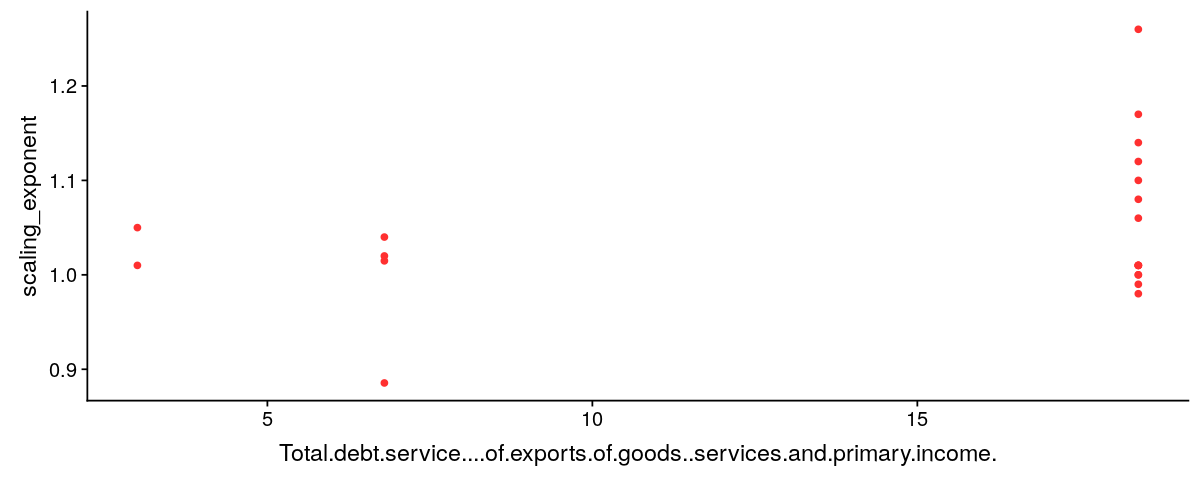

[1] "Urban.population.growth..annual..."


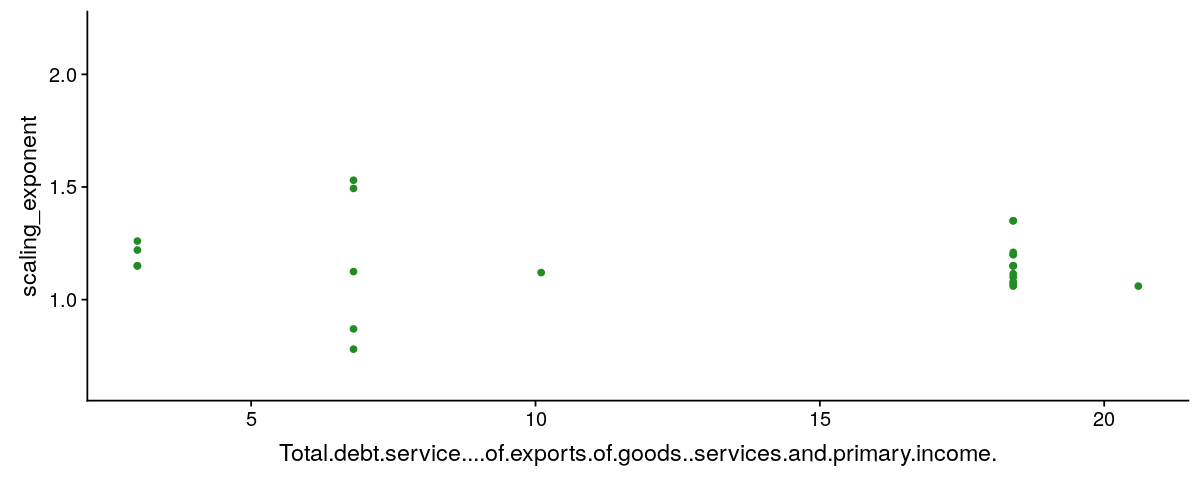

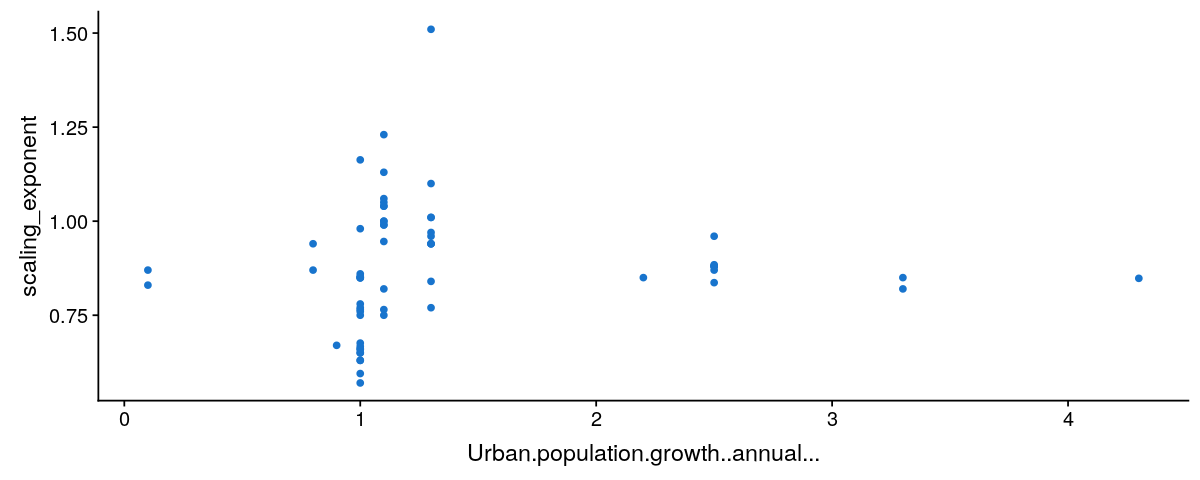

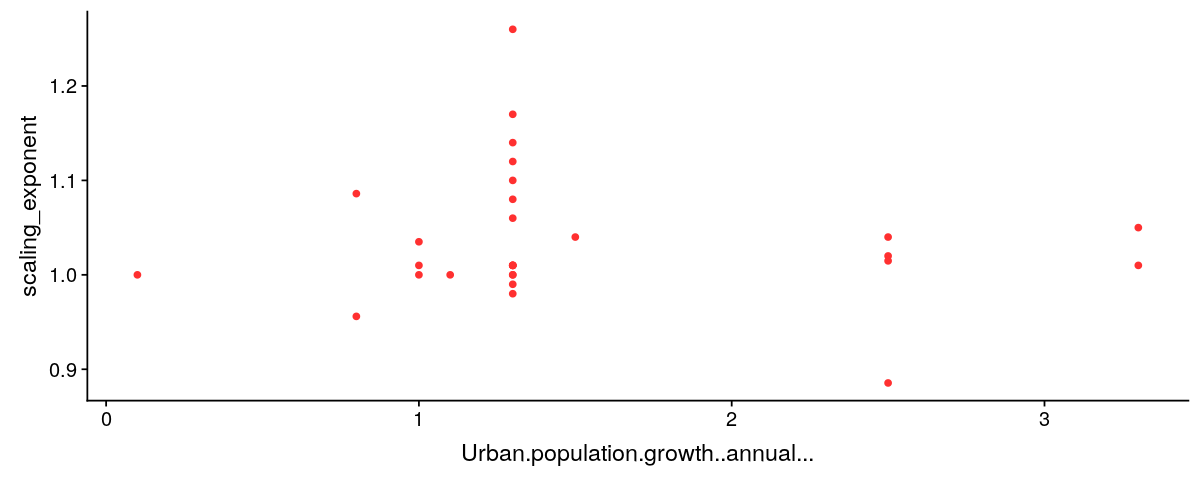

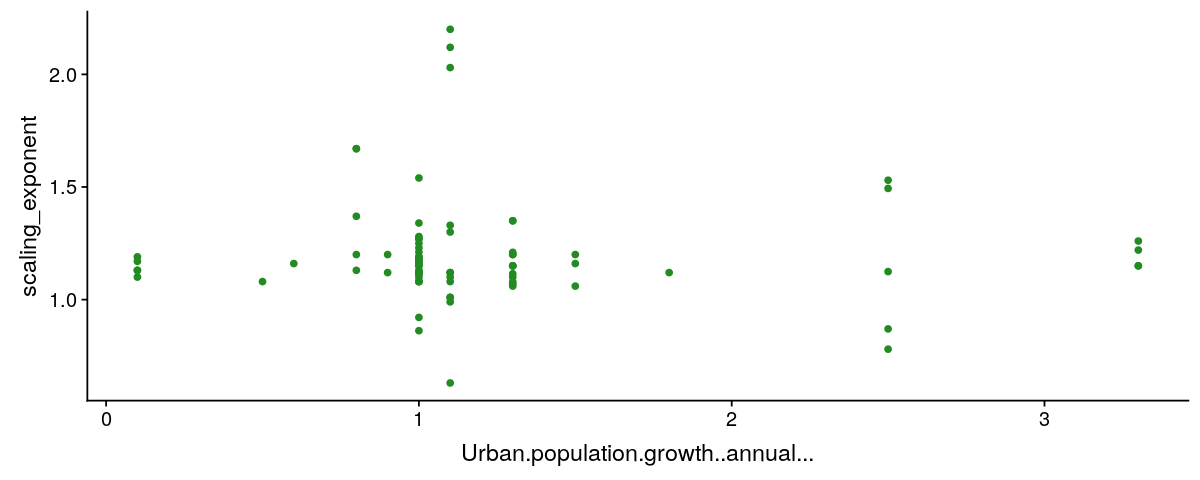

In [216]:
for (i in seq(10, 66, by = 1)){
    
    print(colnames(join)[i])
    print(ggplot(join[join$variable_regime=='sublinear',], aes_string(x=colnames(join)[i], y='scaling_exponent'))+geom_point(colour = "dodgerblue3"))
    print(ggplot(join[join$variable_regime=='linear',], aes_string(x=colnames(join)[i], y='scaling_exponent'))+geom_point(colour = "firebrick1"))
    print(ggplot(join[join$variable_regime=='superlinear',], aes_string(x=colnames(join)[i], y='scaling_exponent'))+geom_point(colour = "forestgreen"))
}

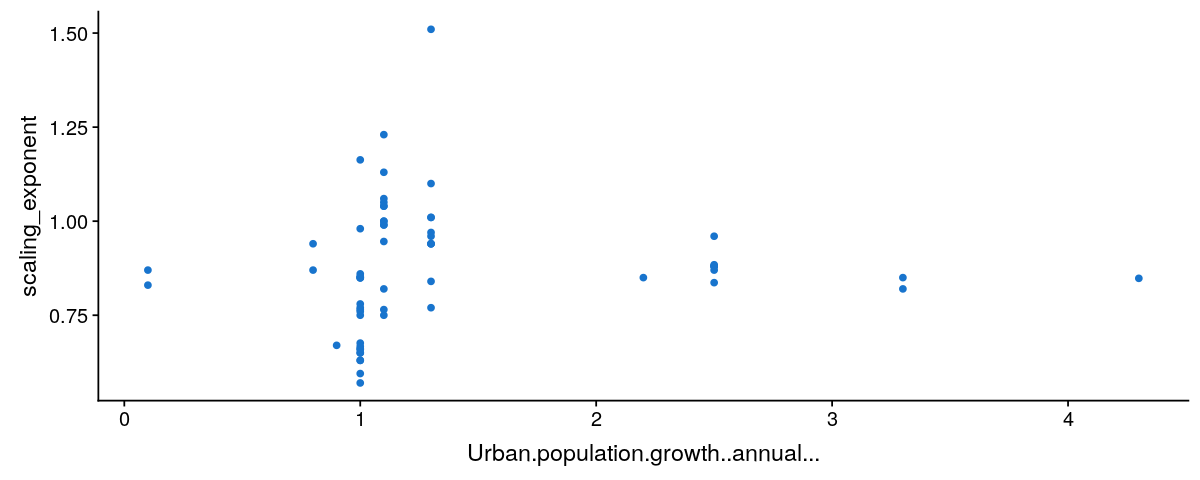

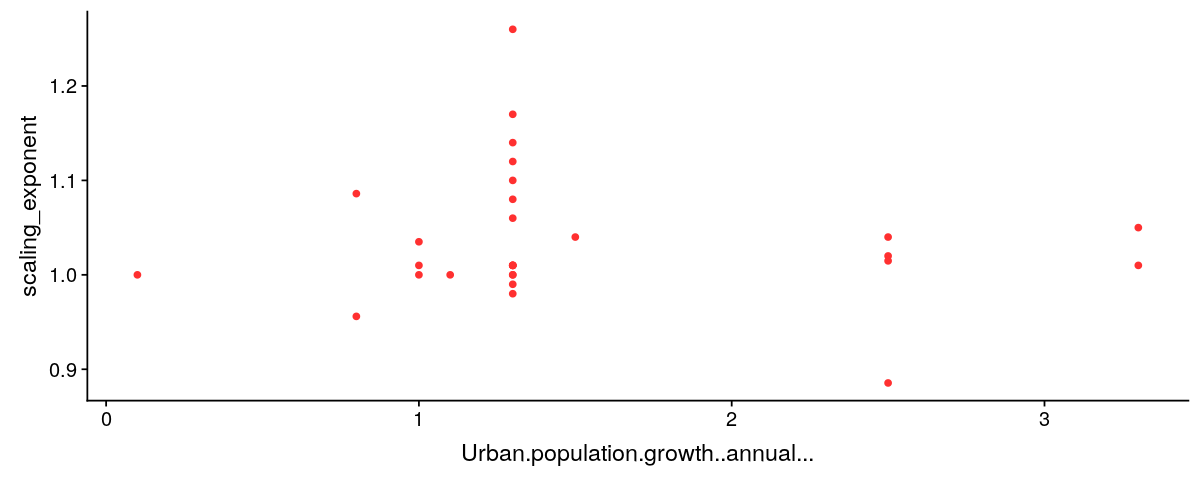

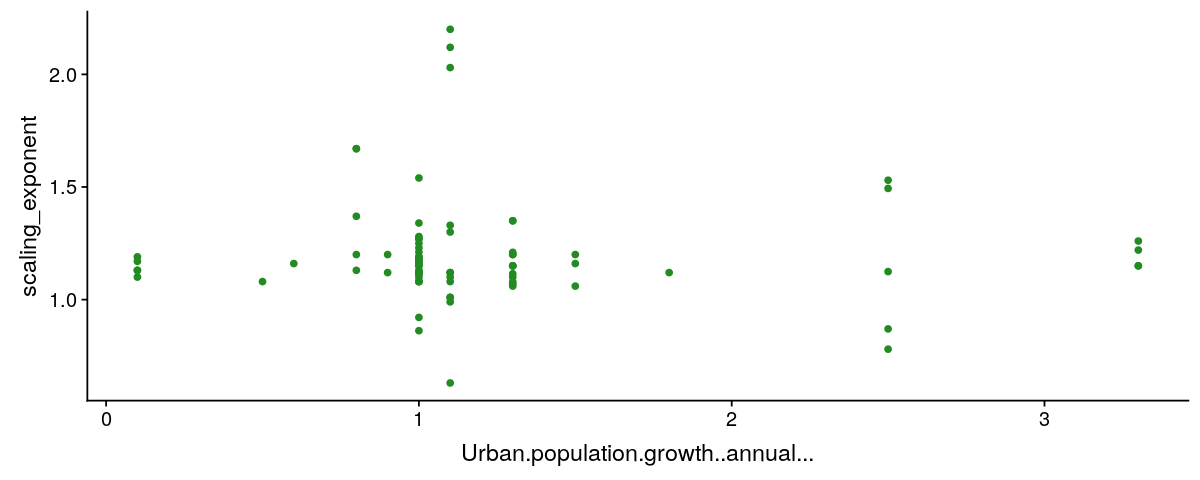